In [178]:
import pandas as pd, numpy as np, re, ast
from pathlib import Path

# Pfade Static
SP = Path("/Users/jakob/ba_etl/static_pipeline")
SP_ADAPTERS = {
    "ID_IMDB":      SP/"data/intermediate_adapter_outputs/ImdbAdapter.csv",
    "ID_MOVIELENS": SP/"data/intermediate_adapter_outputs/MovielensAdapter.csv",
    "ID_METACRITIC":SP/"data/intermediate_adapter_outputs/MetacriticAdapter.csv",
    "ID_RT":        SP/"data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv",
}
SP_UNFILTERED = SP/"data/processed/all_movies_wide_unfiltered.csv"
SP_FINAL      = SP/"data/processed/test_merge_result.csv"     # falls vorhanden
SP_SUPERSCORE = SP/"data/processed/final_filtered_superscore.csv"

# Pfade Adaptive
AP = Path("/Users/jakob/ba_etl/adaptive")
AP_CLEAN = {
    "ID_IMDB":      AP/"cleaned/imdb_data.csv",
    "ID_MOVIELENS": AP/"cleaned/movielens_aggregated.csv",
    "ID_METACRITIC":AP/"cleaned/metacritic_movies.csv",
    "ID_RT":        AP/"cleaned/rotten_tomatoes_movies.csv",
}
AP_UNFILTERED = AP/"merged/all_movies.csv"
AP_FINAL_WIDE = AP/"merged/all_movies_wide_fuzzy.csv"
AP_SUPERSCORE = AP/"merged/all_movies_superscore_adaptive.csv"

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load_csv(p: Path) -> pd.DataFrame:
    try: return pd.read_csv(p)
    except Exception: return pd.DataFrame()

def cast_ids(df: pd.DataFrame) -> pd.DataFrame:
    for c in [*ID_ORDER, "ID"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def film_sig(row: pd.Series, cols: list[str]) -> str:
    return "|".join(str(int(row[c])) if pd.notna(row.get(c, pd.NA)) else "NA" for c in cols)

def make_sig_col(df: pd.DataFrame, cols: list[str], name="__sig__") -> pd.DataFrame:
    df[name] = df.apply(lambda r: film_sig(r, cols), axis=1)
    return df

In [179]:
def check_pipeline_id_stability(name: str, raw_map: dict[str, Path], unfiltered_p: Path, final_p: Path | None, superscore_p: Path):
    raw_sets = {}
    for id_col, p in raw_map.items():
        df = cast_ids(load_csv(p))
        if id_col in df.columns:
            raw_sets[id_col] = set(df[id_col].dropna().astype(int))
    unfiltered = cast_ids(load_csv(unfiltered_p))
    final      = cast_ids(load_csv(final_p)) if final_p and final_p.exists() else pd.DataFrame()
    superdf    = cast_ids(load_csv(superscore_p))

    report = []
    for id_col, raw_ids in raw_sets.items():
        ids_unf = set(unfiltered[id_col].dropna().astype(int)) if id_col in unfiltered.columns else set()
        ids_fin = set(final[id_col].dropna().astype(int))      if id_col in final.columns      else set()
        ids_sup = set(superdf[id_col].dropna().astype(int))    if id_col in superdf.columns    else set()

        miss_unf = raw_ids - ids_unf
        miss_fin = (ids_unf - ids_fin) if len(final) else set()
        miss_sup = ids_unf - ids_sup

        report.append({
            "pipeline": name, "id_col": id_col,
            "raw_cnt": len(raw_ids), "unfiltered_cnt": len(ids_unf),
            "final_cnt": len(ids_fin) if len(final) else None,
            "superscore_cnt": len(ids_sup),
            "raw_not_in_unfiltered": len(miss_unf),
            "unfiltered_not_in_superscore": len(miss_sup),
            "unfiltered_not_in_final": len(miss_fin) if len(final) else None,
        })
    return pd.DataFrame(report)

rep_static = check_pipeline_id_stability(
    "static", SP_ADAPTERS, SP_UNFILTERED, SP_FINAL, SP_SUPERSCORE
)
rep_adapt  = check_pipeline_id_stability(
    "adaptive", AP_CLEAN, AP_UNFILTERED, AP_FINAL_WIDE, AP_SUPERSCORE
)

display(rep_static)
display(rep_adapt)

,pipeline,id_col,raw_cnt,unfiltered_cnt,final_cnt,superscore_cnt,raw_not_in_unfiltered,unfiltered_not_in_superscore,unfiltered_not_in_final
0,static,ID_IMDB,3343,0,3007,3007,3343,0,0
1,static,ID_MOVIELENS,9706,0,5557,5557,9706,0,0
2,static,ID_METACRITIC,9120,0,7602,7602,9120,0,0
3,static,ID_RT,17541,0,9223,9223,17541,0,0


,pipeline,id_col,raw_cnt,unfiltered_cnt,final_cnt,superscore_cnt,raw_not_in_unfiltered,unfiltered_not_in_superscore,unfiltered_not_in_final
0,adaptive,ID_IMDB,3343,3343,3005,3005,0,338,338
1,adaptive,ID_MOVIELENS,9706,9704,5548,5548,2,4156,4156
2,adaptive,ID_METACRITIC,9120,9110,7596,7596,10,1514,1514


In [180]:
gt  = cast_ids(load_csv(SP_SUPERSCORE))     # Groundtruth = statisch (Superscore)
adp = cast_ids(load_csv(AP_SUPERSCORE))     # Adaptive (Superscore)

common_ids = [c for c in ID_ORDER if c in gt.columns and c in adp.columns]
gt  = make_sig_col(gt,  common_ids, "__sig__")
adp = make_sig_col(adp, common_ids, "__sig__")

gt_sig  = set(gt["__sig__"].dropna())
adp_sig = set(adp["__sig__"].dropna())

TP_sig  = sorted(gt_sig & adp_sig)
FN_sig  = sorted(gt_sig - adp_sig)   # in GT, nicht in ADP
FP_sig  = sorted(adp_sig - gt_sig)   # in ADP, nicht in GT

print(f"TP: {len(TP_sig)}  |  FN: {len(FN_sig)}  |  FP: {len(FP_sig)}")

# Tabellen mit Basisfeldern
def pick_cols(df): 
    base = ["__sig__","title","release_year","genres"]
    ids  = [c for c in ID_ORDER if c in df.columns]
    return df[[c for c in (ids+base) if c in df.columns]]

FN_rows = pick_cols(gt[gt["__sig__"].isin(FN_sig)]).reset_index(drop=True)
FP_rows = pick_cols(adp[adp["__sig__"].isin(FP_sig)]).reset_index(drop=True)
print("FN-Beispiele (in GT, nicht in ADP):", len(FN_rows)); display(FN_rows.head(50))
print("FP-Beispiele (in ADP, nicht in GT):", len(FP_rows)); display(FP_rows.head(50))

TP: 9556  |  FN: 15  |  FP: 8
FN-Beispiele (in GT, nicht in ADP): 15


,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,__sig__,title,release_year,genres
0,2681,8514,1705,3020,2681|8514|1705|3020,automata,2014,"['Action', 'Drama', 'Sci-Fi']"
1,1886,7060,7336,4104,1886|7060|7336|4104,bruno,2009,['Comedy']
2,1639,6333,7769,5368,1639|6333|7769|5368,deja vu,2006,"['Action', 'Crime', 'Sci-Fi']"
3,2568,<NA>,4583,9412,2568|NA|4583|9412,les miserables,2012,"['Drama', 'Musical', 'Romance']"
4,<NA>,4253,1606,8486,NA|4253|1606|8486,irreversible,2002,"['Drama', 'Mystery', 'Thriller', 'Crime']"
5,1037,<NA>,2350,17577,1037|NA|2350|17577,y tu mama tambien,2001,['Drama']
6,<NA>,2977,1839,1328,NA|2977|1839|1328,malena,2000,"['Drama', 'Comedy', 'Romance', 'War']"
7,<NA>,3779,4265,12290,NA|3779|4265|12290,rashomon,1950,"['Drama', 'Mystery', 'Crime']"
8,<NA>,7503,4201,<NA>,NA|7503|4201|NA,even the rain tambien la lluvia,2010,['History']
9,<NA>,7282,8746,<NA>,NA|7282|8746|NA,oceans,2009,"['Drama', 'Documentary']"


FP-Beispiele (in ADP, nicht in GT): 8


,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,__sig__,title,release_year,genres
0,<NA>,950,<NA>,2041,NA|950|NA|2041,8 12 8,1963,"['Drama', 'Fantasy']"
1,2681,<NA>,1705,3020,2681|NA|1705|3020,autmata,2014,"['Action', 'Drama', 'Sci-Fi']"
2,<NA>,<NA>,7336,4104,NA|NA|7336|4104,bruno,2009,['Comedy']
3,1639,<NA>,7769,<NA>,1639|NA|7769|NA,deja vu,2006,"['Action', 'Crime', 'Sci-Fi']"
4,2568,<NA>,<NA>,9412,2568|NA|NA|9412,les misrables,2012,"['Drama', 'Musical', 'Romance']"
5,<NA>,2977,1839,<NA>,NA|2977|1839|NA,malna,2000,"['Drama', 'Comedy', 'Romance', 'War']"
6,<NA>,5508,<NA>,17188,NA|5508|NA|17188,what have i done to deserve this qu he hecho y...,1984,"['Comedy', 'Drama']"
7,1037,<NA>,2350,<NA>,1037|NA|2350|NA,y tu mam tambin,2001,['Drama']


Counts:


,ADP:Positiv,ADP:Negativ
GT:Positiv,9556,15
GT:Negativ,8,0



Row-%:


,ADP:Positiv,ADP:Negativ
GT:Positiv,99.8400,0.1600
GT:Negativ,100.0000,0.0000



Col-%:


,ADP:Positiv,ADP:Negativ
GT:Positiv,99.9200,100.0000
GT:Negativ,0.0800,0.0000



TP=9556  FN=15  FP=8  TN=0
Precision=0.9992  Recall=0.9984  F1=0.9988  Jaccard=0.9976  Accuracy(std)=0.9976


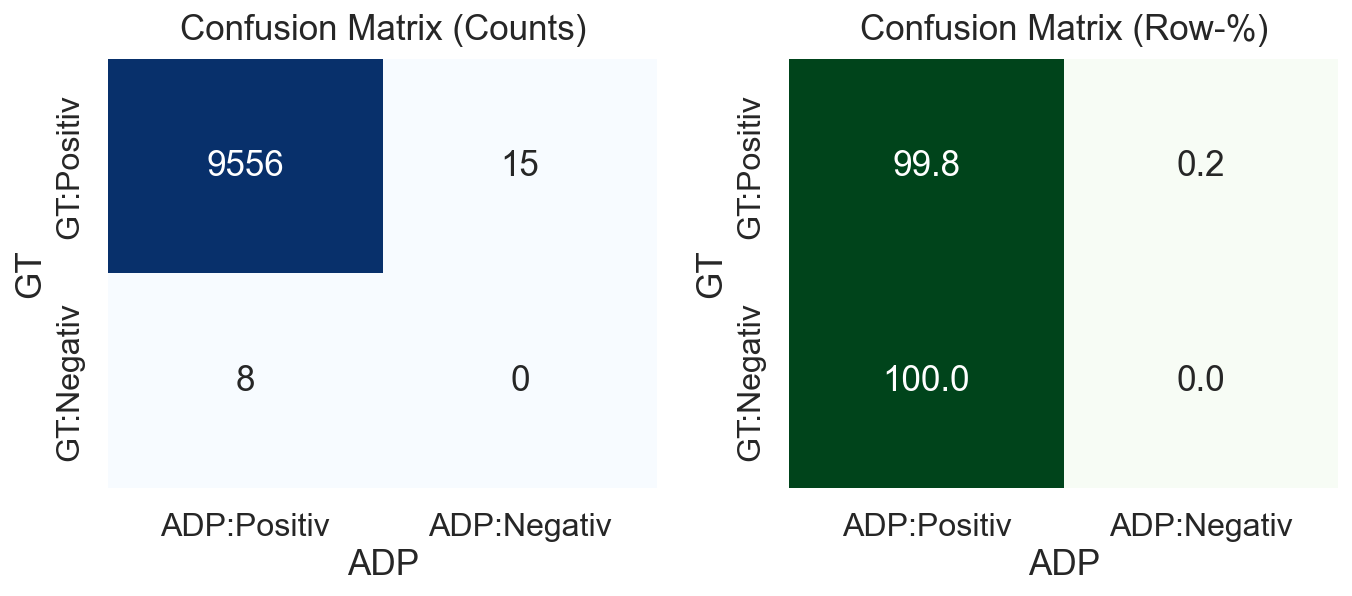

In [183]:
# Confusion-Matrix (auf Basis der bereits berechneten TP_sig, FN_sig, FP_sig)
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

TP, FN, FP = len(TP_sig), len(FN_sig), len(FP_sig)
TN = 0  # für diesen Set-Vergleich nicht sinnvoll definierbar

cm_counts = pd.DataFrame([[TP, FN],[FP, TN]],
                         index=["GT:Positiv","GT:Negativ"],
                         columns=["ADP:Positiv","ADP:Negativ"])

# Zeilen- und Spalten-Prozente
cm_row_pct = cm_counts.div(cm_counts.sum(axis=1).replace(0, np.nan), axis=0).round(4) * 100
cm_col_pct = cm_counts.div(cm_counts.sum(axis=0).replace(0, np.nan), axis=1).round(4) * 100

print("Counts:")
display(cm_counts)

print("\nRow-%:")
display(cm_row_pct)

print("\nCol-%:")
display(cm_col_pct)

# Metriken (TN=0 → 'Accuracy(std)' ist nicht aussagekräftig)
precision = TP / (TP + FP) if (TP + FP) else np.nan
recall    = TP / (TP + FN) if (TP + FN) else np.nan
f1        = (2*precision*recall)/(precision+recall) if (precision and recall) else np.nan
jaccard   = TP / (TP + FP + FN) if (TP + FP + FN) else np.nan
acc_std   = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) else np.nan

print(f"\nTP={TP}  FN={FN}  FP={FP}  TN={TN}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}  Accuracy(std)={acc_std:.4f}")

# Heatmaps
plt.figure(figsize=(10,4.6))
plt.subplot(1,2,1)
sns.heatmap(cm_counts, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("ADP"); plt.ylabel("GT")

plt.subplot(1,2,2)
sns.heatmap(cm_row_pct, annot=True, fmt=".1f", cmap="Greens", vmin=0, vmax=100, cbar=False)
plt.title("Confusion Matrix (Row-%)")
plt.xlabel("ADP"); plt.ylabel("GT")

plt.tight_layout(); plt.show()

In [181]:
import pandas as pd
from pathlib import Path

# Pfade
P_GT  = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
P_ADP = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")

ADP_CLEAN = {
    "ID_IMDB":      Path("/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"),
    "ID_MOVIELENS": Path("/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"),
    "ID_METACRITIC":Path("/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"),
    "ID_RT":        Path("/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"),
}

ID_COLS = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load_csv(p): 
    try: return pd.read_csv(p)
    except: return pd.DataFrame()

def cast_ids(df):
    for c in [*ID_COLS, "ID"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def make_sig(row, cols):
    return "|".join(str(int(row[c])) if pd.notna(row.get(c, pd.NA)) else "NA" for c in cols)

# 1) GT-only Tabelle herstellen (Signatur-Vergleich GT vs ADP)
gt  = cast_ids(load_csv(P_GT))
adp = cast_ids(load_csv(P_ADP))

common_ids = [c for c in ID_COLS if c in gt.columns and c in adp.columns]
gt["__sig__"]  = gt.apply(lambda r: make_sig(r, common_ids), axis=1)
adp["__sig__"] = adp.apply(lambda r: make_sig(r, common_ids), axis=1)

sig_gt  = set(gt["__sig__"].dropna())
sig_adp = set(adp["__sig__"].dropna())
sig_only_gt = sorted(sig_gt - sig_adp)

gt_only = gt[gt["__sig__"].isin(sig_only_gt)].copy()

# 2) ADP-cleaned Mappings: ID -> title
maps = {}
for id_col, path in ADP_CLEAN.items():
    df = cast_ids(load_csv(path))
    if id_col in df.columns:
        # Verwende 'title' aus der cleaned-Datei
        maps[id_col] = df.set_index(id_col)["title"].to_dict()
    else:
        maps[id_col] = {}

# 3) Pro Zeile und Quelle Titel aus ADP-cleaned lookupen
rows = []
for _, r in gt_only.iterrows():
    out = {
        "__sig__": r["__sig__"],
        "gt_title": r.get("title", pd.NA),
        "gt_year":  r.get("release_year", pd.NA),
    }
    # Für jede Quelle: ID + ADP-cleaned-Titel (falls vorhanden)
    for id_col in ID_COLS:
        val = r.get(id_col, pd.NA)
        out[id_col] = val
        if pd.notna(val):
            out[f"{id_col}_adp_clean_title"] = maps[id_col].get(int(val), pd.NA)
        else:
            out[f"{id_col}_adp_clean_title"] = pd.NA
    rows.append(out)

res = pd.DataFrame(rows)

# 4) Lesbare Spaltenreihenfolge
order = ["__sig__","gt_title","gt_year",
         "ID_IMDB","ID_IMDB_adp_clean_title",
         "ID_MOVIELENS","ID_MOVIELENS_adp_clean_title",
         "ID_METACRITIC","ID_METACRITIC_adp_clean_title",
         "ID_RT","ID_RT_adp_clean_title"]
res = res[[c for c in order if c in res.columns]]

print(f"GT-only Filme: {len(res)}")
display(res.head(50))  # bei Bedarf mehr anzeigen

GT-only Filme: 15


,__sig__,gt_title,gt_year,ID_IMDB,ID_IMDB_adp_clean_title,ID_MOVIELENS,ID_MOVIELENS_adp_clean_title,ID_METACRITIC,ID_METACRITIC_adp_clean_title,ID_RT,ID_RT_adp_clean_title
0,2681|8514|1705|3020,automata,2014,2681,autmata,8514,autmata automata,1705,autmata,3020,<NA>
1,1886|7060|7336|4104,bruno,2009,1886,brno,7060,brno bruno,7336,bruno,4104,<NA>
2,1639|6333|7769|5368,deja vu,2006,1639,deja vu,6333,dj vu deja vu,7769,deja vu,5368,<NA>
3,2568|NA|4583|9412,les miserables,2012,2568,les misrables,<NA>,<NA>,4583,les miserables,9412,<NA>
4,NA|4253|1606|8486,irreversible,2002,<NA>,<NA>,4253,irreversible irrversible,1606,irreversible,8486,<NA>
5,1037|NA|2350|17577,y tu mama tambien,2001,1037,y tu mam tambin,<NA>,<NA>,2350,y tu mam tambin,17577,<NA>
6,NA|2977|1839|1328,malena,2000,<NA>,<NA>,2977,malna,1839,malna,1328,<NA>
7,NA|3779|4265|12290,rashomon,1950,<NA>,<NA>,3779,rashomon rashmon,4265,rashomon,12290,<NA>
8,NA|7503|4201|NA,even the rain tambien la lluvia,2010,<NA>,<NA>,7503,even the rain tambin la lluvia,4201,even the rain tambien la lluvia,<NA>,<NA>
9,NA|7282|8746|NA,oceans,2009,<NA>,<NA>,7282,oceans ocans,8746,oceans,<NA>,<NA>


In [182]:
# FP-Analyse (ADP-only): Für jede ADP-Final-Zeile, die NICHT in der GT ist,
# hole je vorhandener ID den Titel aus den STATISCH bereinigten Adapter-Outputs.

import pandas as pd
from pathlib import Path

# Pfade
P_GT  = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
P_ADP = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")

# Statisch bereinigte (Adapter-Outputs)
STATIC_CLEAN = {
    "ID_IMDB":      Path("/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv"),
    "ID_MOVIELENS": Path("/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MovielensAdapter.csv"),
    "ID_METACRITIC":Path("/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MetacriticAdapter.csv"),
    "ID_RT":        Path("/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"),
}

ID_COLS = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load_csv(p):
    try: return pd.read_csv(p)
    except: return pd.DataFrame()

def cast_ids(df):
    for c in [*ID_COLS, "ID"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def make_sig(row, cols):
    return "|".join(str(int(row[c])) if pd.notna(row.get(c, pd.NA)) else "NA" for c in cols)

# 1) FP-Tabelle bestimmen (ADP-Final minus GT-Final über ID-Signatur)
gt  = cast_ids(load_csv(P_GT))
adp = cast_ids(load_csv(P_ADP))

common_ids = [c for c in ID_COLS if c in gt.columns and c in adp.columns]
gt["__sig__"]  = gt.apply(lambda r: make_sig(r, common_ids), axis=1)
adp["__sig__"] = adp.apply(lambda r: make_sig(r, common_ids), axis=1)

sig_gt  = set(gt["__sig__"].dropna())
sig_adp = set(adp["__sig__"].dropna())
sig_only_adp = sorted(sig_adp - sig_gt)

adp_only = adp[adp["__sig__"].isin(sig_only_adp)].copy()

# 2) Statisch bereinigte Titel-Mappings: ID -> title (Adapter-Outputs)
maps_static = {}
for id_col, path in STATIC_CLEAN.items():
    df = cast_ids(load_csv(path))
    if id_col in df.columns:
        maps_static[id_col] = df.set_index(id_col)["title"].to_dict()
    else:
        maps_static[id_col] = {}

# 3) Pro ADP-only Zeile je Quelle: ID + Static-cleaned-Titel lookup
rows = []
for _, r in adp_only.iterrows():
    out = {
        "__sig__": r["__sig__"],
        "adp_title": r.get("title", pd.NA),
        "adp_year":  r.get("release_year", pd.NA),
    }
    for id_col in ID_COLS:
        val = r.get(id_col, pd.NA)
        out[id_col] = val
        if pd.notna(val):
            out[f"{id_col}_static_clean_title"] = maps_static[id_col].get(int(val), pd.NA)
        else:
            out[f"{id_col}_static_clean_title"] = pd.NA
    rows.append(out)

res_fp = pd.DataFrame(rows)

# 4) Lesbare Spalten
order = ["__sig__","adp_title","adp_year",
         "ID_IMDB","ID_IMDB_static_clean_title",
         "ID_MOVIELENS","ID_MOVIELENS_static_clean_title",
         "ID_METACRITIC","ID_METACRITIC_static_clean_title",
         "ID_RT","ID_RT_static_clean_title"]
res_fp = res_fp[[c for c in order if c in res_fp.columns]]

print(f"ADP-only Filme (FP): {len(res_fp)}")
display(res_fp.head(50))  # bei Bedarf erhöhen

ADP-only Filme (FP): 8


,__sig__,adp_title,adp_year,ID_IMDB,ID_IMDB_static_clean_title,ID_MOVIELENS,ID_MOVIELENS_static_clean_title,ID_METACRITIC,ID_METACRITIC_static_clean_title,ID_RT,ID_RT_static_clean_title
0,NA|950|NA|2041,8 12 8,1963,<NA>,<NA>,950,8 12 812,<NA>,<NA>,2041,8 12
1,2681|NA|1705|3020,autmata,2014,2681,automata,<NA>,<NA>,1705,automata,3020,automata
2,NA|NA|7336|4104,bruno,2009,<NA>,<NA>,<NA>,<NA>,7336,bruno,4104,bruno
3,1639|NA|7769|NA,deja vu,2006,1639,deja vu,<NA>,<NA>,7769,deja vu,<NA>,<NA>
4,2568|NA|NA|9412,les misrables,2012,2568,les miserables,<NA>,<NA>,<NA>,<NA>,9412,les miserables
5,NA|2977|1839|NA,malna,2000,<NA>,<NA>,2977,malena,1839,malena,<NA>,<NA>
6,NA|5508|NA|17188,what have i done to deserve this qu he hecho y...,1984,<NA>,<NA>,5508,what have i done to deserve this que he hecho ...,<NA>,<NA>,17188,what have i done to deserve this qu he hecho y...
7,1037|NA|2350|NA,y tu mam tambin,2001,1037,y tu mama tambien,<NA>,<NA>,2350,y tu mama tambien,<NA>,<NA>


In [186]:
import pandas as pd, re
from unidecode import unidecode

p_st = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_ad = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_wide = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"

def norm_title(t):
    if not isinstance(t, str): return ""
    t = unidecode(t).lower()
    t = re.sub(r"\s*\(\d{4}\)$", "", t)
    t = re.sub(r"\s*\([^)]*\)$", "", t)
    t = re.sub(r"[\\W_]", " ", t)
    t = re.sub(r"\bthe\\s*$", "", t)
    t = re.sub(r"\\s+", " ", t).strip()
    seen, out = set(), []
    for tok in t.split():
        if tok not in seen:
            out.append(tok); seen.add(tok)
    return " ".join(out)

st = pd.read_csv(p_st)
ad = pd.read_csv(p_ad)
wide = pd.read_csv(p_wide)

st["__key__"] = st["title"].map(norm_title) + "||" + st["release_year"].astype("Int64").astype(str)
ad["__key__"] = ad["title"].map(norm_title) + "||" + ad["release_year"].astype("Int64").astype(str)
wide["__key__"] = wide["norm_title"] + "||" + wide["year_cluster"].astype(str)  # nur zur Diagnose

st_set, ad_set = set(st["__key__"]), set(ad["__key__"])
missing_in_st = sorted(list(ad_set - st_set))  # FP im adaptiven vs. statisch
missing_in_ad = sorted(list(st_set - ad_set))  # FN im adaptiven vs. statisch

print("Anzahl nur in adaptiv (FP):", len(missing_in_st))
print("Anzahl nur in statisch (FN):", len(missing_in_ad))

print("\\nBeispiele FP (nur adaptiv):")
print(ad[ad["__key__"].isin(missing_in_st)][["title","release_year","rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience","count_ratings"]].head(10))

print("\\nBeispiele FN (nur statisch):")
print(st[st["__key__"].isin(missing_in_ad)][["title","release_year","rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience","count_ratings"]].head(10))

# Ursache prüfen: waren die „FN im adaptiven“ im statischen Wide vorhanden aber <2 Ratings?
wide_keys = wide[["norm_title","year_cluster"]].copy()
wide_keys["__key__"] = wide_keys["norm_title"] + "||" + wide_keys["year_cluster"].astype(str)
wide_fp_static = wide[wide_keys["__key__"].isin(missing_in_st)]
print("\\nDiagnose zu FP (statisches Wide):")
print(wide_fp_static[["norm_title","year_cluster","rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience"]].head(20))

Anzahl nur in adaptiv (FP): 726
Anzahl nur in statisch (FN): 1074
\nBeispiele FP (nur adaptiv):


KeyError: "['count_ratings'] not in index"

,TP,FN,FP,GT_total,ADP_total,Union,Precision,Recall,F1,Jaccard
0,9556,15,8,9571,9564,9579,0.9992,0.9984,0.9988,0.9976


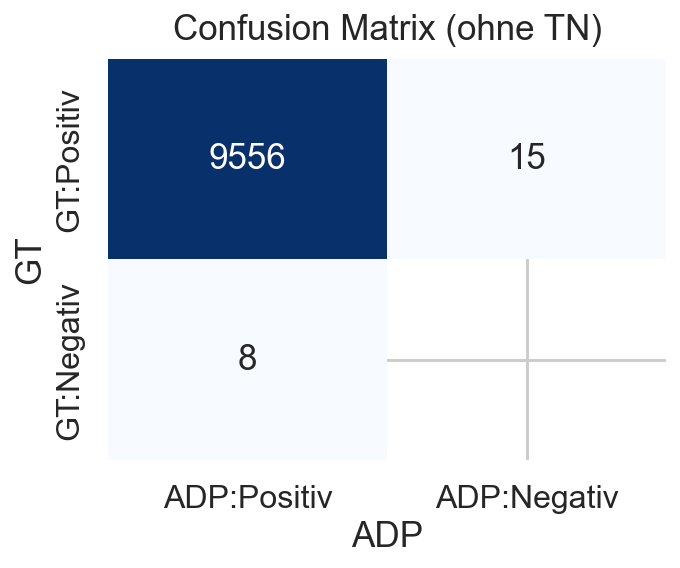

In [184]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

# Falls TP_sig / FN_sig / FP_sig noch nicht vorhanden sind, hier berechnen
try:
    TP_sig, FN_sig, FP_sig
except NameError:
    # Pfade anpassen falls nötig:
    SP_SUPERSCORE = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
    AP_SUPERSCORE = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")
    ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

    def load_csv(p): 
        try: return pd.read_csv(p)
        except: return pd.DataFrame()

    def cast_ids(df):
        for c in [*ID_ORDER, "ID"]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        return df

    def make_sig(df, cols):
        return df.apply(lambda r: "|".join(str(int(r[c])) if pd.notna(r.get(c, np.nan)) else "NA" for c in cols), axis=1)

    gt  = cast_ids(load_csv(SP_SUPERSCORE))
    adp = cast_ids(load_csv(AP_SUPERSCORE))
    common_ids = [c for c in ID_ORDER if c in gt.columns and c in adp.columns]

    gt["__sig__"]  = make_sig(gt,  common_ids)
    adp["__sig__"] = make_sig(adp, common_ids)

    gt_sig, adp_sig = set(gt["__sig__"].dropna()), set(adp["__sig__"].dropna())
    TP_sig  = sorted(gt_sig & adp_sig)
    FN_sig  = sorted(gt_sig - adp_sig)
    FP_sig  = sorted(adp_sig - gt_sig)

# Kennzahlen
TP, FN, FP = len(TP_sig), len(FN_sig), len(FP_sig)
union      = TP + FN + FP
gt_total   = TP + FN
adp_total  = TP + FP

precision  = TP / (TP + FP) if (TP + FP) else np.nan
recall     = TP / (TP + FN) if (TP + FN) else np.nan
f1         = (2*precision*recall)/(precision+recall) if (precision and recall) else np.nan
jaccard    = TP / union if union else np.nan

# Saubere Übersichtstabelle (ohne TN)
summary = pd.DataFrame([{
    "TP": TP, "FN": FN, "FP": FP,
    "GT_total": gt_total, "ADP_total": adp_total, "Union": union,
    "Precision": precision, "Recall": recall, "F1": f1, "Jaccard": jaccard
}])

display(summary.style.format({
    "Precision":"{:.4f}", "Recall":"{:.4f}", "F1":"{:.4f}", "Jaccard":"{:.4f}"
}))

# TN-freie Confusion-Heatmap (unten rechts ausgeblendet)
cm = pd.DataFrame([[TP, FN],[FP, np.nan]],
                  index=["GT:Positiv","GT:Negativ"], columns=["ADP:Positiv","ADP:Negativ"])
mask = cm.isna()

plt.figure(figsize=(5.2,4.4))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", cbar=False, mask=mask)
plt.title("Confusion Matrix (ohne TN)")
plt.xlabel("ADP"); plt.ylabel("GT")
plt.tight_layout(); plt.show()

In [202]:
import pandas as pd, numpy as np, re, ast
from pathlib import Path

# Falls gt/adp/__sig__/FN_rows/FP_rows noch nicht vorhanden, hier herstellen
try:
    gt, adp, FN_rows, FP_rows, common_ids
except NameError:
    SP_SUPERSCORE = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
    AP_SUPERSCORE = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")
    ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]
    def load_csv(p): 
        try: return pd.read_csv(p)
        except: return pd.DataFrame()
    def cast_ids(df):
        for c in [*ID_ORDER, "ID"]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        return df
    def make_sig(df, cols):
        return df.apply(lambda r: "|".join(str(int(r[c])) if pd.notna(r.get(c, np.nan)) else "NA" for c in cols), axis=1)

    gt  = cast_ids(load_csv(SP_SUPERSCORE))
    adp = cast_ids(load_csv(AP_SUPERSCORE))
    common_ids = [c for c in ID_ORDER if c in gt.columns and c in adp.columns]
    gt["__sig__"]  = make_sig(gt,  common_ids)
    adp["__sig__"] = make_sig(adp, common_ids)
    gt_sig, adp_sig = set(gt["__sig__"].dropna()), set(adp["__sig__"].dropna())
    FN_sig = sorted(gt_sig - adp_sig)
    FP_sig = sorted(adp_sig - gt_sig)
    def pick_cols(df): 
        base = ["__sig__","title","release_year","genres"]
        ids  = [c for c in common_ids if c in df.columns]
        return df[[c for c in (ids+base) if c in df.columns]]
    FN_rows = pick_cols(gt[gt["__sig__"].isin(FN_sig)]).reset_index(drop=True)
    FP_rows = pick_cols(adp[adp["__sig__"].isin(FP_sig)]).reset_index(drop=True)

# Helper
def norm_title(s): return re.sub(r"\s+"," ", str(s).strip().lower())
def as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list): return v
        except Exception:
            if "|" in x: return [t.strip() for t in x.split("|")]
    return []
def eq_set(a,b):
    A,B = set(as_list(a)), set(as_list(b))
    return (not A and not B) or (A==B)
def eq_num(s,a,tol=0.1):
    s = pd.to_numeric(s, errors="coerce"); a = pd.to_numeric(a, errors="coerce")
    return (s.isna() & a.isna()) | (s.sub(a).abs().le(tol))

# Indexe: pro ID-Quelle → ADP-/GT-Indexmengen
adp_by_id = {c: {} for c in common_ids}
gt_by_id  = {c: {} for c in common_ids}
for c in common_ids:
    if c in adp.columns:
        for idx, val in adp[[c]].dropna().itertuples():
            adp_by_id[c].setdefault(int(val), []).append(idx)
    if c in gt.columns:
        for idx, val in gt[[c]].dropna().itertuples():
            gt_by_id[c].setdefault(int(val), []).append(idx)

def best_candidates(row, other_df, other_index_by_id):
    cand_idx = set()
    for c in common_ids:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand_idx.update(other_index_by_id[c].get(int(v), []))
    return other_df.loc[sorted(cand_idx)].copy() if cand_idx else other_df.iloc[0:0].copy()

def diff_record(from_row, to_row, role_from="GT", role_to="ADP"):
    # Basis
    rec = {
        "sig_from": from_row["__sig__"], "sig_to": to_row["__sig__"],
        "title_from": from_row.get("title", np.nan), "title_to": to_row.get("title", np.nan),
        "year_from": from_row.get("release_year", np.nan), "year_to": to_row.get("release_year", np.nan),
        "genres_from": from_row.get("genres", np.nan), "genres_to": to_row.get("genres", np.nan),
    }
    # ID-Quellen: shared/missing
    shared, miss_from, miss_to = [], [], []
    for c in common_ids:
        fv, tv = from_row.get(c, pd.NA), to_row.get(c, pd.NA)
        if pd.notna(fv) and pd.notna(tv) and int(fv)==int(tv): shared.append(c)
        elif pd.notna(fv) and (pd.isna(tv) or (pd.notna(tv) and int(fv)!=int(tv))): miss_to.append(c)
        elif pd.notna(tv) and (pd.isna(fv)): miss_from.append(c)
    rec["ids_shared"] = ",".join(shared)
    rec[f"ids_missing_in_{role_to.lower()}"]  = ",".join(miss_to)
    rec[f"ids_missing_in_{role_from.lower()}"] = ",".join(miss_from)

    # Feld-Flags
    rec["diff_title"]  = norm_title(rec["title_from"]) != norm_title(rec["title_to"])
    rec["diff_year"]   = pd.to_numeric(rec["year_from"], errors="coerce") != pd.to_numeric(rec["year_to"], errors="coerce")
    rec["diff_genres"] = not eq_set(rec["genres_from"], rec["genres_to"])

    # Ratings (gemeinsame Spalten)
    rating_cols_from = [c for c in from_row.index if str(c).startswith("rating_")]
    rating_cols_to   = [c for c in to_row.index   if str(c).startswith("rating_")]
    for base in sorted(set(rating_cols_from) & set(rating_cols_to)):
        ok = bool(eq_num(from_row[base], to_row[base], 0.1))
        rec[f"diff_{base}(±0.1)"] = (not ok)
    return rec

# FN-Drilldown: GT-only gegen ADP-Kandidaten (min. eine ID-Quelle gleich)
fn_diffs = []
for _, r in FN_rows.iterrows():
    cands = best_candidates(r, adp, adp_by_id)
    if cands.empty:
        fn_diffs.append({
            "sig_from": r["__sig__"], "sig_to": np.nan,
            "reason": "no_id_overlap_in_ADP"
        })
    else:
        for _, cand in cands.iterrows():
            rec = diff_record(r, cand, role_from="GT", role_to="ADP")
            rec["reason"] = "partial_overlap" if rec["ids_shared"] else "no_exact_id_match"
            fn_diffs.append(rec)
FN_drill = pd.DataFrame(fn_diffs)

# FP-Drilldown: ADP-only gegen GT-Kandidaten
fp_diffs = []
for _, r in FP_rows.iterrows():
    cands = best_candidates(r, gt, gt_by_id)
    if cands.empty:
        fp_diffs.append({
            "sig_from": r["__sig__"], "sig_to": np.nan,
            "reason": "no_id_overlap_in_GT"
        })
    else:
        for _, cand in cands.iterrows():
            rec = diff_record(r, cand, role_from="ADP", role_to="GT")
            rec["reason"] = "partial_overlap" if rec["ids_shared"] else "no_exact_id_match"
            fp_diffs.append(rec)
FP_drill = pd.DataFrame(fp_diffs)

print("FN-Drilldown – Beispiele:")
display(FN_drill.head(20))

print("FP-Drilldown – Beispiele:")
display(FP_drill.head(20))

# Kurze Zusammenfassung, was am häufigsten “schuld” ist
def summarize_diffs(df, label):
    if df.empty:
        print(f"\n{label}: keine Kandidaten.")
        return
    base_flags = [c for c in df.columns if c.startswith("diff_")]
    agg = pd.Series({
        "pairs": len(df),
        "any_field_diff%": 100*((df[base_flags].any(axis=1)).mean() if base_flags else 0),
        "title_diff%": 100*df.get("diff_title", pd.Series(False)).mean(),
        "year_diff%":  100*df.get("diff_year", pd.Series(False)).mean(),
        "genres_diff%":100*df.get("diff_genres", pd.Series(False)).mean(),
    }).round(2)
    print(f"\n{label} – Feldunterschiede (% auf Paarbasis):")
    display(agg.to_frame("value"))
    if base_flags:
        per_flag = (100*df[base_flags].mean()).round(2).sort_values(ascending=False)
        print(f"{label} – Rating-Flags (%):")
        display(per_flag[per_flag>0])

summarize_diffs(FN_drill, "FN-Drilldown")
summarize_diffs(FP_drill, "FP-Drilldown")

FN-Drilldown – Beispiele:


,sig_from,sig_to,title_from,title_to,year_from,year_to,genres_from,genres_to,ids_shared,ids_missing_in_adp,ids_missing_in_gt,diff_title,diff_year,diff_genres,reason
0,2681|8514|1705|3020,2681|NA|1705|3020,automata,autmata,2014.0000,2014.0000,"['Action', 'Drama', 'Sci-Fi']","['Action', 'Drama', 'Sci-Fi']","ID_IMDB,ID_METACRITIC,ID_RT",ID_MOVIELENS,,True,False,False,partial_overlap
1,1886|7060|7336|4104,NA|NA|7336|4104,bruno,bruno,2009.0000,2009.0000,['Comedy'],['Comedy'],"ID_METACRITIC,ID_RT","ID_IMDB,ID_MOVIELENS",,False,False,False,partial_overlap
2,1639|6333|7769|5368,1639|NA|7769|NA,deja vu,deja vu,2006.0000,2006.0000,"['Action', 'Crime', 'Sci-Fi']","['Action', 'Crime', 'Sci-Fi']","ID_IMDB,ID_METACRITIC","ID_MOVIELENS,ID_RT",,False,False,False,partial_overlap
3,2568|NA|4583|9412,2568|NA|NA|9412,les miserables,les misrables,2012.0000,2012.0000,"['Drama', 'Musical', 'Romance']","['Drama', 'Musical', 'Romance']","ID_IMDB,ID_RT",ID_METACRITIC,,True,False,False,partial_overlap
4,NA|4253|1606|8486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_id_overlap_in_ADP
5,1037|NA|2350|17577,1037|NA|2350|NA,y tu mama tambien,y tu mam tambin,2001.0000,2001.0000,['Drama'],['Drama'],"ID_IMDB,ID_METACRITIC",ID_RT,,True,False,False,partial_overlap
6,NA|2977|1839|1328,NA|2977|1839|NA,malena,malna,2000.0000,2000.0000,"['Drama', 'Comedy', 'Romance', 'War']","['Drama', 'Comedy', 'Romance', 'War']","ID_MOVIELENS,ID_METACRITIC",ID_RT,,True,False,False,partial_overlap
7,NA|3779|4265|12290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_id_overlap_in_ADP
8,NA|7503|4201|NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_id_overlap_in_ADP
9,NA|7282|8746|NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_id_overlap_in_ADP


FP-Drilldown – Beispiele:


,sig_from,sig_to,reason,title_from,title_to,year_from,year_to,genres_from,genres_to,ids_shared,ids_missing_in_gt,ids_missing_in_adp,diff_title,diff_year,diff_genres
0,NA|950|NA|2041,NaN,no_id_overlap_in_GT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2681|NA|1705|3020,2681|8514|1705|3020,partial_overlap,autmata,automata,2014.0000,2014.0000,"['Action', 'Drama', 'Sci-Fi']","['Action', 'Drama', 'Sci-Fi']","ID_IMDB,ID_METACRITIC,ID_RT",,ID_MOVIELENS,True,False,False
2,NA|NA|7336|4104,1886|7060|7336|4104,partial_overlap,bruno,bruno,2009.0000,2009.0000,['Comedy'],['Comedy'],"ID_METACRITIC,ID_RT",,"ID_IMDB,ID_MOVIELENS",False,False,False
3,1639|NA|7769|NA,1639|6333|7769|5368,partial_overlap,deja vu,deja vu,2006.0000,2006.0000,"['Action', 'Crime', 'Sci-Fi']","['Action', 'Crime', 'Sci-Fi']","ID_IMDB,ID_METACRITIC",,"ID_MOVIELENS,ID_RT",False,False,False
4,2568|NA|NA|9412,2568|NA|4583|9412,partial_overlap,les misrables,les miserables,2012.0000,2012.0000,"['Drama', 'Musical', 'Romance']","['Drama', 'Musical', 'Romance']","ID_IMDB,ID_RT",,ID_METACRITIC,True,False,False
5,NA|2977|1839|NA,NA|2977|1839|1328,partial_overlap,malna,malena,2000.0000,2000.0000,"['Drama', 'Comedy', 'Romance', 'War']","['Drama', 'Comedy', 'Romance', 'War']","ID_MOVIELENS,ID_METACRITIC",,ID_RT,True,False,False
6,NA|5508|NA|17188,NaN,no_id_overlap_in_GT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1037|NA|2350|NA,1037|NA|2350|17577,partial_overlap,y tu mam tambin,y tu mama tambien,2001.0000,2001.0000,['Drama'],['Drama'],"ID_IMDB,ID_METACRITIC",,ID_RT,True,False,False



FN-Drilldown – Feldunterschiede (% auf Paarbasis):


,value
pairs,15.0000
any_field_diff%,26.6700
title_diff%,66.6700
year_diff%,0.0000
genres_diff%,0.0000


TypeError: Expected numeric dtype, got object instead.

In [206]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

p_st = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_ad = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"
out_dir = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); out_dir.mkdir(parents=True, exist_ok=True)

def coerce_ids_to_int64(df):
    for c in [c for c in df.columns if str(c).startswith("ID_")]:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def make_sig(df, id_cols):
    def _rowsig(r):
        parts = []
        for c in id_cols:
            v = r[c]
            if pd.notna(v):
                parts.append(f"{c}={int(v)}")
        parts.sort()
        return "|".join(parts)
    sig = df.apply(_rowsig, axis=1)
    return sig

st = coerce_ids_to_int64(pd.read_csv(p_st))
ad = coerce_ids_to_int64(pd.read_csv(p_ad))

id_cols_union = sorted(set([c for c in st.columns if c.startswith("ID_")] + [c for c in ad.columns if c.startswith("ID_")]))

# Nur Zeilen mit mindestens 1 ID berücksichtigen
st["__sig__"] = make_sig(st.reindex(columns=id_cols_union, fill_value=pd.NA).fillna(pd.NA), id_cols_union)
ad["__sig__"] = make_sig(ad.reindex(columns=id_cols_union, fill_value=pd.NA).fillna(pd.NA), id_cols_union)
st_nonempty = st[st["__sig__"] != ""].copy()
ad_nonempty = ad[ad["__sig__"] != ""].copy()

st_set, ad_set = set(st_nonempty["__sig__"]), set(ad_nonempty["__sig__"])
only_ad = sorted(ad_set - st_set)
only_st = sorted(st_set - ad_set)

print("Nur adaptiv (per ID):", len(only_ad))
print("Nur statisch (per ID):", len(only_st))

# Export + kurze Ansicht
cols_base = ["title","release_year"]
cols_ids_st = [c for c in id_cols_union if c in st.columns]
cols_ids_ad = [c for c in id_cols_union if c in ad.columns]

fp = ad_nonempty[ad_nonempty["__sig__"].isin(only_ad)][["__sig__", *cols_base, *cols_ids_ad]].copy()
fn = st_nonempty[st_nonempty["__sig__"].isin(only_st)][["__sig__", *cols_base, *cols_ids_st]].copy()

fp_path = out_dir / "diff_by_id_only_adaptive.csv"
fn_path = out_dir / "diff_by_id_only_static.csv"
fp.to_csv(fp_path, index=False)
fn.to_csv(fn_path, index=False)

print("FP Beispiele (nur adaptiv, ID-basiert):")
print(fp.head(10))
print("FN Beispiele (nur statisch, ID-basiert):")
print(fn.head(10))

Nur adaptiv (per ID): 123
Nur statisch (per ID): 117
FP Beispiele (nur adaptiv, ID-basiert):
                                               __sig__                                         title  release_year  ID_IMDB  ID_METACRITIC  ID_MOVIELENS  \
26   ID_IMDB=2375|ID_METACRITIC=7010|ID_MOVIELENS=7...                                  13 assassins          2010     2375           7010          7562   
88   ID_IMDB=1548|ID_METACRITIC=5048|ID_MOVIELENS=5...                                        3 iron          2004     1548           5048          5724   
116                     ID_IMDB=1944|ID_MOVIELENS=6915                      5 centimeters per second          2007     1944           <NA>          6915   
240                             ID_IMDB=207|ID_RT=2180  a nightmare on elm street 2 freddy s revenge          1985      207           <NA>          <NA>   
253         ID_IMDB=2215|ID_METACRITIC=7364|ID_RT=1796                                     a prophet          2009     2215    

In [207]:
import pandas as pd, numpy as np, re, ast
from pathlib import Path

# Pfade
SP_WIDE  = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv")
AP_WIDE  = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies.csv")
SP_FINAL = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
AP_FINAL = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")
OUT_DIR  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT_DIR.mkdir(parents=True, exist_ok=True)

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

# Loader
def load_csv(p):
    try: return pd.read_csv(p)
    except: return pd.DataFrame()

# IDs sauber casten
def cast_ids(df):
    for c in ID_ORDER:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

# leichte Titel‑Norm für Key-Fallback
def norm_title(t):
    if not isinstance(t,str): return ""
    t = re.sub(r"\s*\(\d{4}\)\s*$","",t.lower())
    t = re.sub(r"\s*\([^)]*\)\s*$","",t)
    t = re.sub(r"[^\w\s]"," ",t)
    t = re.sub(r"\s+"," ",t).strip()
    return t

# ±1‑Jahr‑Clustering (für Wide‑Key)
def cluster_years(series):
    ys = [int(y) for y in pd.to_numeric(series, errors="coerce").dropna()]
    clusters, mapping = [], {}
    for y in sorted(ys):
        placed=False
        for cid, members in enumerate(clusters):
            if any(abs(y-m)<=1 for m in members):
                members.append(y); mapping[y]=cid; placed=True; break
        if not placed:
            clusters.append([y]); mapping[y]=len(clusters)-1
    next_id = (max(mapping.values())+1) if mapping else 0
    return pd.to_numeric(series, errors="coerce").map(mapping).fillna(next_id).astype(int)

# Norm + Cluster für Wide sicherstellen
def ensure_norm_and_cluster(df):
    df = df.copy()
    if "norm_title" not in df.columns and "title" in df.columns:
        df["norm_title"] = df["title"].astype(str).map(norm_title)
    if "release_year" in df.columns and "year_cluster" not in df.columns:
        df["year_cluster"] = df.groupby("norm_title", group_keys=False)["release_year"].apply(cluster_years)
    return df

# Key nur für Wide
def make_key(df):
    cols = set(df.columns)
    if {"norm_title","year_cluster"}.issubset(cols):
        return df["norm_title"] + "||" + df["year_cluster"].astype(str)
    if {"title","release_year"}.issubset(cols):
        return df["title"].map(norm_title) + "||" + pd.to_numeric(df["release_year"], errors="coerce").astype("Int64").astype(str)
    if {"title","year"}.issubset(cols):
        return df["title"].map(norm_title) + "||" + pd.to_numeric(df["year"], errors="coerce").astype("Int64").astype(str)
    # Wide ohne Key‑Spalten? Dann Index als Fallback (nur zur Diagnose)
    return pd.Series(df.index.astype(str), index=df.index)

# Reihenfolge‑invariante ID‑Signatur für Final
def make_sig_canonical(df, cols):
    def _sig(r):
        parts=[]
        for c in cols:
            v = r.get(c, pd.NA)
            if pd.notna(v): parts.append(f"{c}={int(v)}")
        return "|".join(sorted(parts))
    return df.apply(_sig, axis=1)

# Zähle Ratings dynamisch
def add_count(df):
    if "count_ratings" in df.columns: return df.assign(__cnt__=df["count_ratings"])
    if "num_available_ratings" in df.columns: return df.assign(__cnt__=df["num_available_ratings"])
    rcols = [c for c in df.columns if c.startswith("rating_")]
    return df.assign(__cnt__=df[rcols].notna().sum(axis=1))

# Kandidaten‑Indizes (pro Quelle + globaler Wert)
def build_index_maps(df, id_cols):
    by_id, by_val = {c:{} for c in id_cols}, {}
    for c in id_cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").dropna().astype("Int64")
            for idx, val in s.items():
                v = int(val)
                by_id[c].setdefault(v, []).append(idx)
                by_val.setdefault(v, []).append(idx)
    return by_id, by_val

def best_candidates(row, other_df, other_by_id, other_by_val, id_cols):
    cand_idx = set()
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand_idx.update(other_by_id.get(c, {}).get(int(v), []))
    if not cand_idx:
        for c in id_cols:
            v = row.get(c, pd.NA)
            if pd.notna(v):
                cand_idx.update(other_by_val.get(int(v), []))
    return other_df.loc[sorted(cand_idx)].copy() if cand_idx else other_df.iloc[0:0].copy()

# Vergleichs‑Hilfen
def as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list): return v
        except Exception:
            if "|" in x: return [t.strip() for t in x.split("|")]
    return []
def eq_set(a,b):
    A,B = set(as_list(a)), set(as_list(b))
    return (not A and not B) or (A==B)
def eq_num(s,a,tol=0.1):
    s = pd.to_numeric(s, errors="coerce"); a = pd.to_numeric(a, errors="coerce")
    return (s.isna() & a.isna()) | (s.sub(a).abs().le(tol))

def diff_record(from_row, to_row, id_cols, role_from="GT", role_to="ADP"):
    rec = {
        "sig_from": from_row.get("__sig__", np.nan), "sig_to": to_row.get("__sig__", np.nan),
        "title_from": from_row.get("title", np.nan), "title_to": to_row.get("title", np.nan),
        "year_from": from_row.get("release_year", np.nan), "year_to": to_row.get("release_year", np.nan),
        "genres_from": from_row.get("genres", np.nan), "genres_to": to_row.get("genres", np.nan),
    }
    shared, miss_from, miss_to = [], [], []
    for c in id_cols:
        fv, tv = from_row.get(c, pd.NA), to_row.get(c, pd.NA)
        if pd.notna(fv) and pd.notna(tv) and int(fv)==int(tv): shared.append(c)
        elif pd.notna(fv) and (pd.isna(tv) or (pd.notna(tv) and int(fv)!=int(tv))): miss_to.append(c)
        elif pd.notna(tv) and pd.isna(fv): miss_from.append(c)
    rec["ids_shared"] = ",".join(shared)
    rec[f"ids_missing_in_{role_to.lower()}"]  = ",".join(miss_to)
    rec[f"ids_missing_in_{role_from.lower()}"] = ",".join(miss_from)
    rec["diff_title"]  = norm_title(rec["title_from"]) != norm_title(rec["title_to"])
    rec["diff_year"]   = pd.to_numeric(rec["year_from"], errors="coerce") != pd.to_numeric(rec["year_to"], errors="coerce")
    rec["diff_genres"] = not eq_set(rec["genres_from"], rec["genres_to"])
    rating_cols_from = [c for c in from_row.index if str(c).startswith("rating_")]
    rating_cols_to   = [c for c in to_row.index   if str(c).startswith("rating_")]
    for base in sorted(set(rating_cols_from) & set(rating_cols_to)):
        ok = bool(eq_num(from_row[base], to_row[base], 0.1))
        rec[f"diff_{base}(±0.1)"] = (not ok)
    return rec

def summarize_diffs(df, label):
    print(f"\n{label}: {len(df)} Paare")
    if df.empty: return
    base_flags = [c for c in df.columns if c.startswith("diff_")]
    for c in base_flags + ["diff_title","diff_year","diff_genres"]:
        if c in df.columns:
            df[c] = df[c].astype("boolean").astype("float64")
    agg = pd.Series({
        "pairs": len(df),
        "any_field_diff%": 100*((df[base_flags].any(axis=1)).mean() if base_flags else 0.0),
        "title_diff%": 100*df.get("diff_title", pd.Series(0.0)).mean(),
        "year_diff%":  100*df.get("diff_year", pd.Series(0.0)).mean(),
        "genres_diff%":100*df.get("diff_genres", pd.Series(0.0)).mean(),
    }).round(2)
    display(agg.to_frame("value"))
    if base_flags:
        per_flag = (100*df[base_flags].mean()).round(2).sort_values(ascending=False)
        print(f"{label} – Rating-Flags (%):")
        display(per_flag[per_flag>0])

# Laden
st_w, ad_w = load_csv(SP_WIDE), load_csv(AP_WIDE)
st_f, ad_f = cast_ids(load_csv(SP_FINAL)), cast_ids(load_csv(AP_FINAL))

# Keys nur für Wide
st_w = ensure_norm_and_cluster(st_w); ad_w = ensure_norm_and_cluster(ad_w)
st_w["__key__"] = make_key(st_w);     ad_w["__key__"] = make_key(ad_w)

# Final: kanonische ID‑Signatur + dynamische Counts
common_ids = [c for c in ID_ORDER if c in st_f.columns and c in ad_f.columns]
st_f["__sig__"] = make_sig_canonical(st_f, common_ids)
ad_f["__sig__"] = make_sig_canonical(ad_f, common_ids)
st_f = add_count(st_f); ad_f = add_count(ad_f)

# FN/FP per Signatur
st_set, ad_set = set(st_f["__sig__"]) - {""}, set(ad_f["__sig__"]) - {""}
FN_sig = sorted(st_set - ad_set)  # GT-only
FP_sig = sorted(ad_set - st_set)  # ADP-only

FN_rows = st_f[st_f["__sig__"].isin(FN_sig)][["__sig__","title","release_year","__cnt__",*common_ids]].reset_index(drop=True)
FP_rows = ad_f[ad_f["__sig__"].isin(FP_sig)][["__sig__","title","release_year","__cnt__",*common_ids]].reset_index(drop=True)

FN_rows.to_csv(OUT_DIR/"final_gt_only_by_id.csv", index=False)
FP_rows.to_csv(OUT_DIR/"final_adp_only_by_id.csv", index=False)

print(f"GT-only (FN): {len(FN_rows)} | ADP-only (FP): {len(FP_rows)}")
print("FN Beispiele:"); print(FN_rows.head(10))
print("FP Beispiele:"); print(FP_rows.head(10))

# Kandidaten‑Suche + Drilldowns
adp_by_id, adp_by_val = build_index_maps(ad_f, common_ids)
gt_by_id,  gt_by_val  = build_index_maps(st_f, common_ids)

fn_diffs, fp_diffs = [], []

for _, r in FN_rows.iterrows():  # GT-only
    cands = best_candidates(r, ad_f, adp_by_id, adp_by_val, common_ids)
    if cands.empty:
        fn_diffs.append({"sig_from": r["__sig__"], "sig_to": np.nan, "reason": "no_id_overlap_in_ADP"})
    else:
        for _, cand in cands.iterrows():
            rec = diff_record(r, cand, common_ids, role_from="GT", role_to="ADP")
            rec["reason"] = "partial_overlap" if rec["ids_shared"] else "no_exact_id_match"
            fn_diffs.append(rec)

for _, r in FP_rows.iterrows():  # ADP-only
    cands = best_candidates(r, st_f, gt_by_id, gt_by_val, common_ids)
    if cands.empty:
        fp_diffs.append({"sig_from": r["__sig__"], "sig_to": np.nan, "reason": "no_id_overlap_in_GT"})
    else:
        for _, cand in cands.iterrows():
            rec = diff_record(r, cand, common_ids, role_from="ADP", role_to="GT")
            rec["reason"] = "partial_overlap" if rec["ids_shared"] else "no_exact_id_match"
            fp_diffs.append(rec)

FN_drill = pd.DataFrame(fn_diffs); FP_drill = pd.DataFrame(fp_diffs)
FN_drill.to_csv(OUT_DIR/"final_gt_only_drilldown.csv", index=False)
FP_drill.to_csv(OUT_DIR/"final_adp_only_drilldown.csv", index=False)

summarize_diffs(FN_drill, "FN-Drilldown")
summarize_diffs(FP_drill, "FP-Drilldown")

# Metriken (ID‑Signatur‑Basis)
TP = len(st_set & ad_set); FN = len(FN_sig); FP = len(FP_sig)
precision = TP / (TP+FP) if TP+FP>0 else 0
recall    = TP / (TP+FN) if TP+FN>0 else 0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0
jaccard   = TP / (TP+FP+FN) if TP+FP+FN>0 else 0
print(f"\nTP={TP}  FN={FN}  FP={FP} | Precision={precision:.4f} Recall={recall:.4f} F1={f1:.4f} Jaccard={jaccard:.4f}")
print(f"Outputs gespeichert unter: {OUT_DIR}")

KeyError: "['title', 'release_year'] not in index"

In [210]:
import pandas as pd

P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"

def load(p):
    try:
        return pd.read_csv(p, low_memory=False)
    except Exception as e:
        print("Fehler beim Laden:", p, e)
        return pd.DataFrame()

gt = load(P_GT)
ad = load(P_AD)

def id_cols(df):
    return [c for c in df.columns if str(c).upper().startswith("ID_")]

ids_gt = id_cols(gt)
ids_ad = id_cols(ad)

print("GT ID-Spalten:", ids_gt)
print("ADP ID-Spalten:", ids_ad)

common = [c for c in ids_gt if c in ids_ad]
print("Gemeinsame ID-Spalten:", common)
print("Nur in GT:", sorted(set(ids_gt) - set(ids_ad)))
print("Nur in ADP:", sorted(set(ids_ad) - set(ids_gt)))

def stats(df, cols, label):
    print(f"\n{label} – ID-Stats (Spalte, dtype, non-null):")
    for c in cols:
        if c in df.columns:
            print((c, str(df[c].dtype), int(df[c].notna().sum())))
        else:
            print((c, "-", 0))

union_ids = sorted(set(ids_gt) | set(ids_ad))
stats(gt, union_ids, "GT")
stats(ad, union_ids, "ADP")

GT ID-Spalten: ['ID_IMDB', 'ID_METACRITIC', 'ID_MOVIELENS', 'ID_RT']
ADP ID-Spalten: ['ID_IMDB', 'ID_RT', 'ID_METACRITIC', 'ID_MOVIELENS']
Gemeinsame ID-Spalten: ['ID_IMDB', 'ID_METACRITIC', 'ID_MOVIELENS', 'ID_RT']
Nur in GT: []
Nur in ADP: []

GT – ID-Stats (Spalte, dtype, non-null):
('ID_IMDB', 'float64', 3012)
('ID_METACRITIC', 'float64', 7848)
('ID_MOVIELENS', 'float64', 5839)
('ID_RT', 'float64', 9542)

ADP – ID-Stats (Spalte, dtype, non-null):
('ID_IMDB', 'float64', 3094)
('ID_METACRITIC', 'float64', 7844)
('ID_MOVIELENS', 'float64', 5845)
('ID_RT', 'float64', 9545)


In [211]:
import pandas as pd
import numpy as np
from pathlib import Path

# Eingaben
P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load(p):
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, id_cols):
    for c in id_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:
            df[c] = pd.NA
    return df

def keep_rows_with_any_id(df, id_cols):
    mask = pd.Series(False, index=df.index)
    for c in id_cols: mask |= df[c].notna()
    return df[mask].copy()

# 1) Laden und ID-Spalten bestimmen
gt_raw = load(P_GT)
ad_raw = load(P_AD)

id_cols = [c for c in ID_ORDER if c in gt_raw.columns and c in ad_raw.columns]
if not id_cols: raise RuntimeError("Keine gemeinsamen ID_* Spalten gefunden.")

gt = keep_rows_with_any_id(cast_ids(gt_raw.copy(), id_cols), id_cols)
ad = keep_rows_with_any_id(cast_ids(ad_raw.copy(), id_cols), id_cols)

# 2) Coverage Rate (auf Basis ID‑Signaturen, reihenfolge-fest: exakt ID_ORDER)
def make_ordered_sig(df, id_cols):
    def _sig(r):
        vals=[]
        for c in id_cols:
            v = r.get(c, pd.NA)
            vals.append("NA" if pd.isna(v) else str(int(v)))
        return "|".join(vals)
    return df.apply(_sig, axis=1)

gt["__sig_ordered__"] = make_ordered_sig(gt, id_cols)
ad["__sig_ordered__"] = make_ordered_sig(ad, id_cols)

nGT = len(set(gt["__sig_ordered__"]) - {""})
nAD = len(set(ad["__sig_ordered__"]) - {""})
coverage = 100.0 * (nAD / nGT) if nGT else 0.0
print("Gemeinsame ID-Spalten:", id_cols)
print(f"Coverage Rate: nADP={nAD} / nGT={nGT} = {coverage:.2f}%")

# 3) Index-Maps je Quelle im ADP (schnelles Kandidatenfinden)
ad_index_by_col = {c: {} for c in id_cols}
for c in id_cols:
    s = ad[c].dropna().astype(int)
    for idx, v in s.items():
        ad_index_by_col[c].setdefault(v, set()).add(idx)

# 4) 1:1‑Matching (GT-Zeilen werden per Schnittmenge aller vorhandenen IDs gematcht)
matched_gt, matched_ad = set(), set()
for i, row in gt.iterrows():
    # Alle vorhandenen ID‑Spalten dieser GT‑Zeile
    present = [(c, int(row[c])) for c in id_cols if pd.notna(row[c])]
    if not present:
        continue
    # Kandidaten = Schnittmenge der ADP-Indizes pro (Spalte, Wert)
    cand = None
    for c, v in present:
        s = ad_index_by_col.get(c, {}).get(v, set())
        cand = set(s) if cand is None else (cand & s)
        if not cand:
            break
    # Nimm einen bisher ungenutzten ADP‑Index, falls vorhanden
    if cand:
        pick = None
        for j in cand:
            if j not in matched_ad:
                pick = j; break
        if pick is None:
            # alle Kandidaten schon gematcht → kein zusätzlicher TP
            continue
        matched_gt.add(i)
        matched_ad.add(pick)

# 5) Konfusionsmatrix und Metriken
TP = len(matched_gt)
FN = len(gt) - TP
FP = len(ad) - len(matched_ad)

precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0

print(f"\nKonfusionszahlen (ID‑spaltengenau):")
print(f"TP={TP}  FN={FN}  FP={FP}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}")

# 6) Exporte FN/FP (zur BA‑Dokumentation)
def pick_cols(df, id_cols):
    cols = id_cols + [c for c in ["title","release_year","genres"] if c in df.columns]
    return df[cols].copy()

fn_df = pick_cols(gt.loc[sorted(set(gt.index) - matched_gt)], id_cols)
fp_df = pick_cols(ad.loc[sorted(set(ad.index) - matched_ad)], id_cols)

fn_df.to_csv(OUT/"ids_confusion_FN_strict_cols.csv", index=False)
fp_df.to_csv(OUT/"ids_confusion_FP_strict_cols.csv", index=False)
print(f"CSV gespeichert: {OUT/'ids_confusion_FN_strict_cols.csv'} | {OUT/'ids_confusion_FP_strict_cols.csv'}")

Gemeinsame ID-Spalten: ['ID_IMDB', 'ID_MOVIELENS', 'ID_METACRITIC', 'ID_RT']
Coverage Rate: nADP=9918 / nGT=9912 = 100.06%

Konfusionszahlen (ID‑spaltengenau):
TP=9882  FN=30  FP=36
Precision=0.9964  Recall=0.9970  F1=0.9967  Jaccard=0.9934
CSV gespeichert: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_strict_cols.csv | /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_strict_cols.csv


Gemeinsame ID-Spalten: ['ID_IMDB', 'ID_MOVIELENS', 'ID_METACRITIC', 'ID_RT']
Coverage Rate: nADP=9918 / nGT=9912 = 100.06%
TP=9882  FN=30  FP=36
Precision=0.9964  Recall=0.9970  F1=0.9967  Jaccard=0.9934


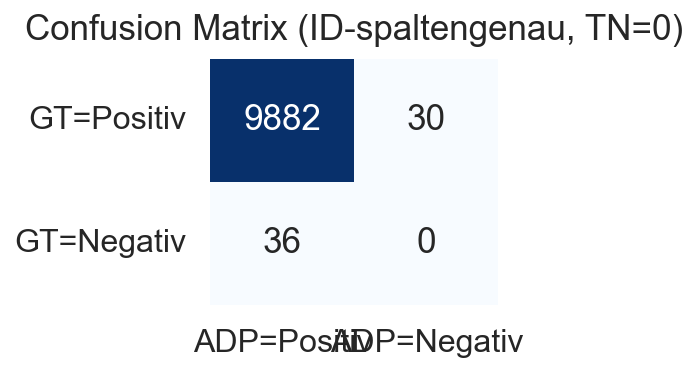


FN Beispiele (nur in GT):


,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,title,release_year,genres
422,2294,8226,8565,9358,lee daniels the butler,2013,"['Biography', 'Drama']"
976,1598,6294,3480,3890,borat cultural learnings of america for make b...,2006,['Comedy']
1132,1372,5302,1797,2503,avp alien vs predator,2004,"['Action', 'Adventure', 'Horror']"
1665,594,32,4031,1865,twelve monkeys,1995,"['Mystery', 'Sci-Fi', 'Thriller']"
1687,538,325,4206,17164,wes craven s new nightmare,1994,"['Fantasy', 'Horror', 'Mystery']"
2252,2916,8786,<NA>,8405,insurgent,2015,"['Action', 'Adventure', 'Sci-Fi']"
2475,1799,<NA>,3498,12928,scary movie 5,2013,"['Comedy', 'Horror']"
2478,2465,8059,3781,<NA>,texas chainsaw 3d,2013,"['Horror', 'Thriller']"
2835,2460,<NA>,5581,15037,the girl with dragon tattoo,2009,"['Crime', 'Drama', 'Mystery']"
2942,1766,6634,3274,<NA>,avpr aliens vs predator requiem,2007,"['Action', 'Horror', 'Sci-Fi']"



FP Beispiele (nur in ADP):


,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,title,release_year,genres
116,1944,6915,<NA>,<NA>,5 centimeters per second,2007,"['Animation', 'Drama', 'Family']"
240,207,<NA>,<NA>,2180,a nightmare on elm street 2 freddy s revenge,1985,['Horror']
439,1766,<NA>,<NA>,3035,aliens vs predator requiem,2007,"['Action', 'Horror', 'Sci-Fi']"
769,<NA>,5302,1797,2503,avp alien vs predator,2004,"['Action', 'Sci-Fi', 'Thriller', 'Horror']"
770,<NA>,6634,3274,<NA>,avpr aliens vs predator requiem,2007,"['Action', 'Sci-Fi', 'Thriller', 'Horror']"
1108,3279,<NA>,<NA>,3614,birds of prey,2020,"['Action', 'Comedy', 'Crime']"
1261,<NA>,6294,3480,3890,borat cultural learnings of america for make b...,2006,['Comedy']
1656,670,1386,<NA>,<NA>,children of heaven,1997,"['Drama', 'Family', 'Sport']"
1941,<NA>,5970,651,<NA>,crywolf,2005,"['Drama', 'Mystery', 'Thriller', 'Horror']"
2658,127,1533,<NA>,<NA>,fanny and alexander,1982,['Drama']


Beispiele gespeichert: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_examples.csv | /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_examples.csv
Vollständige FN/FP gespeichert: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_full.csv | /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_full.csv


In [212]:
# === BA-Evaluierung: ID-basierte Confusion Matrix + Beispiele (strict per column) ===
import pandas as pd, numpy as np
from pathlib import Path

# Eingaben
P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load(p): 
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, id_cols):
    for c in id_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:               df[c] = pd.NA
    return df

def keep_rows_with_any_id(df, id_cols):
    mask = pd.Series(False, index=df.index)
    for c in id_cols: mask |= df[c].notna()
    return df[mask].copy()

# 1) Laden + gemeinsame ID-Spalten
gt_raw, ad_raw = load(P_GT), load(P_AD)
id_cols = [c for c in ID_ORDER if c in gt_raw.columns and c in ad_raw.columns]
if not id_cols: raise RuntimeError("Keine gemeinsamen ID_* Spalten gefunden.")

gt = keep_rows_with_any_id(cast_ids(gt_raw.copy(), id_cols), id_cols)
ad = keep_rows_with_any_id(cast_ids(ad_raw.copy(), id_cols), id_cols)

# 2) Coverage Rate (optional, auf geordneter Signatur)
def make_ordered_sig(df, id_cols):
    def _sig(r):
        vals = [("NA" if pd.isna(r.get(c, pd.NA)) else str(int(r[c]))) for c in id_cols]
        return "|".join(vals)
    return df.apply(_sig, axis=1)

gt["__sig_ordered__"] = make_ordered_sig(gt, id_cols)
ad["__sig_ordered__"] = make_ordered_sig(ad, id_cols)
nGT = len(set(gt["__sig_ordered__"]) - {""})
nAD = len(set(ad["__sig_ordered__"]) - {""})
coverage = 100.0 * (nAD / nGT) if nGT else 0.0

# 3) Index-Maps je Quelle im ADP
ad_index_by_col = {c: {} for c in id_cols}
for c in id_cols:
    s = ad[c].dropna().astype(int)
    for idx, v in s.items():
        ad_index_by_col[c].setdefault(v, set()).add(idx)

# 4) 1:1‑Matching (alle vorhandenen GT-IDs müssen pro Spalte übereinstimmen)
matched_gt, matched_ad = set(), set()
for i, row in gt.iterrows():
    present = [(c, int(row[c])) for c in id_cols if pd.notna(row[c])]
    if not present: 
        continue
    cand = None
    for c, v in present:
        s = ad_index_by_col.get(c, {}).get(v, set())
        cand = set(s) if cand is None else (cand & s)
        if not cand: 
            break
    if cand:
        pick = next((j for j in cand if j not in matched_ad), None)
        if pick is not None:
            matched_gt.add(i); matched_ad.add(pick)

# 5) Konfusionsmatrix + Kennzahlen (TN=0 in offenem Universum)
TP = len(matched_gt)
FN = len(gt) - TP
FP = len(ad) - len(matched_ad)
precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0

print("Gemeinsame ID-Spalten:", id_cols)
print(f"Coverage Rate: nADP={nAD} / nGT={nGT} = {coverage:.2f}%")
print(f"TP={TP}  FN={FN}  FP={FP}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}")

# 6) “Schöne” Confusion-Matrix (Heatmap) – TN=0
try:
    import seaborn as sns, matplotlib.pyplot as plt
    cm_df = pd.DataFrame(
        [[TP, FN],[FP, 0]],
        index=["GT=Positiv","GT=Negativ"],
        columns=["ADP=Positiv","ADP=Negativ"]
    )
    plt.figure(figsize=(4,3))
    ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_title("Confusion Matrix (ID-spaltengenau, TN=0)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Heatmap nicht verfügbar:", e)

# 7) Beispiel-Tabellen FN/FP + Exporte
def pick_cols(df, id_cols):
    extra = [c for c in ["title","release_year","genres"] if c in df.columns]
    return df[id_cols + extra].copy()

fn_idx = sorted(set(gt.index) - matched_gt)
fp_idx = sorted(set(ad.index) - matched_ad)

fn_df = pick_cols(gt.loc[fn_idx], id_cols)
fp_df = pick_cols(ad.loc[fp_idx], id_cols)

print("\nFN Beispiele (nur in GT):")
display(fn_df.head(20))
print("\nFP Beispiele (nur in ADP):")
display(fp_df.head(20))

fn_df.to_csv(OUT/"ids_confusion_FN_examples.csv", index=False)
fp_df.to_csv(OUT/"ids_confusion_FP_examples.csv", index=False)
print(f"Beispiele gespeichert: {OUT/'ids_confusion_FN_examples.csv'} | {OUT/'ids_confusion_FP_examples.csv'}")

# 8) Vollständige Listen (optional)
gt.loc[fn_idx].to_csv(OUT/"ids_confusion_FN_full.csv", index=False)
ad.loc[fp_idx].to_csv(OUT/"ids_confusion_FP_full.csv", index=False)
print(f"Vollständige FN/FP gespeichert: {OUT/'ids_confusion_FN_full.csv'} | {OUT/'ids_confusion_FP_full.csv'}")

In [214]:
import pandas as pd
from pathlib import Path

P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load(p): 
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, cols):
    for c in cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:               df[c] = pd.NA
    return df

gt = load(P_GT); ad = load(P_AD)
id_cols = [c for c in ID_ORDER if c in gt.columns and c in ad.columns]
if not id_cols: raise RuntimeError("Keine gemeinsamen ID_* Spalten gefunden.")

gt = cast_ids(gt, id_cols); ad = cast_ids(ad, id_cols)

# EXAKTE, SPALTENGENAUE Signatur (jede Spalte, NA zählt als NA; Zusatz-ID => ungleich)
def make_strict_sig(df, id_cols):
    def _v(x): return "NA" if pd.isna(x) else str(int(x))
    return df.apply(lambda r: "|".join(f"{c}={_v(r.get(c, pd.NA))}" for c in id_cols), axis=1)

gt["__sig__"] = make_strict_sig(gt, id_cols)
ad["__sig__"] = make_strict_sig(ad, id_cols)

# Nur eindeutige Signaturen vergleichen
gt_u = gt.drop_duplicates(subset="__sig__").copy()
ad_u = ad.drop_duplicates(subset="__sig__").copy()

gt_set = set(gt_u["__sig__"]) - {""}
ad_set = set(ad_u["__sig__"]) - {""}

TP_sig = gt_set & ad_set
FN_sig = gt_set - ad_set
FP_sig = ad_set - gt_set

TP = len(TP_sig); FN = len(FN_sig); FP = len(FP_sig)
precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0

print("Gemeinsame ID-Spalten:", id_cols)
print(f"TP={TP}  FN={FN}  FP={FP}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}")

# Beispiele/Exporte
show = id_cols + [c for c in ["title","release_year","genres"] if c in gt.columns or c in ad.columns]
fn_df = gt_u[gt_u["__sig__"].isin(FN_sig)][["__sig__", *[c for c in show if c in gt_u.columns]]]
fp_df = ad_u[ad_u["__sig__"].isin(FP_sig)][["__sig__", *[c for c in show if c in ad_u.columns]]]
fn_df.to_csv(OUT/"ids_confusion_FN_exact.csv", index=False)
fp_df.to_csv(OUT/"ids_confusion_FP_exact.csv", index=False)
print(f"CSV: {OUT/'ids_confusion_FN_exact.csv'} | {OUT/'ids_confusion_FP_exact.csv'}")

Gemeinsame ID-Spalten: ['ID_IMDB', 'ID_MOVIELENS', 'ID_METACRITIC', 'ID_RT']
TP=9795  FN=117  FP=123
Precision=0.9876  Recall=0.9882  F1=0.9879  Jaccard=0.9761
CSV: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_exact.csv | /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_exact.csv


Gemeinsame ID-Spalten: ['ID_IMDB', 'ID_MOVIELENS', 'ID_METACRITIC', 'ID_RT']
Coverage Rate (strict): nADP=9918 / nGT=9912 = 100.06%
TP=9795  FN=117  FP=123
Precision=0.9876  Recall=0.9882  F1=0.9879  Jaccard=0.9761


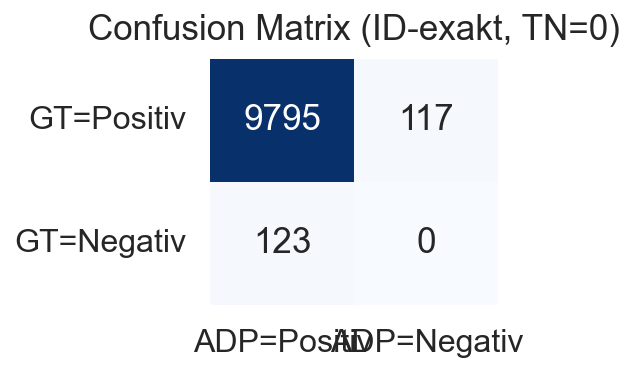


FN Beispiele (nur in GT, strikt):


,__sig__,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,title,release_year,genres
422,ID_IMDB=2294|ID_MOVIELENS=8226|ID_METACRITIC=8...,2294,8226,8565,9358,lee daniels the butler,2013,"['Biography', 'Drama']"
976,ID_IMDB=1598|ID_MOVIELENS=6294|ID_METACRITIC=3...,1598,6294,3480,3890,borat cultural learnings of america for make b...,2006,['Comedy']
1132,ID_IMDB=1372|ID_MOVIELENS=5302|ID_METACRITIC=1...,1372,5302,1797,2503,avp alien vs predator,2004,"['Action', 'Adventure', 'Horror']"
1665,ID_IMDB=594|ID_MOVIELENS=32|ID_METACRITIC=4031...,594,32,4031,1865,twelve monkeys,1995,"['Mystery', 'Sci-Fi', 'Thriller']"
1687,ID_IMDB=538|ID_MOVIELENS=325|ID_METACRITIC=420...,538,325,4206,17164,wes craven s new nightmare,1994,"['Fantasy', 'Horror', 'Mystery']"
2202,ID_IMDB=NA|ID_MOVIELENS=9416|ID_METACRITIC=490...,<NA>,9416,4904,12666,rogue one a star wars story,2016,"['Action', 'Adventure', 'Sci-Fi', 'Fantasy', '..."
2205,ID_IMDB=NA|ID_MOVIELENS=9259|ID_METACRITIC=268...,<NA>,9259,2681,14510,the angry birds movie,2016,"['Action', 'Comedy', 'Animation', 'Family']"
2208,ID_IMDB=NA|ID_MOVIELENS=9209|ID_METACRITIC=329...,<NA>,9209,3294,14664,the brothers grimsby,2016,"['Action', 'Comedy']"
2220,ID_IMDB=NA|ID_MOVIELENS=9286|ID_METACRITIC=819...,<NA>,9286,8195,15994,the wailing,2016,"['Mystery', 'Thriller', 'Fantasy', 'Horror']"
2246,ID_IMDB=NA|ID_MOVIELENS=8792|ID_METACRITIC=850...,<NA>,8792,8508,6840,furious 7,2015,"['Action', 'Adventure', 'Thriller', 'Crime']"



FP Beispiele (nur in ADP, strikt):


,__sig__,ID_IMDB,ID_MOVIELENS,ID_METACRITIC,ID_RT,title,release_year,genres
26,ID_IMDB=2375|ID_MOVIELENS=7562|ID_METACRITIC=7...,2375,7562,7010,1871,13 assassins,2010,"['Action', 'Adventure', 'Drama']"
88,ID_IMDB=1548|ID_MOVIELENS=5724|ID_METACRITIC=5...,1548,5724,5048,1981,3 iron,2004,"['Crime', 'Drama', 'Romance']"
116,ID_IMDB=1944|ID_MOVIELENS=6915|ID_METACRITIC=N...,1944,6915,<NA>,<NA>,5 centimeters per second,2007,"['Animation', 'Drama', 'Family']"
240,ID_IMDB=207|ID_MOVIELENS=NA|ID_METACRITIC=NA|I...,207,<NA>,<NA>,2180,a nightmare on elm street 2 freddy s revenge,1985,['Horror']
253,ID_IMDB=2215|ID_MOVIELENS=NA|ID_METACRITIC=736...,2215,<NA>,7364,1796,a prophet,2009,"['Crime', 'Drama']"
261,ID_IMDB=2624|ID_MOVIELENS=NA|ID_METACRITIC=660...,2624,<NA>,6604,2207,a separation,2011,['Drama']
284,ID_IMDB=2242|ID_MOVIELENS=NA|ID_METACRITIC=564...,2242,<NA>,5640,16875,a very harold kumar christmas,2011,"['Adventure', 'Comedy']"
285,ID_IMDB=1293|ID_MOVIELENS=NA|ID_METACRITIC=787...,1293,<NA>,7876,2241,a very long engagement,2004,"['Drama', 'Mystery', 'Romance']"
350,ID_IMDB=1483|ID_MOVIELENS=5981|ID_METACRITIC=N...,1483,5981,<NA>,2370,aeon flux,2005,"['Action', 'Adventure', 'Sci-Fi']"
384,ID_IMDB=15|ID_MOVIELENS=4733|ID_METACRITIC=NA|...,15,4733,<NA>,2433,aguirre the wrath of god,1972,"['Action', 'Adventure', 'Biography']"


CSV gespeichert: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_TP_exact.csv, /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_exact.csv, /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_exact.csv


In [216]:
# === Strikter ID-Vergleich (exakt spaltenbasiert) + Matrix, Metriken, Beispiele, Exporte ===
import pandas as pd, numpy as np
from pathlib import Path

# Eingaben
P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_static.csv"
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]

def load(p):
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, id_cols):
    for c in id_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:               df[c] = pd.NA
    return df

# 1) Laden + gemeinsame ID-Spalten
gt_raw, ad_raw = load(P_GT), load(P_AD)
id_cols = [c for c in ID_ORDER if c in gt_raw.columns and c in ad_raw.columns]
if not id_cols: raise RuntimeError("Keine gemeinsamen ID_* Spalten gefunden.")

gt = cast_ids(gt_raw.copy(), id_cols)
ad = cast_ids(ad_raw.copy(), id_cols)

# 2) STRIKTE Signatur (jede Spalte, NA zählt als NA; zusätzliche ADP-IDs ⇒ ungleich)
def make_strict_sig(df, id_cols):
    def _v(x): return "NA" if pd.isna(x) else str(int(x))
    return df.apply(lambda r: "|".join(f"{c}={_v(r.get(c, pd.NA))}" for c in id_cols), axis=1)

gt["__sig__"] = make_strict_sig(gt, id_cols)
ad["__sig__"] = make_strict_sig(ad, id_cols)

# Deduplizieren pro Signatur (Mengenvergleich)
gt_u = gt.drop_duplicates(subset="__sig__").copy()
ad_u = ad.drop_duplicates(subset="__sig__").copy()

gt_set = set(gt_u["__sig__"]) - {""}
ad_set = set(ad_u["__sig__"]) - {""}

# 3) Coverage (optional, formal wie zuvor – auf strikter Signaturbasis)
nGT = len(gt_set)
nAD = len(ad_set)
coverage = 100.0 * (nAD / nGT) if nGT else 0.0

# 4) Konfusionsmengen
TP_sig = gt_set & ad_set
FN_sig = gt_set - ad_set    # nur GT
FP_sig = ad_set - gt_set    # nur ADP

# 5) Kennzahlen
TP = len(TP_sig); FN = len(FN_sig); FP = len(FP_sig)
precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0

print("Gemeinsame ID-Spalten:", id_cols)
print(f"Coverage Rate (strict): nADP={nAD} / nGT={nGT} = {coverage:.2f}%")
print(f"TP={TP}  FN={FN}  FP={FP}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}")

# 6) “Schöne” Confusion-Matrix (Heatmap) – TN=0
try:
    import seaborn as sns, matplotlib.pyplot as plt
    cm_df = pd.DataFrame(
        [[TP, FN],[FP, 0]],
        index=["GT=Positiv","GT=Negativ"],
        columns=["ADP=Positiv","ADP=Negativ"]
    )
    plt.figure(figsize=(4,3))
    ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_title("Confusion Matrix (ID-exakt, TN=0)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Heatmap nicht verfügbar:", e)

# 7) Beispiel-Tabellen + Exporte
show = id_cols + [c for c in ["title","release_year","genres"] if c in gt_u.columns or c in ad_u.columns]

tp = gt_u[gt_u["__sig__"].isin(TP_sig)][["__sig__", *[c for c in show if c in gt_u.columns]]]
fn = gt_u[gt_u["__sig__"].isin(FN_sig)][["__sig__", *[c for c in show if c in gt_u.columns]]]
fp = ad_u[ad_u["__sig__"].isin(FP_sig)][["__sig__", *[c for c in show if c in ad_u.columns]]]

print("\nFN Beispiele (nur in GT, strikt):"); display(fn.head(20))
print("\nFP Beispiele (nur in ADP, strikt):"); display(fp.head(20))

tp.to_csv(OUT/"ids_confusion_TP_exact.csv", index=False)
fn.to_csv(OUT/"ids_confusion_FN_exact.csv", index=False)
fp.to_csv(OUT/"ids_confusion_FP_exact.csv", index=False)
print(f"CSV gespeichert: {OUT/'ids_confusion_TP_exact.csv'}, {OUT/'ids_confusion_FN_exact.csv'}, {OUT/'ids_confusion_FP_exact.csv'}")

Coverage (strict): nAD=9918 / nGT=9912 = 100.06%
TP=9795  FN=117  FP=123
Precision=0.9876  Recall=0.9882  F1=0.9879  Jaccard=0.9761


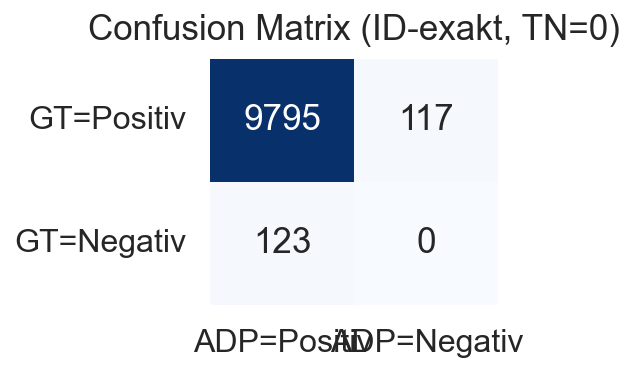


FN-Beispiele (nur in GT):
     ID_IMDB  ID_MOVIELENS  ID_METACRITIC      ID_RT                                              title  release_year  \
0  2294.0000     8226.0000      8565.0000  9358.0000                             lee daniels the butler          2013   
1  1598.0000     6294.0000      3480.0000  3890.0000  borat cultural learnings of america for make b...          2006   
2  1372.0000     5302.0000      1797.0000  2503.0000                              avp alien vs predator          2004   
3   594.0000       32.0000      4031.0000  1865.0000                                     twelve monkeys          1995   
4   538.0000      325.0000      4206.0000 17164.0000                         wes craven s new nightmare          1994   
5        NaN     9416.0000      4904.0000 12666.0000                        rogue one a star wars story          2016   
6        NaN     9259.0000      2681.0000 14510.0000                              the angry birds movie          2016   
7    

In [221]:
import pandas as pd
from pathlib import Path

# Pfade zu deinen aktuellen Dateien (strict/exakt)
P_TP = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_TP_exact.csv")
P_FN = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_exact.csv")
P_FP = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_exact.csv")

tp = pd.read_csv(P_TP)
fn = pd.read_csv(P_FN)
fp = pd.read_csv(P_FP)

TP, FN, FP = len(tp), len(fn), len(fp)
nAD, nGT = TP + FP, TP + FN
coverage = 100.0 * (nAD / nGT) if nGT else 0.0
precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0

print(f"Coverage (strict): nAD={nAD} / nGT={nGT} = {coverage:.2f}%")
print(f"TP={TP}  FN={FN}  FP={FP}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}")

# Heatmap (TN=0)
try:
    import seaborn as sns, matplotlib.pyplot as plt
    cm_df = pd.DataFrame([[TP, FN],[FP, 0]],
                         index=["GT=Positiv","GT=Negativ"],
                         columns=["ADP=Positiv","ADP=Negativ"])
    plt.figure(figsize=(4,3))
    ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_title("Confusion Matrix (ID-exakt, TN=0)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Heatmap nicht verfügbar:", e)

# Beispiele (FN/FP)
id_cols = [c for c in ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"] if c in fn.columns or c in fp.columns]
base_cols = [c for c in ["title","release_year","genres"] if c in fn.columns or c in fp.columns]

print("\nFN-Beispiele (nur in GT):")
print(fn[[*id_cols, *base_cols]].head(15))
print("\nFP-Beispiele (nur in ADP):")
print(fp[[*id_cols, *base_cols]].head(15))

# Einfache Ursachen-Übersicht (Anteil gesetzter IDs pro Quelle in FN/FP)
def id_presence_summary(df, label):
    if df.empty:
        print(f"\n{label}: keine Zeilen")
        return
    pres = {c: int(df[c].notna().sum()) for c in id_cols if c in df.columns}
    print(f"\n{label} – gesetzte IDs (count / total={len(df)}):")
    for c, k in pres.items():
        print(f"{c}: {k} ({100*k/len(df):.1f}%)")

id_presence_summary(fn, "FN")
id_presence_summary(fp, "FP")

In [222]:
# === Professionelle Feldanalyse (Side-by-Side), Ursachen-Klassifikation und 10 repräsentative Beispiele ===
import pandas as pd, numpy as np, re, ast
from pathlib import Path
try:
    from IPython.display import display
except:
    def display(x): print(x.head(20))

# Pfade
P_GT = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
P_AD = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
P_TP = "/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_TP_exact.csv"
P_FN = "/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_exact.csv"
P_FP = "/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_exact.csv"
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER     = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]
RATING_ORDER = ["rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience"]
RATING_TOL   = 0.1

# ----------------- Utils -----------------
def load(p):
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, id_cols):
    for c in id_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:               df[c] = pd.NA
    return df

def cast_ratings(df, rating_cols):
    for c in rating_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list): return v
        except Exception:
            if "|" in x: return [t.strip() for t in x.split("|")]
    return []

def jaccard_list(a, b):
    A, B = set(as_list(a)), set(as_list(b))
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    return len(A & B) / len(A | B)

def norm_title(s):
    return re.sub(r"\s+"," ", str(s).strip().lower())

def title_token_jaccard(a, b):
    A, B = set(norm_title(a).split()), set(norm_title(b).split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    return len(A & B) / len(A | B)

def rating_equal(s, a, tol=RATING_TOL) -> bool:
    s_num = pd.to_numeric(pd.Series([s]).iloc[0], errors="coerce")
    a_num = pd.to_numeric(pd.Series([a]).iloc[0], errors="coerce")
    if pd.isna(s_num) and pd.isna(a_num): return True
    if pd.isna(s_num) or pd.isna(a_num):  return False
    try:    return abs(float(s_num) - float(a_num)) <= tol
    except: return False

def id_overlap_count(row, cand, id_cols):
    cnt = 0
    for c in id_cols:
        v1, v2 = row.get(c, pd.NA), cand.get(c, pd.NA)
        if pd.notna(v1) and pd.notna(v2) and int(v1)==int(v2): cnt += 1
    return cnt

# ----------------- Daten laden -----------------
gt_raw, ad_raw = load(P_GT), load(P_AD)
id_cols     = [c for c in ID_ORDER if c in gt_raw.columns and c in ad_raw.columns]
rating_cols = [c for c in RATING_ORDER if (c in gt_raw.columns or c in ad_raw.columns)]
extra_cols  = [c for c in ["title","release_year","genres"] if (c in gt_raw.columns or c in ad_raw.columns)]

gt = cast_ratings(cast_ids(gt_raw.copy(), id_cols), rating_cols)
ad = cast_ratings(cast_ids(ad_raw.copy(), id_cols), rating_cols)
tp = load(P_TP); fn = load(P_FN); fp = load(P_FP)
tp, fn, fp = cast_ids(tp, id_cols), cast_ids(fn, id_cols), cast_ids(fp, id_cols)

# ----------------- Kandidaten-Suche: beste Gegenzeile je FN/FP -----------------
# Index für schnellere Suche
ad_idx_by_val = {c:{} for c in id_cols}
for c in id_cols:
    s = ad[c].dropna().astype(int)
    for idx, v in s.items():
        ad_idx_by_val[c].setdefault(v, set()).add(idx)

gt_idx_by_val = {c:{} for c in id_cols}
for c in id_cols:
    s = gt[c].dropna().astype(int)
    for idx, v in s.items():
        gt_idx_by_val[c].setdefault(v, set()).add(idx)

def best_adp_for_gt_row(row):
    cand = set()
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand |= ad_idx_by_val.get(c, {}).get(int(v), set())
    if not cand: 
        return None, 0
    # höchster ID-Overlap
    scores = [(j, id_overlap_count(row, ad.loc[j], id_cols)) for j in cand]
    j, sc = max(scores, key=lambda x: x[1])
    return ad.loc[j], sc

def best_gt_for_adp_row(row):
    cand = set()
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand |= gt_idx_by_val.get(c, {}).get(int(v), set())
    if not cand: 
        return None, 0
    scores = [(i, id_overlap_count(row, gt.loc[i], id_cols)) for i in cand]
    i, sc = max(scores, key=lambda x: x[1])
    return gt.loc[i], sc

# ----------------- Diff-Berechnung je Paar -----------------
def build_diff_row(src_row, other_row, role_src="GT", role_other="ADP", id_equal_count=0):
    # Basis
    out = {
        "role_src": role_src, "role_other": role_other,
        "id_equal_count": id_equal_count,
    }
    # IDs
    for c in id_cols:
        out[f"{c}_src"]   = src_row.get(c, pd.NA)
        out[f"{c}_other"] = other_row.get(c, pd.NA) if isinstance(other_row, pd.Series) else pd.NA
    # Felder
    for c in extra_cols:
        out[f"{c}_src"]   = src_row.get(c, np.nan)
        out[f"{c}_other"] = other_row.get(c, np.nan) if isinstance(other_row, pd.Series) else np.nan
    # Feld-Diffs
    out["title_token_jaccard"] = title_token_jaccard(out.get("title_src",""), out.get("title_other","")) if isinstance(other_row, pd.Series) else np.nan
    out["year_equal"]  = (pd.to_numeric(out.get("release_year_src"), errors="coerce") == pd.to_numeric(out.get("release_year_other"), errors="coerce")) if isinstance(other_row, pd.Series) else np.nan
    out["genres_jaccard"] = jaccard_list(out.get("genres_src"), out.get("genres_other")) if isinstance(other_row, pd.Series) else np.nan
    # Ratings + Deltas
    for rc in RATING_ORDER:
        s = src_row.get(rc, np.nan); o = other_row.get(rc, np.nan) if isinstance(other_row, pd.Series) else np.nan
        out[f"{rc}_src"]   = s
        out[f"{rc}_other"] = o
        if isinstance(other_row, pd.Series):
            if pd.isna(s) and pd.isna(o):
                out[f"{rc}_abs_diff"] = 0.0
                out[f"{rc}_within_tol"] = True
            else:
                s_num = pd.to_numeric(pd.Series([s]).iloc[0], errors="coerce")
                o_num = pd.to_numeric(pd.Series([o]).iloc[0], errors="coerce")
                if pd.isna(s_num) or pd.isna(o_num):
                    out[f"{rc}_abs_diff"] = np.nan
                    out[f"{rc}_within_tol"] = False
                else:
                    d = abs(float(s_num) - float(o_num))
                    out[f"{rc}_abs_diff"] = d
                    out[f"{rc}_within_tol"] = (d <= RATING_TOL)
        else:
            out[f"{rc}_abs_diff"] = np.nan
            out[f"{rc}_within_tol"] = np.nan
    # ID-Status pro Spalte
    for c in id_cols:
        s, o = out.get(f"{c}_src"), out.get(f"{c}_other")
        if not isinstance(other_row, pd.Series):
            out[f"id_{c}_status"] = "no_candidate"
        elif pd.isna(s) and pd.isna(o): out[f"id_{c}_status"] = "both_na"
        elif pd.notna(s) and pd.notna(o) and int(s)==int(o): out[f"id_{c}_status"] = "eq"
        elif pd.notna(s) and pd.isna(o): out[f"id_{c}_status"] = "src_only"
        elif pd.isna(s) and pd.notna(o): out[f"id_{c}_status"] = "other_only"
        else: out[f"id_{c}_status"] = "neq"
    # Fehlerkategorie (grobe Heuristik)
    if not isinstance(other_row, pd.Series):
        out["reason"] = "no_candidate"
    else:
        id_miss = any(out.get(f"id_{c}_status") in ("src_only","other_only","neq") for c in id_cols)
        content_bad = (out["title_token_jaccard"] < 1.0) or (not out["year_equal"]) or (out["genres_jaccard"] < 1.0)
        ratings_bad = any((not out.get(f"{rc}_within_tol")) for rc in RATING_ORDER if f"{rc}_within_tol" in out)
        if id_miss: out["reason"] = "id_mismatch"
        elif content_bad: out["reason"] = "content_diff"
        elif ratings_bad: out["reason"] = "ratings_diff"
        else: out["reason"] = "other"
    return out

# ----------------- FN-Seite (GT-only): best ADP -----------------
fn_diffs = []
for _, r in fn.iterrows():
    best, sc = best_adp_for_gt_row(r)
    fn_diffs.append(build_diff_row(r, best, role_src="GT", role_other="ADP", id_equal_count=sc))
FN_ANALYSIS = pd.DataFrame(fn_diffs)

# ----------------- FP-Seite (ADP-only): best GT -----------------
fp_diffs = []
for _, r in fp.iterrows():
    best, sc = best_gt_for_adp_row(r)
    fp_diffs.append(build_diff_row(r, best, role_src="ADP", role_other="GT", id_equal_count=sc))
FP_ANALYSIS = pd.DataFrame(fp_diffs)

# ----------------- Ursachenmatrix & Top-10 Beispiele -----------------
def cause_summary(df, label):
    print(f"\n{label}: n={len(df)}")
    if df.empty: return
    # ID-Status je Quelle
    for c in ID_ORDER:
        col = f"id_{c}_status"
        if col in df.columns:
            vc = df[col].value_counts().reindex(["eq","src_only","other_only","neq","both_na","no_candidate"]).fillna(0).astype(int)
            print(f"- {col}:")
            display(vc.to_frame("count"))
    # Content-Feldmetriken
    if "title_token_jaccard" in df.columns:
        print("Titel Jaccard (mean/median):", round(df["title_token_jaccard"].mean(),3), "/", round(df["title_token_jaccard"].median(),3))
    if "genres_jaccard" in df.columns:
        print("Genres Jaccard (mean/median):", round(df["genres_jaccard"].mean(),3), "/", round(df["genres_jaccard"].median(),3))
    if "year_equal" in df.columns:
        print("Year equal (%):", round(100*pd.Series(df["year_equal"]).astype("boolean").mean(),2))
    # Ratings (Delta-Übersicht)
    for rc in RATING_ORDER:
        dcol = f"{rc}_abs_diff"
        if dcol in df.columns:
            valid = pd.to_numeric(df[dcol], errors="coerce")
            print(f"{rc} Δ mean/median (valid n={valid.notna().sum()}):",
                  round(valid.mean(skipna=True),3), "/", round(valid.median(skipna=True),3))

cause_summary(FN_ANALYSIS, "FN-Analyse (GT-only)")
cause_summary(FP_ANALYSIS, "FP-Analyse (ADP-only)")

# Top-10 Beispiele: divers über Fehlerklassen (reason)
def pick_diverse_examples(df, k=10):
    if df.empty: return df
    # Priorisiere vielfältige 'reason' und hohe id_equal_count
    groups = []
    for reason, sub in df.groupby("reason"):
        groups.append(sub.sort_values(["id_equal_count"], ascending=False).head(max(1, k//3)))
    pool = pd.concat(groups).drop_duplicates()
    rest = df[~df.index.isin(pool.index)].sort_values(["id_equal_count"], ascending=False).head(max(0, k-len(pool)))
    return pd.concat([pool, rest]).head(k)

EX_FN = pick_diverse_examples(FN_ANALYSIS, k=10)
EX_FP = pick_diverse_examples(FP_ANALYSIS, k=10)

# Side-by-Side kompakt zeigen
def compact_view(df):
    show_cols = ["reason","id_equal_count",
                 "title_src","release_year_src","title_other","release_year_other",
                 "title_token_jaccard","genres_jaccard","year_equal"]
    # Ratings-Deltas dazulegen
    for rc in RATING_ORDER:
        show_cols += [f"{rc}_src", f"{rc}_other", f"{rc}_abs_diff"]
    # ID-Status
    for c in ID_ORDER:
        show_cols += [f"id_{c}_status"]
    return df[[c for c in show_cols if c in df.columns]].copy()

print("\nTop-10 FN (divers über Ursachen):")
display(compact_view(EX_FN))
print("\nTop-10 FP (divers über Ursachen):")
display(compact_view(EX_FP))

# Export
FN_ANALYSIS.to_csv(OUT/"field_analysis_FN_full.csv", index=False)
FP_ANALYSIS.to_csv(OUT/"field_analysis_FP_full.csv", index=False)
compact_view(EX_FN).to_csv(OUT/"field_analysis_FN_examples.csv", index=False)
compact_view(EX_FP).to_csv(OUT/"field_analysis_FP_examples.csv", index=False)
print(f"\nExporte: {OUT/'field_analysis_FN_full.csv'}, {OUT/'field_analysis_FP_full.csv'}, {OUT/'field_analysis_FN_examples.csv'}, {OUT/'field_analysis_FP_examples.csv'}")


FN-Analyse (GT-only): n=117
- id_ID_IMDB_status:


,count
id_ID_IMDB_status,
eq,16
src_only,11
other_only,87
neq,1
both_na,1
no_candidate,1


- id_ID_MOVIELENS_status:


,count
id_ID_MOVIELENS_status,
eq,72
src_only,2
other_only,10
neq,0
both_na,32
no_candidate,1


- id_ID_METACRITIC_status:


,count
id_ID_METACRITIC_status,
eq,81
src_only,10
other_only,6
neq,0
both_na,19
no_candidate,1


- id_ID_RT_status:


,count
id_ID_RT_status,
eq,90
src_only,5
other_only,12
neq,0
both_na,9
no_candidate,1


Titel Jaccard (mean/median): 0.909 / 1.0
Genres Jaccard (mean/median): 0.674 / 0.667
Year equal (%): 97.41
rating_imdb Δ mean/median (valid n=12): 0.0 / 0.0
rating_movielens Δ mean/median (valid n=34): 0.0 / 0.0
rating_metacritic Δ mean/median (valid n=29): 0.0 / 0.0
rating_rt_audience Δ mean/median (valid n=14): 0.0 / 0.0

FP-Analyse (ADP-only): n=123
- id_ID_IMDB_status:


,count
id_ID_IMDB_status,
eq,9
src_only,87
other_only,11
neq,1
both_na,1
no_candidate,14


- id_ID_MOVIELENS_status:


,count
id_ID_MOVIELENS_status,
eq,72
src_only,0
other_only,5
neq,0
both_na,32
no_candidate,14


- id_ID_METACRITIC_status:


,count
id_ID_METACRITIC_status,
eq,81
src_only,4
other_only,5
neq,0
both_na,19
no_candidate,14


- id_ID_RT_status:


,count
id_ID_RT_status,
eq,90
src_only,5
other_only,5
neq,0
both_na,9
no_candidate,14


Titel Jaccard (mean/median): 0.945 / 1.0
Genres Jaccard (mean/median): 0.675 / 0.667
Year equal (%): 97.25
rating_imdb Δ mean/median (valid n=88): 0.0 / 0.0
rating_movielens Δ mean/median (valid n=32): 0.0 / 0.0
rating_metacritic Δ mean/median (valid n=23): 0.0 / 0.0
rating_rt_audience Δ mean/median (valid n=14): 0.0 / 0.0

Top-10 FN (divers über Ursachen):


,reason,id_equal_count,title_src,release_year_src,title_other,release_year_other,title_token_jaccard,genres_jaccard,year_equal,rating_imdb_src,rating_imdb_other,rating_imdb_abs_diff,rating_movielens_src,rating_movielens_other,rating_movielens_abs_diff,rating_metacritic_src,rating_metacritic_other,rating_metacritic_abs_diff,rating_rt_audience_src,rating_rt_audience_other,rating_rt_audience_abs_diff,id_ID_IMDB_status,id_ID_MOVIELENS_status,id_ID_METACRITIC_status,id_ID_RT_status
0,id_mismatch,3,lee daniels the butler,2013,lee daniels the butler,2013.0000,1.0000,0.5000,True,NaN,NaN,0.0000,NaN,1.5000,NaN,NaN,66.0000,NaN,NaN,72.0000,NaN,src_only,eq,eq,eq
40,id_mismatch,3,kung fu hustle,2004,kung fu hustle,2004.0000,1.0000,0.7500,True,NaN,7.7000,NaN,NaN,3.6000,NaN,NaN,78.0000,NaN,NaN,90.0000,NaN,other_only,eq,eq,eq
27,id_mismatch,3,ponyo,2008,ponyo,2008.0000,1.0000,0.4000,True,NaN,7.6000,NaN,NaN,4.0000,NaN,NaN,86.0000,NaN,NaN,92.0000,NaN,other_only,eq,eq,eq
59,no_candidate,0,fetih 1453,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_candidate,no_candidate,no_candidate,no_candidate
1,id_mismatch,3,borat cultural learnings of america for make b...,2006,borat cultural learnings of america for make b...,2006.0000,1.0000,1.0000,True,NaN,NaN,0.0000,NaN,3.3000,NaN,NaN,89.0000,NaN,NaN,91.0000,NaN,src_only,eq,eq,eq
23,id_mismatch,3,dead snow,2009,dead snow,2009.0000,1.0000,0.5000,True,NaN,6.3000,NaN,NaN,4.2000,NaN,NaN,61.0000,NaN,NaN,69.0000,NaN,other_only,eq,eq,eq
26,id_mismatch,3,let the right one in,2008,let the right one in,2008.0000,1.0000,0.5000,True,NaN,7.8000,NaN,NaN,3.9000,NaN,NaN,82.0000,NaN,NaN,98.0000,NaN,other_only,eq,eq,eq
28,id_mismatch,3,waltz with bashir,2008,waltz with bashir,2008.0000,1.0000,0.4000,True,NaN,8.0000,NaN,NaN,3.0000,NaN,NaN,91.0000,NaN,NaN,96.0000,NaN,other_only,eq,eq,eq
30,id_mismatch,3,fantastic four rise of the silver surfer,2007,fantastic four rise of the silver surfer,2007.0000,1.0000,0.6000,True,NaN,5.6000,NaN,NaN,2.6000,NaN,NaN,45.0000,NaN,NaN,37.0000,NaN,other_only,eq,eq,eq
31,id_mismatch,3,black book,2006,black book,2006.0000,1.0000,1.0000,True,NaN,7.7000,NaN,NaN,2.5000,NaN,NaN,71.0000,NaN,NaN,75.0000,NaN,other_only,eq,eq,eq



Top-10 FP (divers über Ursachen):


,reason,id_equal_count,title_src,release_year_src,title_other,release_year_other,title_token_jaccard,genres_jaccard,year_equal,rating_imdb_src,rating_imdb_other,rating_imdb_abs_diff,rating_movielens_src,rating_movielens_other,rating_movielens_abs_diff,rating_metacritic_src,rating_metacritic_other,rating_metacritic_abs_diff,rating_rt_audience_src,rating_rt_audience_other,rating_rt_audience_abs_diff,id_ID_IMDB_status,id_ID_MOVIELENS_status,id_ID_METACRITIC_status,id_ID_RT_status
0,id_mismatch,3,13 assassins,2010,13 assassins,2010.0000,1.0000,0.3333,True,NaN,NaN,0.0000,NaN,4.0000,NaN,NaN,84.0000,NaN,NaN,95.0000,NaN,src_only,eq,eq,eq
36,id_mismatch,3,furious 7,2015,furious 7,2015.0000,1.0000,0.7500,True,NaN,NaN,0.0000,NaN,2.8000,NaN,NaN,67.0000,NaN,NaN,82.0000,NaN,src_only,eq,eq,eq
46,id_mismatch,3,howl s moving castle,2004,howl s moving castle,2004.0000,1.0000,0.4000,True,NaN,NaN,0.0000,NaN,4.1000,NaN,NaN,80.0000,NaN,NaN,87.0000,NaN,src_only,eq,eq,eq
2,no_candidate,0,5 centimeters per second,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_candidate,no_candidate,no_candidate,no_candidate
3,no_candidate,0,a nightmare on elm street 2 freddy s revenge,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_candidate,no_candidate,no_candidate,no_candidate
17,no_candidate,0,birds of prey,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_candidate,no_candidate,no_candidate,no_candidate
1,id_mismatch,3,3 iron,2004,3 iron,2004.0000,1.0000,1.0000,True,NaN,NaN,0.0000,NaN,4.5000,NaN,NaN,72.0000,NaN,NaN,87.0000,NaN,src_only,eq,eq,eq
39,id_mismatch,3,goal the dream begins,2005,goal the dream begins,2005.0000,1.0000,0.6667,True,NaN,NaN,0.0000,NaN,4.2000,NaN,NaN,53.0000,NaN,NaN,42.0000,NaN,src_only,eq,eq,eq
51,id_mismatch,3,iron man 3,2013,iron man 3,2013.0000,1.0000,0.6000,True,NaN,NaN,0.0000,NaN,3.6000,NaN,NaN,62.0000,NaN,NaN,79.0000,NaN,src_only,eq,eq,eq
52,id_mismatch,3,jackass presents bad grandpa,2013,jackass presents bad grandpa,2013.0000,1.0000,0.5000,True,NaN,NaN,0.0000,NaN,3.2000,NaN,NaN,54.0000,NaN,NaN,61.0000,NaN,src_only,eq,eq,eq



Exporte: /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FN_full.csv, /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FP_full.csv, /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FN_examples.csv, /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FP_examples.csv


In [223]:
# === Finale Fehleranalyse (ID-exakt) mit A1–A4-Klassifikation, Beispielen und BA-Textbaustein ===
import pandas as pd, numpy as np, re, ast, textwrap
from pathlib import Path

# Pfade
P_GT = Path("/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv")
P_AD = Path("/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv")
P_TP = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_TP_exact.csv")
P_FN = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FN_exact.csv")
P_FP = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports/ids_confusion_FP_exact.csv")
OUT  = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports"); OUT.mkdir(parents=True, exist_ok=True)

ID_ORDER     = ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"]
RATING_ORDER = ["rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience"]
RATING_TOL   = 0.1

def load_csv(p):
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

def cast_ids(df, id_cols):
    for c in id_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        else:               df[c] = pd.NA
    return df

def cast_ratings(df, rating_cols):
    for c in rating_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list): return v
        except Exception:
            if "|" in x: return [t.strip() for t in x.split("|")]
    return []

def jaccard_list(a, b):
    A, B = set(as_list(a)), set(as_list(b))
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    return len(A & B) / len(A | B)

def norm_title(s):
    return re.sub(r"\s+"," ", str(s).strip().lower())

def title_token_jaccard(a, b):
    A, B = set(norm_title(a).split()), set(norm_title(b).split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    return len(A & B) / len(A | B)

def id_overlap_count(row, cand, id_cols):
    cnt = 0
    for c in id_cols:
        v1, v2 = row.get(c, pd.NA), cand.get(c, pd.NA)
        if pd.notna(v1) and pd.notna(v2) and int(v1)==int(v2): cnt += 1
    return cnt

# Laden Basis
gt_raw, ad_raw = load_csv(P_GT), load_csv(P_AD)
id_cols     = [c for c in ID_ORDER if c in gt_raw.columns and c in ad_raw.columns]
rating_cols = [c for c in RATING_ORDER if (c in gt_raw.columns or c in ad_raw.columns)]
extra_cols  = [c for c in ["title","release_year","genres"] if (c in gt_raw.columns or c in ad_raw.columns)]

gt = cast_ratings(cast_ids(gt_raw.copy(), id_cols), rating_cols)
ad = cast_ratings(cast_ids(ad_raw.copy(), id_cols), rating_cols)

tp = cast_ids(load_csv(P_TP), id_cols)
fn = cast_ids(load_csv(P_FN), id_cols)
fp = cast_ids(load_csv(P_FP), id_cols)

TP, FN, FP = len(tp), len(fn), len(fp)
nAD, nGT = TP + FP, TP + FN
precision = TP/(TP+FP) if TP+FP>0 else 0.0
recall    = TP/(TP+FN) if TP+FN>0 else 0.0
f1        = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
jaccard   = TP/(TP+FP+FN) if TP+FP+FN>0 else 0.0
coverage  = 100.0 * (nAD / nGT) if nGT else 0.0

print(f"Confusion (ID-exakt): TP={TP}  FN={FN}  FP={FP}  (TN=0)")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  Jaccard={jaccard:.4f}  Coverage={coverage:.2f}%")

# Indexe nach ID-Wert für Kandidatensuche
ad_idx_by_val = {c:{} for c in id_cols}
for c in id_cols:
    s = ad[c].dropna().astype(int)
    for idx, v in s.items():
        ad_idx_by_val[c].setdefault(v, set()).add(idx)

gt_idx_by_val = {c:{} for c in id_cols}
for c in id_cols:
    s = gt[c].dropna().astype(int)
    for idx, v in s.items():
        gt_idx_by_val[c].setdefault(v, set()).add(idx)

def best_adp_for_gt_row(row):
    cand = set()
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand |= ad_idx_by_val.get(c, {}).get(int(v), set())
    if not cand: 
        return None, 0
    scores = [(j, id_overlap_count(row, ad.loc[j], id_cols)) for j in cand]
    j, sc = max(scores, key=lambda x: x[1])
    return ad.loc[j], sc

def best_gt_for_adp_row(row):
    cand = set()
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v):
            cand |= gt_idx_by_val.get(c, {}).get(int(v), set())
    if not cand: 
        return None, 0
    scores = [(i, id_overlap_count(row, gt.loc[i], id_cols)) for i in cand]
    i, sc = max(scores, key=lambda x: x[1])
    return gt.loc[i], sc

def build_diff_row(src_row, other_row, role_src="GT", role_other="ADP", id_equal_count=0):
    out = {"role_src": role_src, "role_other": role_other, "id_equal_count": id_equal_count}
    # IDs und Basisfelder
    for c in id_cols:
        out[f"{c}_src"]   = src_row.get(c, pd.NA)
        out[f"{c}_other"] = other_row.get(c, pd.NA) if isinstance(other_row, pd.Series) else pd.NA
    for c in extra_cols:
        out[f"{c}_src"]   = src_row.get(c, np.nan)
        out[f"{c}_other"] = other_row.get(c, np.nan) if isinstance(other_row, pd.Series) else np.nan
    # Feldmetriken
    if isinstance(other_row, pd.Series):
        out["title_token_jaccard"] = title_token_jaccard(out.get("title_src",""), out.get("title_other",""))
        out["year_equal"]          = (pd.to_numeric(out.get("release_year_src"), errors="coerce") == pd.to_numeric(out.get("release_year_other"), errors="coerce"))
        out["genres_jaccard"]      = jaccard_list(out.get("genres_src"), out.get("genres_other"))
    else:
        out["title_token_jaccard"] = np.nan
        out["year_equal"]          = np.nan
        out["genres_jaccard"]      = np.nan
    # Ratings
    for rc in RATING_ORDER:
        s = src_row.get(rc, np.nan); o = other_row.get(rc, np.nan) if isinstance(other_row, pd.Series) else np.nan
        out[f"{rc}_src"]   = s
        out[f"{rc}_other"] = o
        if isinstance(other_row, pd.Series):
            s_num = pd.to_numeric(pd.Series([s]).iloc[0], errors="coerce")
            o_num = pd.to_numeric(pd.Series([o]).iloc[0], errors="coerce")
            if pd.isna(s_num) or pd.isna(o_num):
                out[f"{rc}_abs_diff"] = np.nan
                out[f"{rc}_within_tol"] = (pd.isna(s_num) and pd.isna(o_num))
            else:
                d = abs(float(s_num) - float(o_num))
                out[f"{rc}_abs_diff"] = d
                out[f"{rc}_within_tol"] = (d <= RATING_TOL)
        else:
            out[f"{rc}_abs_diff"] = np.nan
            out[f"{rc}_within_tol"] = np.nan
    # ID-Status je Spalte
    for c in id_cols:
        s, o = out.get(f"{c}_src"), out.get(f"{c}_other")
        if not isinstance(other_row, pd.Series):
            out[f"id_{c}_status"] = "no_candidate"
        elif pd.isna(s) and pd.isna(o): out[f"id_{c}_status"] = "both_na"
        elif pd.notna(s) and pd.notna(o) and int(s)==int(o): out[f"id_{c}_status"] = "eq"
        elif pd.notna(s) and pd.isna(o): out[f"id_{c}_status"] = "src_only"
        elif pd.isna(s) and pd.notna(o): out[f"id_{c}_status"] = "other_only"
        else: out[f"id_{c}_status"] = "neq"
    return out

# FN: GT->beste ADP
fn_rows = []
for _, r in fn.iterrows():
    other, sc = best_adp_for_gt_row(r)
    fn_rows.append(build_diff_row(r, other, role_src="GT", role_other="ADP", id_equal_count=sc))
FN_ANALYSIS = pd.DataFrame(fn_rows)

# FP: ADP->beste GT
fp_rows = []
for _, r in fp.iterrows():
    other, sc = best_gt_for_adp_row(r)
    fp_rows.append(build_diff_row(r, other, role_src="ADP", role_other="GT", id_equal_count=sc))
FP_ANALYSIS = pd.DataFrame(fp_rows)

# A1–A4-Klassifikation
def classify_categories(df):
    df = df.copy()
    # A1: Schreibvarianten im Titel
    df["A1_title_variant"] = df["title_token_jaccard"].lt(1.0).fillna(False)
    # A2: Fehlende Plattform-IDs (mind. eine ID nur auf einer Seite vorhanden)
    any_src_only   = df[[c for c in df.columns if c.startswith("id_") and c.endswith("_status")]].apply(lambda r: any(v=="src_only" for v in r), axis=1)
    any_other_only = df[[c for c in df.columns if c.startswith("id_") and c.endswith("_status")]].apply(lambda r: any(v=="other_only" for v in r), axis=1)
    df["A2_missing_ids"] = (any_src_only | any_other_only)
    # A3: Fehlzuweisung von IDs (beide gesetzt, aber ungleich)
    any_neq = df[[c for c in df.columns if c.startswith("id_") and c.endswith("_status")]].apply(lambda r: any(v=="neq" for v in r), axis=1)
    df["A3_wrong_id_assignment"] = any_neq
    # A4: Jahrgangsabweichung
    df["A4_year_mismatch"] = (~df["year_equal"].astype("boolean")).fillna(False)
    return df

FN_CAT = classify_categories(FN_ANALYSIS)
FP_CAT = classify_categories(FP_ANALYSIS)

# Summen über beide Seiten
BOTH = pd.concat([FN_CAT.assign(__side__="FN"), FP_CAT.assign(__side__="FP")], ignore_index=True)

def category_counts(df):
    total = len(df)
    res = {}
    for k in ["A1_title_variant","A2_missing_ids","A3_wrong_id_assignment","A4_year_mismatch"]:
        cnt = int(df[k].sum())
        res[k] = {"count": cnt, "percent": (100*cnt/total if total else 0.0)}
    return total, res

tot_cases, cats = category_counts(BOTH)
print(f"\nFehlerkategorien über alle Fälle (FN+FP, n={tot_cases}):")
for k, v in cats.items():
    print(f"- {k}: {v['count']} ({v['percent']:.1f}%)")

# Divers ausgewählte Beispiele (10)
def pick_diverse_examples(df, k=10):
    if df.empty: return df
    # Diversität: jede Kategorie bevorzugen, sonst höchste id_equal_count
    buckets = []
    for kcol in ["A1_title_variant","A2_missing_ids","A3_wrong_id_assignment","A4_year_mismatch"]:
        if kcol in df.columns:
            sel = df[df[kcol]].sort_values("id_equal_count", ascending=False).head(max(1, k//4))
            buckets.append(sel)
    pool = pd.concat(buckets).drop_duplicates()
    rest = df[~df.index.isin(pool.index)].sort_values("id_equal_count", ascending=False).head(max(0, k-len(pool)))
    return pd.concat([pool, rest]).head(k)

EXAMPLES = pick_diverse_examples(BOTH, k=10)

def compact_view(df):
    show_cols = ["__side__","id_equal_count",
                 "title_src","release_year_src","title_other","release_year_other",
                 "title_token_jaccard","genres_jaccard","year_equal",
                 "A1_title_variant","A2_missing_ids","A3_wrong_id_assignment","A4_year_mismatch"]
    # ID-Status
    for c in ID_ORDER:
        col = f"id_{c}_status"
        if col in df.columns: show_cols.append(col)
    # Ratings kurz (Diff)
    for rc in RATING_ORDER:
        d = f"{rc}_abs_diff"
        if d in df.columns: show_cols.append(d)
    return df[[c for c in show_cols if c in df.columns]].copy()

print("\nTop-10 Beispiele (divers über A1–A4):")
try:
    from IPython.display import display
    display(compact_view(EXAMPLES))
except:
    print(compact_view(EXAMPLES).head(20))

# Exporte
FN_ANALYSIS.to_csv(OUT/"field_analysis_FN_full.csv", index=False)
FP_ANALYSIS.to_csv(OUT/"field_analysis_FP_full.csv", index=False)
compact_view(EXAMPLES).to_csv(OUT/"field_analysis_examples.csv", index=False)

# BA-Textbaustein automatisch erzeugen (nutzt aktuelle Kennzahlen)
A1c, A2c, A3c, A4c = (cats["A1_title_variant"]["count"], cats["A2_missing_ids"]["count"],
                      cats["A3_wrong_id_assignment"]["count"], cats["A4_year_mismatch"]["count"])
A1p, A2p, A3p, A4p = (cats["A1_title_variant"]["percent"], cats["A2_missing_ids"]["percent"],
                      cats["A3_wrong_id_assignment"]["percent"], cats["A4_year_mismatch"]["percent"])
txt = f"""
Nach der quantitativen Bewertung mittels Coverage Rate und Konfusionsmatrix erfolgt eine qualitative
Feldanalyse der Fehlklassifikationen (ID-exakt). Insgesamt wurden {FP+FN} Fälle untersucht
({FN} FN, {FP} FP). Grundlage ist der Abgleich der Plattform-IDs (IMDb, MovieLens, Metacritic,
Rotten Tomatoes) sowie der bereinigten Titel.

Für alle ausschließlich in einer Pipeline vorkommenden Datensätze wurden geprüft:
- Titelvergleich: Token-basierter Abgleich der bereinigten Titel zur Identifikation von Schreibvarianten.
- Plattform-ID-Vergleich: Prüfung auf fehlende IDs je Quelle.
- Jahrgangsvergleich: Prüfung abweichender Jahresangaben.
- ID-Konsistenz: Prüfung auf widersprüchliche, aber gesetzte IDs.

Die Fälle lassen sich in vier Kategorien clustern (Mehrfachzuordnung möglich):
- A1 (Schreibvarianten im Titel): {A1c} Fälle ({A1p:.1f}%)
- A2 (Fehlende Plattform-IDs): {A2c} Fälle ({A2p:.1f}%)
- A3 (Fehlzuweisung von IDs): {A3c} Fälle ({A3p:.1f}%)
- A4 (Jahrgangsabweichungen): {A4c} Fälle ({A4p:.1f}%)

Die Ergebnisse legen nahe, dass der Großteil der Abweichungen durch Schreibvarianten und/oder fehlende IDs entsteht,
während systematische Fehlzuweisungen (A3) und Jahrgangsfehler (A4) selten sind. Dies spricht für eine robuste
Kernlogik der ADP; Verbesserungspotenziale liegen primär in strikteren Schema-Constraints und Prompt-Anweisungen
(z. B. exakte Titel- und ID-Beibehaltung, minimale Korrekturen). Die quantitativen Kennzahlen bestätigen die hohe
Qualität: Jaccard={jaccard:.4%}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, Coverage={coverage:.2f}%.
""".strip()

# Speichern
(OUT/"ba_fehleranalyse_text.txt").write_text(textwrap.dedent(txt), encoding="utf-8")

print(f"\nGespeichert:")
print(f"- {OUT/'field_analysis_FN_full.csv'}")
print(f"- {OUT/'field_analysis_FP_full.csv'}")
print(f"- {OUT/'field_analysis_examples.csv'}")
print(f"- {OUT/'ba_fehleranalyse_text.txt'}")

# Optional: Kurzansicht des Textbausteins
print("\nBA-Textbaustein:\n")
print(txt)

Confusion (ID-exakt): TP=9795  FN=117  FP=123  (TN=0)
Precision=0.9876  Recall=0.9882  F1=0.9879  Jaccard=0.9761  Coverage=100.06%

Fehlerkategorien über alle Fälle (FN+FP, n=240):
- A1_title_variant: 26 (10.8%)
- A2_missing_ids: 223 (92.9%)
- A3_wrong_id_assignment: 2 (0.8%)
- A4_year_mismatch: 6 (2.5%)

Top-10 Beispiele (divers über A1–A4):


,__side__,id_equal_count,title_src,release_year_src,title_other,release_year_other,title_token_jaccard,genres_jaccard,year_equal,A1_title_variant,A2_missing_ids,A3_wrong_id_assignment,A4_year_mismatch,id_ID_IMDB_status,id_ID_MOVIELENS_status,id_ID_METACRITIC_status,id_ID_RT_status,rating_imdb_abs_diff,rating_movielens_abs_diff,rating_metacritic_abs_diff,rating_rt_audience_abs_diff
33,FN,2,cry_wolf,2005,crywolf,2005.0000,0.0000,1.0000,True,True,True,False,False,both_na,eq,eq,src_only,NaN,NaN,NaN,NaN
142,FP,2,crywolf,2005,cry_wolf,2005.0000,0.0000,1.0000,True,True,True,False,False,both_na,eq,eq,other_only,NaN,NaN,NaN,NaN
0,FN,3,lee daniels the butler,2013,lee daniels the butler,2013.0000,1.0000,0.5000,True,False,True,False,False,src_only,eq,eq,eq,NaN,NaN,NaN,NaN
141,FP,3,crouching tiger hidden dragon,2000,crouching tiger hidden dragon,2000.0000,1.0000,0.6000,True,False,True,False,False,src_only,eq,eq,eq,NaN,NaN,NaN,NaN
25,FN,2,the girl with dragon tattoo,2009,the girl with dragon tattoo,2009.0000,1.0000,1.0000,True,False,False,True,False,neq,both_na,eq,eq,NaN,NaN,NaN,NaN
208,FP,2,the girl with dragon tattoo,2009,the girl with dragon tattoo,2009.0000,1.0000,1.0000,True,False,False,True,False,neq,both_na,eq,eq,NaN,NaN,NaN,NaN
65,FN,2,a prophet,2010,a prophet,2009.0000,1.0000,1.0000,False,False,True,False,True,other_only,both_na,eq,eq,NaN,NaN,NaN,NaN
66,FN,2,the secret in their eyes,2010,the secret in their eyes,2009.0000,1.0000,0.6000,False,False,True,False,True,other_only,both_na,eq,eq,NaN,NaN,NaN,NaN
1,FN,3,borat cultural learnings of america for make b...,2006,borat cultural learnings of america for make b...,2006.0000,1.0000,1.0000,True,False,True,False,False,src_only,eq,eq,eq,NaN,NaN,NaN,NaN
173,FP,3,lee daniels the butler,2013,lee daniels the butler,2013.0000,1.0000,0.6667,True,False,True,False,False,other_only,eq,eq,eq,NaN,NaN,NaN,NaN



Gespeichert:
- /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FN_full.csv
- /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_FP_full.csv
- /Users/jakob/ba_etl/static_pipeline/data/validation_reports/field_analysis_examples.csv
- /Users/jakob/ba_etl/static_pipeline/data/validation_reports/ba_fehleranalyse_text.txt

BA-Textbaustein:

Nach der quantitativen Bewertung mittels Coverage Rate und Konfusionsmatrix erfolgt eine qualitative
Feldanalyse der Fehlklassifikationen (ID-exakt). Insgesamt wurden 240 Fälle untersucht
(117 FN, 123 FP). Grundlage ist der Abgleich der Plattform-IDs (IMDb, MovieLens, Metacritic,
Rotten Tomatoes) sowie der bereinigten Titel.

Für alle ausschließlich in einer Pipeline vorkommenden Datensätze wurden geprüft:
- Titelvergleich: Token-basierter Abgleich der bereinigten Titel zur Identifikation von Schreibvarianten.
- Plattform-ID-Vergleich: Prüfung auf fehlende IDs je Quelle.
- Jahrgangsvergleich: Prüfung abw

In [224]:
import pandas as pd
from pathlib import Path

# IDs aus deinem Beispiel (bitte anpassen falls abweichend)
ID_ML = 225
ID_MC = 8106
ID_RT = 13795
TITLE = "star wars episode iv a new hope"
YEAR  = 1977

base = Path("/Users/jakob/ba_etl/static_pipeline")
p_imdb = base/"data/intermediate_adapter_outputs/ImdbAdapter.csv"
p_ml   = base/"data/intermediate_adapter_outputs/MovielensAdapter.csv"
p_mc   = base/"data/intermediate_adapter_outputs/MetacriticAdapter.csv"
p_rt   = base/"data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"
p_wide = base/"data/processed/all_movies_wide_unfiltered.csv"
p_fin  = base/"data/processed/final_filtered_superscore.csv"

def load(p): 
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

imdb = load(p_imdb); ml = load(p_ml); mc = load(p_mc); rt = load(p_rt)
wide = load(p_wide); fin = load(p_fin)

# 1) Adapter-Sicht: gibt es IMDb mit 1977 und passendem Titel?
print("IMDb-Adapter – Kandidaten:")
if not imdb.empty:
    cand_imdb = imdb[(imdb.get("year").astype("Int64")==YEAR) & (imdb.get("title").astype(str).str.lower()==TITLE)]
    print(cand_imdb[["ID_IMDB","title","year"]].head(10))
else:
    print("IMDb-Adapter CSV leer/nicht gefunden")

print("\nMovieLens-Adapter – Treffer:")
print(ml[ml.get("ID_MOVIELENS")==ID_ML][["ID_MOVIELENS","title","year"]].head(5))
print("\nMetacritic-Adapter – Treffer:")
print(mc[mc.get("ID_METACRITIC")==ID_MC][["ID_METACRITIC","title","year"]].head(5))
print("\nRottenTomatoes-Adapter – Treffer:")
print(rt[rt.get("ID_RT")==ID_RT][["ID_RT","title","year"]].head(5))

# 2) Wide-Unfiltered: was wurde unter dem Titel/Jahr aggregiert?
print("\nWide-Unfiltered – Gruppe (per title/year):")
grp = wide[(wide["title"].str.lower()==TITLE) & (wide["year"]==YEAR)]
cols = [c for c in ["title","year","ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT",
                    "rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience"] if c in wide.columns]
print(grp[cols].head(5))

# 3) Final: wie sieht die Zeile im finalen GT aus?
print("\nFinal (GT) – Zeile:")
f = fin[(fin["title"].str.lower()==TITLE) & (fin["release_year"]==YEAR)]
cols_f = [c for c in ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT","title","release_year",
                      "rating_imdb","rating_movielens","rating_metacritic","rating_rt_audience","num_available_ratings"] if c in fin.columns]
print(f[cols_f].head(5))

IMDb-Adapter – Kandidaten:
Empty DataFrame
Columns: [ID_IMDB, title, year]
Index: []

MovieLens-Adapter – Treffer:
     ID_MOVIELENS                            title  year
224           225  star wars episode iv a new hope  1977

Metacritic-Adapter – Treffer:
      ID_METACRITIC                            title  year
8104           8106  star wars episode iv a new hope  1977

RottenTomatoes-Adapter – Treffer:
       ID_RT                            title  year
13666  13795  star wars episode iv a new hope  1977

Wide-Unfiltered – Gruppe (per title/year):
                                 title  year  ID_IMDB  ID_MOVIELENS  ID_METACRITIC  rating_imdb  rating_movielens  rating_metacritic  rating_rt_audience
16596  star wars episode iv a new hope  1977      NaN      225.0000      8106.0000          NaN            4.2000            90.0000             92.0000

Final (GT) – Zeile:
      ID_IMDB  ID_MOVIELENS  ID_METACRITIC      ID_RT                            title  release_year  rating_imd

In [227]:
# === Verfeinerter ID-Mismatch-Detektor: striktes Jahr + getrennte Multi-Year-Hinweise ===
import pandas as pd, numpy as np, re
from pathlib import Path

# Normierung
try:
    from static_pipeline.transform.normalize import normalize_film_title
except Exception:
    def normalize_film_title(s: str) -> str:
        s = re.sub(r"\s+", " ", str(s).strip().lower())
        s = re.sub(r"[\\W_]+", " ", s)
        return s.strip()

BASE = Path("/Users/jakob/ba_etl/static_pipeline")
P_IMDB = BASE/"data/intermediate_adapter_outputs/ImdbAdapter.csv"
P_ML   = BASE/"data/intermediate_adapter_outputs/MovielensAdapter.csv"
P_MC   = BASE/"data/intermediate_adapter_outputs/MetacriticAdapter.csv"
P_RT   = BASE/"data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"
P_FIN  = BASE/"data/processed/final_filtered_superscore.csv"
OUT    = BASE/"data/validation_reports"; OUT.mkdir(parents=True, exist_ok=True)

def load(p):
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

imdb, ml, mc, rt, fin = load(P_IMDB), load(P_ML), load(P_MC), load(P_RT), load(P_FIN)

parts = []
if not imdb.empty: imdb = imdb.assign(source="imdb"); parts.append(imdb)
if not ml.empty:   ml   = ml.assign(source="movielens"); parts.append(ml)
if not mc.empty:   mc   = mc.assign(source="metacritic"); parts.append(mc)
if not rt.empty:   rt   = rt.assign(source="rt_audience"); parts.append(rt)
if not parts: raise SystemExit("Keine Adapterdaten gefunden.")

long_df = pd.concat(parts, ignore_index=True)
long_df["title"] = long_df["title"].astype(str)
long_df["norm_title"] = long_df["title"].apply(normalize_film_title)
long_df["release_year"] = pd.to_numeric(long_df.get("year"), errors="coerce").astype("Int64")

id_cols = [c for c in long_df.columns if c.startswith("ID_")]
def film_sig(row):
    items = []
    for c in id_cols:
        v = row.get(c, pd.NA)
        if pd.notna(v): items.append(f"{c}={int(v)}")
    return "|".join(sorted(items))
long_df["film_sig"] = long_df.apply(film_sig, axis=1)

# Year-Cluster (±1) wie im Merge
def cluster_years(years):
    years = sorted(set(int(y) for y in years if pd.notna(y)))
    clusters, mapping = [], {}
    for y in years:
        placed = False
        for cid, mem in enumerate(clusters):
            if any(abs(y-m) <= 1 for m in mem):
                mem.append(y); mapping[y]=cid; placed=True; break
        if not placed:
            clusters.append([y]); mapping[y]=len(clusters)-1
    return mapping

def assign_yc(sub):
    mp = cluster_years(sub.dropna().astype(int).tolist())
    if not mp: return pd.Series([0]*len(sub), index=sub.index)
    default = max(mp.values())+1
    return sub.map(mp).fillna(default).astype(int)

long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False)["release_year"].apply(assign_yc)

# 1) STRIKTE KONFLIKTE: innerhalb desselben exakten release_year in einer Gruppe
keys = ["norm_title","year_cluster","release_year"]
grp_strict = long_df.groupby(keys)

def nunique_excl_na(s): return s.dropna().nunique()

strict_summary = grp_strict.agg(
    rows=("title","size"),
    film_sigs=("film_sig", lambda s: len(set([x for x in s if x])))
).reset_index()

# pro ID-Spalte Nunique je (norm_title, year_cluster, release_year)
for c in id_cols:
    strict_summary[f"nuniq_{c}"] = grp_strict[c].agg(nunique_excl_na).values

# Konfliktkriterium: mind. 2 Film-Signaturen ODER mind. eine ID mit >1 Wert innerhalb desselben release_year
id_nuniq_cols = [f"nuniq_{c}" for c in id_cols]
strict_summary["has_conflict"] = (strict_summary["film_sigs"] > 1)
for cc in id_nuniq_cols:
    if cc in strict_summary.columns:
        strict_summary["has_conflict"] = strict_summary["has_conflict"] | (strict_summary[cc] > 1)

strict_conflicts = strict_summary[strict_summary["has_conflict"]].sort_values("rows", ascending=False).reset_index(drop=True)
strict_conflicts.to_csv(OUT/"id_conflicts_strict_groups.csv", index=False)

# Beispiele (Zeilen) zu strikten Konflikten
examples = []
for _, r in strict_conflicts.head(20).iterrows():
    sub = long_df[
        (long_df["norm_title"]==r["norm_title"]) &
        (long_df["year_cluster"]==r["year_cluster"]) &
        (long_df["release_year"]==r["release_year"])
    ].copy()
    keep = ["source","title","release_year",*id_cols,"film_sig"]
    examples.append(sub[[c for c in keep if c in sub.columns]].head(30))
if examples:
    ex = pd.concat(examples, ignore_index=True)
    ex.to_csv(OUT/"id_conflicts_strict_examples_long.csv", index=False)

# 2) MULTI-YEAR-GRUPPEN (Hinweis, kein Fehler): Spanne >= 2 innerhalb einer (norm_title, year_cluster)
grp_loose = long_df.groupby(["norm_title","year_cluster"])
multi_year = grp_loose["release_year"].agg(lambda s: (int(s.max())-int(s.min())) if s.notna().any() else 0)
multi_year = multi_year[multi_year >= 2].reset_index().rename(columns={"release_year":"year_span"})
multi_year.to_csv(OUT/"id_multi_year_groups.csv", index=False)

print(f"Strikte ID-Konflikt-Gruppen: {len(strict_conflicts)}  → {OUT/'id_conflicts_strict_groups.csv'}")
print(f"Beispiele (Zeilen): {OUT/'id_conflicts_strict_examples_long.csv'}")
print(f\"Multi-Year-Gruppen (kein Fehler, nur Hinweis): {len(multi_year)}  → {OUT/'id_multi_year_groups.csv'}\")

SyntaxError: unexpected character after line continuation character (1314306965.py, line 117)

In [228]:
import pandas as pd
from pathlib import Path

base = Path("/Users/jakob/ba_etl/static_pipeline/data/validation_reports")
tp = pd.read_csv(base/"ids_confusion_TP_exact.csv")
fn = pd.read_csv(base/"ids_confusion_FN_exact.csv")
fp = pd.read_csv(base/"ids_confusion_FP_exact.csv")

TP, FN, FP = len(tp), len(fn), len(fp)
nAD, nGT = TP + FP, TP + FN
precision = TP/(TP+FP) if (TP+FP) else 0.0
recall    = TP/(TP+FN) if (TP+FN) else 0.0
f1        = (2*precision*recall/(precision+recall)) if (precision+recall) else 0.0
jaccard   = TP/(TP+FP+FN) if (TP+FP+FN) else 0.0
coverage  = 100.0 * (nAD/nGT) if nGT else 0.0
delta     = FP - FN

print(dict(TP=TP, FN=FN, FP=FP, Precision=precision, Recall=recall, F1=f1, Jaccard=jaccard, Coverage=coverage, Delta=delta))

{'TP': 9795, 'FN': 117, 'FP': 123, 'Precision': 0.9875983061101028, 'Recall': 0.9881961259079903, 'F1': 0.9878971255673222, 'Jaccard': 0.976083707025411, 'Coverage': 100.06053268765133, 'Delta': 6}


In [229]:
# ID-Fragmentierung durch unzureichende Kanalisierung aufdecken (statische Pipeline)
import pandas as pd, numpy as np, re
from pathlib import Path

BASE = Path("/Users/jakob/ba_etl/static_pipeline")
P_IMDB = BASE/"data/intermediate_adapter_outputs/ImdbAdapter.csv"
P_ML   = BASE/"data/intermediate_adapter_outputs/MovielensAdapter.csv"
P_MC   = BASE/"data/intermediate_adapter_outputs/MetacriticAdapter.csv"
P_RT   = BASE/"data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"
P_WIDE = BASE/"data/processed/all_movies_wide_unfiltered.csv"
OUT    = BASE/"data/validation_reports"; OUT.mkdir(parents=True, exist_ok=True)

try:
    from static_pipeline.transform.normalize import normalize_film_title
except:
    def normalize_film_title(s: str) -> str:
        s = re.sub(r"\s+"," ", str(s).strip().lower())
        s = re.sub(r"[\W_]+"," ", s)
        return s.strip()

def load(p): 
    try: return pd.read_csv(p, low_memory=False)
    except: return pd.DataFrame()

imdb, ml, mc, rt, wide = map(load, [P_IMDB,P_ML,P_MC,P_RT,P_WIDE])

# Long rekonstruieren (wie vor Merge)
parts = []
if not imdb.empty: parts.append(imdb.assign(source="imdb"))
if not ml.empty:   parts.append(ml.assign(source="movielens"))
if not mc.empty:   parts.append(mc.assign(source="metacritic"))
if not rt.empty:   parts.append(rt.assign(source="rt_audience"))
long_df = pd.concat(parts, ignore_index=True)

id_cols = [c for c in ["ID_IMDB","ID_MOVIELENS","ID_METACRITIC","ID_RT"] if c in long_df.columns]
long_df["norm_title"] = long_df["title"].astype(str).apply(normalize_film_title)
long_df["release_year"] = pd.to_numeric(long_df.get("year"), errors="coerce").astype("Int64")

# ±1-Jahr-Cluster pro norm_title (wie im Merge)
def cluster_years(years):
    years = sorted(set(int(y) for y in years if pd.notna(y)))
    clusters, mapping = [], {}
    for y in years:
        placed=False
        for cid, mem in enumerate(clusters):
            if any(abs(y-m)<=1 for m in mem):
                mem.append(y); mapping[y]=cid; placed=True; break
        if not placed:
            clusters.append([y]); mapping[y]=len(clusters)-1
    return mapping
def assign_yc(sub):
    mp = cluster_years(sub.dropna().astype(int).tolist())
    if not mp: return pd.Series([0]*len(sub), index=sub.index)
    default = max(mp.values())+1
    return sub.map(mp).fillna(default).astype(int)

long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False)["release_year"].apply(assign_yc)

# Union-Find über ID_* (transitive Überlappungen!):
n = len(long_df)
parent = list(range(n))
def find(x):
    while parent[x]!=x:
        parent[x]=parent[parent[x]]
        x=parent[x]
    return x
def union(a,b):
    ra, rb = find(a), find(b)
    if ra!=rb: parent[rb]=ra

for c in id_cols:
    s = long_df[c].dropna().astype(int)
    for _, grp in s.groupby(s):
        idxs = grp.index.tolist()
        base = idxs[0]
        for j in idxs[1:]:
            union(base, j)

comp = [find(i) for i in range(n)]
long_df["id_component"] = pd.Series(comp, index=long_df.index)

# Gruppen in WIDE ohne IMDB aber mit ≥2 anderen IDs
if "ID_IMDB" in wide.columns:
    prob_groups = wide[wide["ID_IMDB"].isna() & wide[[c for c in ["ID_MOVIELENS","ID_METACRITIC","ID_RT"] if c in wide.columns]].notna().sum(axis=1).ge(2)].copy()
else:
    prob_groups = pd.DataFrame()

# Mappe WIDE-Gruppen auf Long-Zeilen (per (norm_title, year_cluster))
key_long = long_df[["norm_title","year_cluster","source",*id_cols]].copy()
key_wide = wide[["norm_title","year_cluster","title","year",*id_cols]] if {"norm_title","year_cluster"}.issubset(wide.columns) else pd.DataFrame()

rows = []
if not prob_groups.empty and not key_wide.empty:
    pg = prob_groups.merge(key_wide[["norm_title","year_cluster","title"]].drop_duplicates(),
                           on=["norm_title","year_cluster"], how="left")
    for _, r in pg.iterrows():
        nt, yc = r["norm_title"], r["year_cluster"]
        sub = long_df[(long_df["norm_title"]==nt) & (long_df["year_cluster"]==yc)]
        comp_ids = sorted(sub["id_component"].unique().tolist())
        # Prüfe, ob in diesen Komponenten IMDb irgendwo existiert
        has_imdb_in_group = sub["ID_IMDB"].notna().any() if "ID_IMDB" in sub.columns else False
        has_imdb_in_component = False
        imdb_years = []
        for cid in comp_ids:
            comp_rows = long_df[long_df["id_component"]==cid]
            if "ID_IMDB" in comp_rows.columns and comp_rows["ID_IMDB"].notna().any():
                has_imdb_in_component = True
                imdb_years += comp_rows.loc[comp_rows["ID_IMDB"].notna(), "release_year"].dropna().astype(int).tolist()
        rows.append({
            "title": r.get("title", np.nan),
            "norm_title": nt, "year_cluster": yc,
            "group_has_imdb": has_imdb_in_group,
            "component_has_imdb": has_imdb_in_component,
            "imdb_years_in_component": sorted(set(imdb_years))[:5],
            "components_touching_group": len(comp_ids),
            "rows_in_group": len(sub)
        })

diag = pd.DataFrame(rows)
outp = OUT/"id_channeling_breaks.csv"
diag.to_csv(outp, index=False)
print(f"Fälle ohne ID_IMDB, aber mit ≥2 anderen IDs: {len(prob_groups)}")
print(f"Diagnose gespeichert: {outp}")
print(diag.head(20))

KeyError: "['ID_RT'] not in index"

In [230]:
# 1) Imports, Pfade, Laden, Normalisierung
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from pathlib import Path
from datetime import datetime

# Absolute Pfade (wie angegeben)
path_adaptive = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
path_static  = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# Output-Verzeichnis
out_dir = Path("/Users/jakob/ba_etl/adaptive/run_artifacts")
out_dir.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# Hilfsfunktionen
def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    # Entferne häufige ".0" Suffixe aus CSVs
    if s.endswith(".0"):
        s = s[:-2]
    return s

def norm_title(t):
    t = re.sub(r"[^a-z0-9]+", " ", str(t).lower()).strip()
    t = re.sub(r"\s+", " ", t)
    return t

def build_key(df, id_cols=("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")):
    # Einheitliche Reihenfolge und NA-Behandlung
    for c in id_cols:
        if c in df.columns:
            df[c] = df[c].apply(clean_id).astype("string")
        else:
            df[c] = pd.NA
    # Kombi-Key über die gleichen Spaltenreihenfolge
    df["entity_key"] = df[list(id_cols)].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]),
        axis=1
    )
    return df

# Laden (dtype=str reduziert Typchaos; IDs werden später bereinigt)
ad = pd.read_csv(path_adaptive, dtype=str, keep_default_na=True)
st = pd.read_csv(path_static, dtype=str, keep_default_na=True)

# Wichtige Spalten vereinheitlichen
id_cols = ("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")
ad = build_key(ad, id_cols=id_cols)
st = build_key(st, id_cols=id_cols)

# Zusätzliche Normalisierungen für Analyse
for df in (ad, st):
    if "title" in df.columns:
        df["title_norm"] = df["title"].map(norm_title)
    else:
        df["title_norm"] = ""
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")
    else:
        df["release_year"] = pd.Series([pd.NA]*len(df), dtype="Int64")

# Dedupliziere innerhalb der Sets (falls vorhanden)
ad = ad.drop_duplicates("entity_key").reset_index(drop=True)
st = st.drop_duplicates("entity_key").reset_index(drop=True)

len(ad), len(st)

(9918, 9912)

In [231]:
# 2) TP/FP/FN bestimmen
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])

tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys  # im Adaptive, aber nicht im Static (FP wrt Groundtruth)
fn_keys = st_keys - ad_keys  # im Static, aber nicht im Adaptive (FN wrt Groundtruth)

tp = ad[ad["entity_key"].isin(tp_keys)].copy()
fp = ad[ad["entity_key"].isin(fp_keys)].copy()
fn = st[st["entity_key"].isin(fn_keys)].copy()

print("TP:", len(tp), "FP:", len(fp), "FN:", len(fn))

# Für spätere Analysen: Set pro ID-Quelle aus Groundtruth
st_id_sets = {c: set(st[c].dropna().astype(str)) for c in id_cols}

TP: 9795 FP: 123 FN: 117


In [233]:
def best_title_match(row, cand_df, title_col="title_norm", year_col="release_year", year_window=1):
    # Kandidaten ggf. nach Jahr (±1) filtern – robust gegen Typ-/NA-Probleme
    y = row[year_col]
    subset = cand_df
    if pd.notna(y):
        try:
            lo = int(y) - year_window
            hi = int(y) + year_window
            cand_years = pd.to_numeric(cand_df[year_col], errors="coerce")
            mask = cand_years.between(lo, hi, inclusive="both")
            subset = cand_df[mask.fillna(False)]
        except Exception:
            subset = cand_df  # Fallback ohne Jahrfilter

    t = row[title_col]
    if not isinstance(t, str) or t == "":
        return pd.Series({"best_ratio": 0.0, "best_title": pd.NA, "best_key": pd.NA})

    best_ratio, best_title, best_key = 0.0, pd.NA, pd.NA
    if subset.empty:
        subset = cand_df.sample(n=min(500, len(cand_df)), random_state=42)

    for _, r in subset[[title_col, "entity_key"]].iterrows():
        tt = r[title_col]
        if not isinstance(tt, str) or tt == "":
            continue
        ratio = SequenceMatcher(None, t, tt).ratio()
        if ratio > best_ratio:
            best_ratio, best_title, best_key = ratio, tt, r["entity_key"]
    return pd.Series({"best_ratio": best_ratio, "best_title": best_title, "best_key": best_key})

In [234]:
# Berechne Heuristiken neu
fp_diag = fp.copy()
fp_diag[["best_ratio","best_title","best_key"]] = fp_diag.apply(lambda r: best_title_match(r, st), axis=1)
fp_diag["reason"] = fp_diag.apply(reason_fp, axis=1)

fn_diag = fn.copy()
fn_diag[["best_ratio","best_title","best_key"]] = fn_diag.apply(lambda r: best_title_match(r, ad), axis=1)
fn_diag["reason"] = fn_diag.apply(reason_fn, axis=1)

In [236]:
from IPython.display import display

n_ad, n_st = len(ad), len(st)
print(f"Adaptive: {n_ad:,} | Groundtruth: {n_st:,}")
print(f"TP: {len(tp):,} | FP: {len(fp):,} | FN: {len(fn):,}")
print(f"Anteile: TP {len(tp)/n_ad:.2%} (bezogen auf Adaptive), FP {len(fp)/n_ad:.2%}, FN {len(fn)/n_st:.2%} (bezogen auf Groundtruth)")

Adaptive: 9,918 | Groundtruth: 9,912
TP: 9,795 | FP: 123 | FN: 117
Anteile: TP 98.76% (bezogen auf Adaptive), FP 1.24%, FN 1.18% (bezogen auf Groundtruth)


In [237]:
id_cols = ("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")
id_short = dict(zip(id_cols, ["I","R","M","L"]))

st_id_sets = {c: set(st[c].dropna().astype(str)) for c in id_cols}
ad_id_sets = {c: set(ad[c].dropna().astype(str)) for c in id_cols}

def overlap_signature(row, id_sets):
    hits = []
    for c in id_cols:
        v = row[c]
        hits.append(id_short[c] if (pd.notna(v) and v in id_sets[c]) else "-")
    sig = "".join(hits)
    return sig if any(h != "-" for h in hits) else "none"

fp_sig = fp.copy()
fp_sig["overlap_sig_vs_GT"] = fp_sig.apply(lambda r: overlap_signature(r, st_id_sets), axis=1)
fn_sig = fn.copy()
fn_sig["overlap_sig_vs_AD"] = fn_sig.apply(lambda r: overlap_signature(r, ad_id_sets), axis=1)

print("\nFP Overlap-Signaturen (Adaptive vs Groundtruth):")
display(fp_sig["overlap_sig_vs_GT"].value_counts().head(15))

print("\nFN Overlap-Signaturen (Groundtruth vs Adaptive):")
display(fn_sig["overlap_sig_vs_AD"].value_counts().head(15))


FP Overlap-Signaturen (Adaptive vs Groundtruth):


overlap_sig_vs_GT
-RML    43
-RM-    26
none    14
-R-L    12
I---     9
IR-L     7
--ML     7
I-ML     3
IRM-     2
Name: count, dtype: int64


FN Overlap-Signaturen (Groundtruth vs Adaptive):


overlap_sig_vs_AD
-RML    43
-RM-    28
I---    16
-R-L    16
--ML     8
IR-L     3
I-ML     2
none     1
Name: count, dtype: int64

In [238]:
from difflib import SequenceMatcher
import numpy as np

def title_ratio(a, b):
    if not isinstance(a, str) or not isinstance(b, str) or a == "" or b == "":
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

def pick_best_candidate(row, cand_df):
    # 1) Maximale Anzahl gleicher IDs als Primärkriterium
    same_counts = []
    for _, cr in cand_df.iterrows():
        same = sum((row[c] == cr[c]) and pd.notna(row[c]) for c in id_cols)
        same_counts.append(same)
    same_counts = np.array(same_counts)
    if same_counts.size == 0:
        return None, 0, 0.0

    max_same = same_counts.max()
    pool = cand_df[same_counts == max_same]

    # 2) Tie-Breaker: Titel-Ähnlichkeit
    ratios = pool["title_norm"].apply(lambda t: title_ratio(row.get("title_norm",""), t))
    idx = ratios.idxmax()
    return pool.loc[idx], int(max_same), float(ratios.loc[idx])

def compare_to_candidate(row, cand):
    eq = [c for c in id_cols if row[c] == cand[c]]
    diff = [c for c in id_cols if row[c] != cand[c]]
    return eq, diff

In [239]:
fp_diag2 = []
for _, r in fp.iterrows():
    # Kandidaten = nur solche mit mindestens 1 ID-Overlap, sonst ganze st
    mask_overlap = False
    for c in id_cols:
        v = r[c]
        if pd.notna(v) and v in st_id_sets[c]:
            mask_overlap = True
            break
    cands = st if not mask_overlap else st[
        (st["ID_IMDB"] == r["ID_IMDB"]) |
        (st["ID_RT"] == r["ID_RT"]) |
        (st["ID_METACRITIC"] == r["ID_METACRITIC"]) |
        (st["ID_MOVIELENS"] == r["ID_MOVIELENS"])
    ]

    best, same_ct, tr = pick_best_candidate(r, cands)
    if best is None:
        fp_diag2.append({
            "entity_key_ad": r["entity_key"],
            "title_ad": r.get("title",""),
            "title_st": pd.NA,
            "same_id_count": 0,
            "title_ratio": 0.0,
            "eq_ids": "",
            "diff_ids": "I,R,M,L",
            "reason": "Kein Kandidat gefunden (weder ID noch Titel)."
        })
        continue
    eq, diff = compare_to_candidate(r, best)
    reason = "nur " + ",".join(sorted([id_short[c] for c in eq])) + " gleich; " + \
             "abweichend: " + ",".join(sorted([id_short[c] for c in diff])) if eq else \
             "keine ID gleich; vermutlich falscher Merge/Threshold"
    fp_diag2.append({
        "entity_key_ad": r["entity_key"],
        "entity_key_st": best["entity_key"],
        "title_ad": r.get("title",""),
        "title_st": best.get("title",""),
        "same_id_count": same_ct,
        "title_ratio": tr,
        "eq_ids": ",".join(sorted([id_short[c] for c in eq])) if eq else "",
        "diff_ids": ",".join(sorted([id_short[c] for c in diff])) if diff else "",
        "reason": reason
    })

fp_diag2 = pd.DataFrame(fp_diag2).sort_values(["same_id_count","title_ratio"], ascending=[False,False]).reset_index(drop=True)

print("\nFP Diagnose – Top 10 auffällige Fälle:")
display(fp_diag2.head(10))

print("\nFP – Häufigste Abweichungsmuster (diff_ids):")
display(fp_diag2["diff_ids"].value_counts().head(15))

TypeError: boolean value of NA is ambiguous

In [240]:
# Alles-in-einem: ID-basierter Vergleich Adaptive vs. Groundtruth mit Diagnosen
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from IPython.display import display

# Pfade
path_adaptive = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
path_static   = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# -------------------- Helfer --------------------
id_cols = ("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")
id_short = dict(zip(id_cols, ["I","R","M","L"]))

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def norm_title(t):
    t = re.sub(r"[^a-z0-9]+", " ", str(t).lower()).strip()
    return re.sub(r"\s+", " ", t)

def build_key(df):
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["entity_key"] = df[list(id_cols)].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]),
        axis=1
    )
    return df

def id_equal(a, b):
    return pd.notna(a) and pd.notna(b) and str(a) == str(b)

def eq_series(df, col, val):
    if pd.isna(val):
        return pd.Series(False, index=df.index)
    return (df[col].astype("string") == str(val)).fillna(False)

def title_ratio(a, b):
    if not isinstance(a, str) or not isinstance(b, str) or a == "" or b == "":
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

def pick_best_candidate(row, cand_df):
    if len(cand_df) == 0:
        return None, 0, 0.0
    # 1) maximale Anzahl übereinstimmender IDs
    same_counts = np.array([sum(id_equal(row[c], cr[c]) for c in id_cols) for _, cr in cand_df.iterrows()])
    if same_counts.size == 0:
        return None, 0, 0.0
    max_same = same_counts.max()
    pool = cand_df[same_counts == max_same]
    # 2) Tie-Breaker Titel-Ähnlichkeit
    ratios = pool["title_norm"].apply(lambda t: title_ratio(row.get("title_norm",""), t))
    idx = ratios.idxmax()
    return pool.loc[idx], int(max_same), float(ratios.loc[idx])

def overlap_signature(row, id_sets):
    hits = []
    for c in id_cols:
        v = row[c]
        hits.append(id_short[c] if (pd.notna(v) and v in id_sets[c]) else "-")
    sig = "".join(hits)
    return sig if any(h != "-" for h in hits) else "none"

# -------------------- Laden & Normalisieren --------------------
ad = pd.read_csv(path_adaptive, dtype=str, keep_default_na=True)
st = pd.read_csv(path_static, dtype=str, keep_default_na=True)

ad = build_key(ad)
st = build_key(st)

for df in (ad, st):
    df["title_norm"] = df["title"].map(norm_title) if "title" in df.columns else ""
    # release_year als Int64 (NA-fähig)
    df["release_year"] = pd.to_numeric(df.get("release_year", pd.Series([pd.NA]*len(df))), errors="coerce").astype("Int64")

# Dedupliziere identische entity_keys
ad = ad.drop_duplicates("entity_key").reset_index(drop=True)
st = st.drop_duplicates("entity_key").reset_index(drop=True)

# -------------------- TP/FP/FN --------------------
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])
tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys
fn_keys = st_keys - ad_keys

tp = ad[ad["entity_key"].isin(tp_keys)].copy()
fp = ad[ad["entity_key"].isin(fp_keys)].copy()
fn = st[st["entity_key"].isin(fn_keys)].copy()

print(f"Adaptive: {len(ad):,} | Groundtruth: {len(st):,}")
print(f"TP: {len(tp):,} | FP (nur Adaptive): {len(fp):,} | FN (nur Groundtruth): {len(fn):,}")
print(f"Anteile (bezogen auf Adaptive/GT): TP {len(tp)/max(1,len(ad)):.2%} | FP {len(fp)/max(1,len(ad)):.2%} | FN {len(fn)/max(1,len(st)):.2%}")

# -------------------- Overlap-Signaturen --------------------
st_id_sets = {c: set(st[c].dropna().astype(str)) for c in id_cols}
ad_id_sets = {c: set(ad[c].dropna().astype(str)) for c in id_cols}

fp_sig = fp.copy()
fp_sig["overlap_sig_vs_GT"] = fp_sig.apply(lambda r: overlap_signature(r, st_id_sets), axis=1)
fn_sig = fn.copy()
fn_sig["overlap_sig_vs_AD"] = fn_sig.apply(lambda r: overlap_signature(r, ad_id_sets), axis=1)

print("\nFP Overlap-Signaturen (Adaptive vs Groundtruth):")
display(fp_sig["overlap_sig_vs_GT"].value_counts().head(20))
print("\nFN Overlap-Signaturen (Groundtruth vs Adaptive):")
display(fn_sig["overlap_sig_vs_AD"].value_counts().head(20))

# -------------------- Detaillierte Diagnosen FP --------------------
fp_rows = []
for _, r in fp.iterrows():
    # Kandidaten: bevorzugt solche mit irgendeinem ID-Overlap in GT
    mask_overlap = any(pd.notna(r[c]) and r[c] in st_id_sets[c] for c in id_cols)
    if mask_overlap:
        mI = eq_series(st, "ID_IMDB", r["ID_IMDB"])
        mR = eq_series(st, "ID_RT", r["ID_RT"])
        mM = eq_series(st, "ID_METACRITIC", r["ID_METACRITIC"])
        mL = eq_series(st, "ID_MOVIELENS", r["ID_MOVIELENS"])
        cands = st[mI | mR | mM | mL]
    else:
        cands = st

    best, same_ct, tr = pick_best_candidate(r, cands)
    if best is None:
        fp_rows.append({
            "entity_key_ad": r["entity_key"], "entity_key_st": pd.NA,
            "title_ad": r.get("title",""), "title_st": pd.NA,
            "same_id_count": 0, "title_ratio": 0.0,
            "eq_ids": "", "diff_ids": "I,R,M,L",
            "reason": "Kein Kandidat gefunden (weder ID noch Titel)."
        })
        continue

    eq = [c for c in id_cols if id_equal(r[c], best[c])]
    diff = [c for c in id_cols if not id_equal(r[c], best[c])]
    reason = ("nur " + ",".join(sorted([id_short[c] for c in eq])) + " gleich; abweichend: "
              + ",".join(sorted([id_short[c] for c in diff]))) if eq else \
             "keine ID gleich; vermutlich falscher Merge/Threshold"

    fp_rows.append({
        "entity_key_ad": r["entity_key"], "entity_key_st": best["entity_key"],
        "title_ad": r.get("title",""), "title_st": best.get("title",""),
        "same_id_count": same_ct, "title_ratio": tr,
        "eq_ids": ",".join(sorted([id_short[c] for c in eq])) if eq else "",
        "diff_ids": ",".join(sorted([id_short[c] for c in diff])) if diff else "",
        "reason": reason
    })

fp_diag2 = pd.DataFrame(fp_rows).sort_values(["same_id_count","title_ratio"], ascending=[False,False]).reset_index(drop=True)

print("\nFP – Häufigste Abweichungsmuster (diff_ids):")
display(fp_diag2["diff_ids"].value_counts().head(20))
print("\nFP – Top 10 auffällige Fälle:")
display(fp_diag2.head(10))

# -------------------- Detaillierte Diagnosen FN --------------------
fn_rows = []
for _, r in fn.iterrows():
    mask_overlap = any(pd.notna(r[c]) and r[c] in ad_id_sets[c] for c in id_cols)
    if mask_overlap:
        mI = eq_series(ad, "ID_IMDB", r["ID_IMDB"])
        mR = eq_series(ad, "ID_RT", r["ID_RT"])
        mM = eq_series(ad, "ID_METACRITIC", r["ID_METACRITIC"])
        mL = eq_series(ad, "ID_MOVIELENS", r["ID_MOVIELENS"])
        cands = ad[mI | mR | mM | mL]
    else:
        cands = ad

    best, same_ct, tr = pick_best_candidate(r, cands)
    if best is None:
        fn_rows.append({
            "entity_key_st": r["entity_key"], "entity_key_ad": pd.NA,
            "title_st": r.get("title",""), "title_ad": pd.NA,
            "same_id_count": 0, "title_ratio": 0.0,
            "eq_ids": "", "diff_ids": "I,R,M,L",
            "reason": "Kein Kandidat gefunden (weder ID noch Titel)."
        })
        continue

    eq = [c for c in id_cols if id_equal(r[c], best[c])]
    diff = [c for c in id_cols if not id_equal(r[c], best[c])]
    reason = ("nur " + ",".join(sorted([id_short[c] for c in eq])) + " gleich; abweichend: "
              + ",".join(sorted([id_short[c] for c in diff]))) if eq else \
             "keine ID gleich; Adaptive evtl. zu streng/Filter"

    fn_rows.append({
        "entity_key_st": r["entity_key"], "entity_key_ad": best["entity_key"],
        "title_st": r.get("title",""), "title_ad": best.get("title",""),
        "same_id_count": same_ct, "title_ratio": tr,
        "eq_ids": ",".join(sorted([id_short[c] for c in eq])) if eq else "",
        "diff_ids": ",".join(sorted([id_short[c] for c in diff])) if diff else "",
        "reason": reason
    })

fn_diag2 = pd.DataFrame(fn_rows).sort_values(["same_id_count","title_ratio"], ascending=[False,False]).reset_index(drop=True)

print("\nFN – Häufigste Abweichungsmuster (diff_ids):")
display(fn_diag2["diff_ids"].value_counts().head(20))
print("\nFN – Top 10 auffällige Fälle:")
display(fn_diag2.head(10))

# -------------------- Quick-Checks: Welche ID-Quelle weicht am häufigsten ab? --------------------
def count_diff_components(df, col="diff_ids"):
    cnt = df[col].str.get_dummies(sep=",").reindex(columns=["I","R","M","L"], fill_value=0).sum().astype(int)
    cnt.index = cnt.index.map({"I":"IMDB","R":"RT","M":"Metacritic","L":"Movielens"})
    return cnt

print("\nWelche Komponenten weichen in FP am häufigsten ab?")
display(count_diff_components(fp_diag2).sort_values(ascending=False))
print("\nWelche Komponenten weichen in FN am häufigsten ab?")
display(count_diff_components(fn_diag2).sort_values(ascending=False))

Adaptive: 9,918 | Groundtruth: 9,912
TP: 9,795 | FP (nur Adaptive): 123 | FN (nur Groundtruth): 117
Anteile (bezogen auf Adaptive/GT): TP 98.76% | FP 1.24% | FN 1.18%

FP Overlap-Signaturen (Adaptive vs Groundtruth):


overlap_sig_vs_GT
-RML    43
-RM-    26
none    14
-R-L    12
I---     9
IR-L     7
--ML     7
I-ML     3
IRM-     2
Name: count, dtype: int64


FN Overlap-Signaturen (Groundtruth vs Adaptive):


overlap_sig_vs_AD
-RML    43
-RM-    28
I---    16
-R-L    16
--ML     8
IR-L     3
I-ML     2
none     1
Name: count, dtype: int64


FP – Häufigste Abweichungsmuster (diff_ids):


diff_ids
I          43
I,L        28
I,M        19
I,L,M,R    14
I,R        10
L,M,R       9
Name: count, dtype: int64


FP – Top 10 auffällige Fälle:


,entity_key_ad,entity_key_st,title_ad,title_st,same_id_count,title_ratio,eq_ids,diff_ids,reason
0,2375|1871|7010|7562,NA|1871|7010|7562,13 assassins,13 assassins,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
1,1548|1981|5048|5724,NA|1981|5048|5724,3 iron,3 iron,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
2,983|2616|6618|3618,NA|2616|6618|3618,amelie,amelie,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
3,NA|2503|1797|5302,1372|2503|1797|5302,avp alien vs predator,avp alien vs predator,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
4,1119|3109|7455|5373,NA|3109|7455|5373,bad education,bad education,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
5,1443|3635|5672|6433,NA|3635|5672|6433,black book,black book,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
6,NA|3890|3480|6294,1598|3890|3480|6294,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
7,301|4606|5954|878,NA|4606|5954|878,cinema paradiso,cinema paradiso,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
8,955|5014|4591|2980,NA|5014|4591|2980,crouching tiger hidden dragon,crouching tiger hidden dragon,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
9,418|5248|8971|940,NA|5248|8971|940,dead alive,dead alive,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"



FN – Häufigste Abweichungsmuster (diff_ids):


diff_ids
I          43
I,L        28
I,M        19
L,M,R      16
I,R        10
I,L,M,R     1
Name: count, dtype: int64


FN – Top 10 auffällige Fälle:


,entity_key_st,entity_key_ad,title_st,title_ad,same_id_count,title_ratio,eq_ids,diff_ids,reason
0,2294|9358|8565|8226,NA|9358|8565|8226,lee daniels the butler,lee daniels the butler,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
1,1598|3890|3480|6294,NA|3890|3480|6294,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
2,1372|2503|1797|5302,NA|2503|1797|5302,avp alien vs predator,avp alien vs predator,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
3,594|1865|4031|32,NA|1865|4031|32,twelve monkeys,twelve monkeys,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
4,538|17164|4206|325,NA|17164|4206|325,wes craven s new nightmare,wes craven s new nightmare,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
5,NA|12666|4904|9416,3018|12666|4904|9416,rogue one a star wars story,rogue one a star wars story,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
6,NA|14510|2681|9259,2695|14510|2681|9259,the angry birds movie,the angry birds movie,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
7,NA|14664|3294|9209,2967|14664|3294|9209,the brothers grimsby,the brothers grimsby,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
8,NA|15994|8195|9286,3152|15994|8195|9286,the wailing,the wailing,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"
9,NA|6840|8508|8792,2899|6840|8508|8792,furious 7,furious 7,3,1.0000,"L,M,R",I,"nur L,M,R gleich; abweichend: I"



Welche Komponenten weichen in FP am häufigsten ab?


IMDB          114
Movielens      51
Metacritic     42
RT             33
dtype: int64


Welche Komponenten weichen in FN am häufigsten ab?


IMDB          101
Movielens      45
Metacritic     36
RT             27
dtype: int64

In [241]:
# Prüfe und zeige "nur IMDB abweichend" kompakt

# 1) Counts
only_imdb_fp = fp_diag2[fp_diag2["diff_ids"] == "I"].copy()
only_imdb_fn = fn_diag2[fn_diag2["diff_ids"] == "I"].copy()

print(f"FP nur IMDB abweichend: {len(only_imdb_fp):,} von {len(fp_diag2):,} FP "
      f"({len(only_imdb_fp)/max(1,len(fp_diag2)):.2%})")
print(f"FN nur IMDB abweichend: {len(only_imdb_fn):,} von {len(fn_diag2):,} FN "
      f"({len(only_imdb_fn)/max(1,len(fn_diag2)):.2%})")

# 2) Beispiele mit Gegenüberstellung der IDs (verifiziert, dass R/M/L gleich sind)
def pair_examples(df_pairs, n=10, side="fp"):
    if side == "fp":
        X = df_pairs.head(n)\
            .merge(ad[["entity_key","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","title"]]
                   .rename(columns={
                       "entity_key":"entity_key_ad",
                       "ID_IMDB":"ID_IMDB_ad","ID_RT":"ID_RT_ad",
                       "ID_METACRITIC":"ID_METACRITIC_ad","ID_MOVIELENS":"ID_MOVIELENS_ad",
                       "title":"title_ad_full"
                   }), on="entity_key_ad", how="left")\
            .merge(st[["entity_key","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","title"]]
                   .rename(columns={
                       "entity_key":"entity_key_st",
                       "ID_IMDB":"ID_IMDB_st","ID_RT":"ID_RT_st",
                       "ID_METACRITIC":"ID_METACRITIC_st","ID_MOVIELENS":"ID_MOVIELENS_st",
                       "title":"title_st_full"
                   }), on="entity_key_st", how="left")
    else:
        X = df_pairs.head(n)\
            .merge(st[["entity_key","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","title"]]
                   .rename(columns={
                       "entity_key":"entity_key_st",
                       "ID_IMDB":"ID_IMDB_st","ID_RT":"ID_RT_st",
                       "ID_METACRITIC":"ID_METACRITIC_st","ID_MOVIELENS":"ID_MOVIELENS_st",
                       "title":"title_st_full"
                   }), on="entity_key_st", how="left")\
            .merge(ad[["entity_key","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","title"]]
                   .rename(columns={
                       "entity_key":"entity_key_ad",
                       "ID_IMDB":"ID_IMDB_ad","ID_RT":"ID_RT_ad",
                       "ID_METACRITIC":"ID_METACRITIC_ad","ID_MOVIELENS":"ID_MOVIELENS_ad",
                       "title":"title_ad_full"
                   }), on="entity_key_ad", how="left")

    cols = [
        "title_ad","title_st","title_ad_full","title_st_full",
        "ID_IMDB_ad","ID_IMDB_st","ID_RT_ad","ID_RT_st",
        "ID_METACRITIC_ad","ID_METACRITIC_st","ID_MOVIELENS_ad","ID_MOVIELENS_st",
        "same_id_count","title_ratio","eq_ids","diff_ids"
    ]
    display(X[cols])

print("\nFP – Beispiele: nur IMDB abweichend")
pair_examples(only_imdb_fp, n=10, side="fp")

print("\nFN – Beispiele: nur IMDB abweichend")
pair_examples(only_imdb_fn, n=10, side="fn")

FP nur IMDB abweichend: 43 von 123 FP (34.96%)
FN nur IMDB abweichend: 43 von 117 FN (36.75%)

FP – Beispiele: nur IMDB abweichend


,title_ad,title_st,title_ad_full,title_st_full,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,same_id_count,title_ratio,eq_ids,diff_ids
0,13 assassins,13 assassins,13 assassins,13 assassins,2375,<NA>,1871,1871,7010,7010,7562,7562,3,1.0000,"L,M,R",I
1,3 iron,3 iron,3 iron,3 iron,1548,<NA>,1981,1981,5048,5048,5724,5724,3,1.0000,"L,M,R",I
2,amelie,amelie,amelie,amelie,983,<NA>,2616,2616,6618,6618,3618,3618,3,1.0000,"L,M,R",I
3,avp alien vs predator,avp alien vs predator,avp alien vs predator,avp alien vs predator,<NA>,1372,2503,2503,1797,1797,5302,5302,3,1.0000,"L,M,R",I
4,bad education,bad education,bad education,bad education,1119,<NA>,3109,3109,7455,7455,5373,5373,3,1.0000,"L,M,R",I
5,black book,black book,black book,black book,1443,<NA>,3635,3635,5672,5672,6433,6433,3,1.0000,"L,M,R",I
6,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,<NA>,1598,3890,3890,3480,3480,6294,6294,3,1.0000,"L,M,R",I
7,cinema paradiso,cinema paradiso,cinema paradiso,cinema paradiso,301,<NA>,4606,4606,5954,5954,878,878,3,1.0000,"L,M,R",I
8,crouching tiger hidden dragon,crouching tiger hidden dragon,crouching tiger hidden dragon,crouching tiger hidden dragon,955,<NA>,5014,5014,4591,4591,2980,2980,3,1.0000,"L,M,R",I
9,dead alive,dead alive,dead alive,dead alive,418,<NA>,5248,5248,8971,8971,940,940,3,1.0000,"L,M,R",I



FN – Beispiele: nur IMDB abweichend


,title_ad,title_st,title_ad_full,title_st_full,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,same_id_count,title_ratio,eq_ids,diff_ids
0,lee daniels the butler,lee daniels the butler,lee daniels the butler,lee daniels the butler,<NA>,2294,9358,9358,8565,8565,8226,8226,3,1.0000,"L,M,R",I
1,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,<NA>,1598,3890,3890,3480,3480,6294,6294,3,1.0000,"L,M,R",I
2,avp alien vs predator,avp alien vs predator,avp alien vs predator,avp alien vs predator,<NA>,1372,2503,2503,1797,1797,5302,5302,3,1.0000,"L,M,R",I
3,twelve monkeys,twelve monkeys,twelve monkeys,twelve monkeys,<NA>,594,1865,1865,4031,4031,32,32,3,1.0000,"L,M,R",I
4,wes craven s new nightmare,wes craven s new nightmare,wes craven s new nightmare,wes craven s new nightmare,<NA>,538,17164,17164,4206,4206,325,325,3,1.0000,"L,M,R",I
5,rogue one a star wars story,rogue one a star wars story,rogue one a star wars story,rogue one a star wars story,3018,<NA>,12666,12666,4904,4904,9416,9416,3,1.0000,"L,M,R",I
6,the angry birds movie,the angry birds movie,the angry birds movie,the angry birds movie,2695,<NA>,14510,14510,2681,2681,9259,9259,3,1.0000,"L,M,R",I
7,the brothers grimsby,the brothers grimsby,the brothers grimsby,the brothers grimsby,2967,<NA>,14664,14664,3294,3294,9209,9209,3,1.0000,"L,M,R",I
8,the wailing,the wailing,the wailing,the wailing,3152,<NA>,15994,15994,8195,8195,9286,9286,3,1.0000,"L,M,R",I
9,furious 7,furious 7,furious 7,furious 7,2899,<NA>,6840,6840,8508,8508,8792,8792,3,1.0000,"L,M,R",I


In [242]:
# Deep-Dive: Warum weicht IMDB ab? (ohne Schreiben/Ändern)
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from IPython.display import display

# Pfade
path_adaptive = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
path_static   = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# -------------------- Helfer --------------------
id_cols = ("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")
triple_cols = ("ID_RT","ID_METACRITIC","ID_MOVIELENS")

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def norm_title(t):
    t = re.sub(r"[^a-z0-9]+", " ", str(t).lower()).strip()
    return re.sub(r"\s+", " ", t)

def build_ids(df):
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    return df

def mk_triple_key(df):
    # Schlüssel nur aus RT/METACRITIC/MOVIELENS (um IMDB-Unterschiede isoliert zu sehen)
    for c in triple_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].astype("string")
    df["triple_key"] = df[list(triple_cols)].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in triple_cols]),
        axis=1
    )
    return df

def title_ratio(a, b):
    if not isinstance(a, str) or not isinstance(b, str) or a == "" or b == "":
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

# -------------------- Laden & Normalisieren --------------------
ad = pd.read_csv(path_adaptive, dtype=str, keep_default_na=True)
st = pd.read_csv(path_static, dtype=str, keep_default_na=True)

for df in (ad, st):
    df = build_ids(df)
    df["title_norm"] = df["title"].map(norm_title) if "title" in df.columns else ""
    df["release_year"] = pd.to_numeric(df.get("release_year", pd.Series([pd.NA]*len(df))), errors="coerce").astype("Int64")

ad = build_ids(ad)
st = build_ids(st)
ad = mk_triple_key(ad).drop_duplicates(subset=["triple_key","ID_IMDB"]).reset_index(drop=True)
st = mk_triple_key(st).drop_duplicates(subset=["triple_key","ID_IMDB"]).reset_index(drop=True)

print(f"Adaptive: {len(ad):,} | Groundtruth: {len(st):,}")

# -------------------- Paarbildung über (RT, METACRITIC, MOVIELENS) --------------------
pairs = ad.merge(
    st,
    on="triple_key",
    how="inner",
    suffixes=("_ad","_st"),
    validate="m:m"  # wir untersuchen bewusst auch 1:n/n:1 Situationen
)

# Für saubere Beispiele: nehme vorrangig 1:1-Schlüssel (ein Adaptive- und ein Static-Eintrag pro triple_key)
cnt_ad = ad.groupby("triple_key").size().rename("ad_count")
cnt_st = st.groupby("triple_key").size().rename("st_count")
pairs = pairs.merge(cnt_ad, on="triple_key", how="left").merge(cnt_st, on="triple_key", how="left")

# Diagnosefall: IMDB-Abweichung auf Triple-Ebene
def categorize(row):
    a, b = row["ID_IMDB_ad"], row["ID_IMDB_st"]
    if pd.isna(a) and pd.isna(b):
        return "both_missing"
    if pd.isna(a) and pd.notna(b):
        return "missing_in_ad"
    if pd.notna(a) and pd.isna(b):
        return "missing_in_st"
    if str(a) == str(b):
        return "equal"
    return "both_present_diff"

pairs["imdb_case"] = pairs.apply(categorize, axis=1)

# -------------------- Überblick --------------------
summary = pairs["imdb_case"].value_counts().rename_axis("case").to_frame("count")
print("\nIMDB-Fälle auf Triple-Key-Ebene (RT,Metacritic,Movielens fix):")
display(summary)

# Anteil nur abweichende Fälle (relevant für dich)
relevant = pairs[pairs["imdb_case"].isin(["missing_in_ad","missing_in_st","both_present_diff"])].copy()
print(f"Relevante Abweichungen (IMDB-only): {len(relevant):,} Zeilen")

# -------------------- Prüfen, ob abweichende IMDB-IDs im jeweils anderen Set existieren --------------------
st_imdb_set = set(st["ID_IMDB"].dropna().astype(str))
ad_imdb_set = set(ad["ID_IMDB"].dropna().astype(str))

relevant["ad_imdb_in_static_anywhere"] = relevant["ID_IMDB_ad"].apply(lambda v: pd.notna(v) and str(v) in st_imdb_set)
relevant["st_imdb_in_ad_anywhere"]     = relevant["ID_IMDB_st"].apply(lambda v: pd.notna(v) and str(v) in ad_imdb_set)

# Falls ja: tritt sie dort mit gleichem oder anderem Triple auf?
st_triple_by_imdb = st.dropna(subset=["ID_IMDB"]).set_index("ID_IMDB")["triple_key"].to_dict()
ad_triple_by_imdb = ad.dropna(subset=["ID_IMDB"]).set_index("ID_IMDB")["triple_key"].to_dict()

def where_else_ad(row):
    a = row["ID_IMDB_ad"]
    if pd.isna(a) or str(a) not in st_triple_by_imdb:
        return "no"
    return "same_triple" if st_triple_by_imdb[str(a)] == row["triple_key"] else "different_triple"

def where_else_st(row):
    b = row["ID_IMDB_st"]
    if pd.isna(b) or str(b) not in ad_triple_by_imdb:
        return "no"
    return "same_triple" if ad_triple_by_imdb[str(b)] == row["triple_key"] else "different_triple"

relevant["ad_imdb_location_in_static"] = relevant.apply(where_else_ad, axis=1)
relevant["st_imdb_location_in_ad"]     = relevant.apply(where_else_st, axis=1)

print("\nTaucht die abweichende IMDB-ID im jeweils anderen Set auf?")
display(relevant[["imdb_case","ad_imdb_in_static_anywhere","ad_imdb_location_in_static","st_imdb_in_ad_anywhere","st_imdb_location_in_ad"]].value_counts().head(15))

# -------------------- Duplikate pro Triple-Key (kann Konflikte erzeugen) --------------------
dups_ad = ad.groupby("triple_key").agg(
    n=("ID_IMDB","nunique"),
    ids=("ID_IMDB", lambda s: sorted(set([x for x in s.dropna().astype(str)]))[:5])
).query("n>1")
dups_st = st.groupby("triple_key").agg(
    n=("ID_IMDB","nunique"),
    ids=("ID_IMDB", lambda s: sorted(set([x for x in s.dropna().astype(str)]))[:5])
).query("n>1")

print("\nTriple-Keys mit mehreren unterschiedlichen IMDB-IDs (Adaptive):", len(dups_ad))
display(dups_ad.head(10))
print("\nTriple-Keys mit mehreren unterschiedlichen IMDB-IDs (Groundtruth):", len(dups_st))
display(dups_st.head(10))

# -------------------- Beispiele pro Kategorie --------------------
def show_examples(df, case, n=8):
    sel = df[df["imdb_case"] == case].copy()
    if sel.empty:
        print(f"Keine Beispiele für {case}")
        return
    cols = [
        "title_ad","title_st","ID_IMDB_ad","ID_IMDB_st",
        "ID_RT_ad","ID_RT_st","ID_METACRITIC_ad","ID_METACRITIC_st","ID_MOVIELENS_ad","ID_MOVIELENS_st",
        "ad_count","st_count","triple_key"
    ]
    # Titel-Ähnlichkeit (nur Info)
    sel["title_ratio"] = sel.apply(lambda r: title_ratio(r.get("title_norm_ad",""), r.get("title_norm_st","")), axis=1)
    display(sel[cols + ["title_ratio"]].head(n))

print("\nBeispiele – IMDB fehlt in Adaptive (missing_in_ad):")
show_examples(relevant, "missing_in_ad", n=10)
print("\nBeispiele – IMDB fehlt in Groundtruth (missing_in_st):")
show_examples(relevant, "missing_in_st", n=10)
print("\nBeispiele – IMDB unterschiedlich vorhanden (both_present_diff):")
show_examples(relevant, "both_present_diff", n=10)

# -------------------- Kurzfazit direkt aus den Zahlen --------------------
tot = len(relevant)
c_missing_ad  = int((relevant["imdb_case"] == "missing_in_ad").sum())
c_missing_st  = int((relevant["imdb_case"] == "missing_in_st").sum())
c_both_diff   = int((relevant["imdb_case"] == "both_present_diff").sum())
print(f"\nFazit (nur IMDB-Abweichungen): total={tot:,} | missing_in_ad={c_missing_ad:,} | missing_in_st={c_missing_st:,} | both_present_diff={c_both_diff:,}")
print("Interpretation-Hilfe:")
print("- missing_in_ad: Adaptive hat keine IMDB-ID, Groundtruth schon (Resolver/Normalisierung im Adaptive).")
print("- missing_in_st: Groundtruth hat keine IMDB-ID, Adaptive schon (GT unvollständig; Keys differieren dadurch).")
print("- both_present_diff: beide haben IMDB-IDs, aber andere – prüfe ob die jeweils 'falsche' IMDB im anderen Set existiert (Vertauschung).")# Deep-Dive: Warum weicht IMDB ab? (ohne Schreiben/Ändern)
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from IPython.display import display

# Pfade
path_adaptive = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
path_static   = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# -------------------- Helfer --------------------
id_cols = ("ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS")
triple_cols = ("ID_RT","ID_METACRITIC","ID_MOVIELENS")

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def norm_title(t):
    t = re.sub(r"[^a-z0-9]+", " ", str(t).lower()).strip()
    return re.sub(r"\s+", " ", t)

def build_ids(df):
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    return df

def mk_triple_key(df):
    # Schlüssel nur aus RT/METACRITIC/MOVIELENS (um IMDB-Unterschiede isoliert zu sehen)
    for c in triple_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].astype("string")
    df["triple_key"] = df[list(triple_cols)].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in triple_cols]),
        axis=1
    )
    return df

def title_ratio(a, b):
    if not isinstance(a, str) or not isinstance(b, str) or a == "" or b == "":
        return 0.0
    return SequenceMatcher(None, a, b).ratio()

# -------------------- Laden & Normalisieren --------------------
ad = pd.read_csv(path_adaptive, dtype=str, keep_default_na=True)
st = pd.read_csv(path_static, dtype=str, keep_default_na=True)

for df in (ad, st):
    df = build_ids(df)
    df["title_norm"] = df["title"].map(norm_title) if "title" in df.columns else ""
    df["release_year"] = pd.to_numeric(df.get("release_year", pd.Series([pd.NA]*len(df))), errors="coerce").astype("Int64")

ad = build_ids(ad)
st = build_ids(st)
ad = mk_triple_key(ad).drop_duplicates(subset=["triple_key","ID_IMDB"]).reset_index(drop=True)
st = mk_triple_key(st).drop_duplicates(subset=["triple_key","ID_IMDB"]).reset_index(drop=True)

print(f"Adaptive: {len(ad):,} | Groundtruth: {len(st):,}")

# -------------------- Paarbildung über (RT, METACRITIC, MOVIELENS) --------------------
pairs = ad.merge(
    st,
    on="triple_key",
    how="inner",
    suffixes=("_ad","_st"),
    validate="m:m"  # wir untersuchen bewusst auch 1:n/n:1 Situationen
)

# Für saubere Beispiele: nehme vorrangig 1:1-Schlüssel (ein Adaptive- und ein Static-Eintrag pro triple_key)
cnt_ad = ad.groupby("triple_key").size().rename("ad_count")
cnt_st = st.groupby("triple_key").size().rename("st_count")
pairs = pairs.merge(cnt_ad, on="triple_key", how="left").merge(cnt_st, on="triple_key", how="left")

# Diagnosefall: IMDB-Abweichung auf Triple-Ebene
def categorize(row):
    a, b = row["ID_IMDB_ad"], row["ID_IMDB_st"]
    if pd.isna(a) and pd.isna(b):
        return "both_missing"
    if pd.isna(a) and pd.notna(b):
        return "missing_in_ad"
    if pd.notna(a) and pd.isna(b):
        return "missing_in_st"
    if str(a) == str(b):
        return "equal"
    return "both_present_diff"

pairs["imdb_case"] = pairs.apply(categorize, axis=1)

# -------------------- Überblick --------------------
summary = pairs["imdb_case"].value_counts().rename_axis("case").to_frame("count")
print("\nIMDB-Fälle auf Triple-Key-Ebene (RT,Metacritic,Movielens fix):")
display(summary)

# Anteil nur abweichende Fälle (relevant für dich)
relevant = pairs[pairs["imdb_case"].isin(["missing_in_ad","missing_in_st","both_present_diff"])].copy()
print(f"Relevante Abweichungen (IMDB-only): {len(relevant):,} Zeilen")

# -------------------- Prüfen, ob abweichende IMDB-IDs im jeweils anderen Set existieren --------------------
st_imdb_set = set(st["ID_IMDB"].dropna().astype(str))
ad_imdb_set = set(ad["ID_IMDB"].dropna().astype(str))

relevant["ad_imdb_in_static_anywhere"] = relevant["ID_IMDB_ad"].apply(lambda v: pd.notna(v) and str(v) in st_imdb_set)
relevant["st_imdb_in_ad_anywhere"]     = relevant["ID_IMDB_st"].apply(lambda v: pd.notna(v) and str(v) in ad_imdb_set)

# Falls ja: tritt sie dort mit gleichem oder anderem Triple auf?
st_triple_by_imdb = st.dropna(subset=["ID_IMDB"]).set_index("ID_IMDB")["triple_key"].to_dict()
ad_triple_by_imdb = ad.dropna(subset=["ID_IMDB"]).set_index("ID_IMDB")["triple_key"].to_dict()

def where_else_ad(row):
    a = row["ID_IMDB_ad"]
    if pd.isna(a) or str(a) not in st_triple_by_imdb:
        return "no"
    return "same_triple" if st_triple_by_imdb[str(a)] == row["triple_key"] else "different_triple"

def where_else_st(row):
    b = row["ID_IMDB_st"]
    if pd.isna(b) or str(b) not in ad_triple_by_imdb:
        return "no"
    return "same_triple" if ad_triple_by_imdb[str(b)] == row["triple_key"] else "different_triple"

relevant["ad_imdb_location_in_static"] = relevant.apply(where_else_ad, axis=1)
relevant["st_imdb_location_in_ad"]     = relevant.apply(where_else_st, axis=1)

print("\nTaucht die abweichende IMDB-ID im jeweils anderen Set auf?")
display(relevant[["imdb_case","ad_imdb_in_static_anywhere","ad_imdb_location_in_static","st_imdb_in_ad_anywhere","st_imdb_location_in_ad"]].value_counts().head(15))

# -------------------- Duplikate pro Triple-Key (kann Konflikte erzeugen) --------------------
dups_ad = ad.groupby("triple_key").agg(
    n=("ID_IMDB","nunique"),
    ids=("ID_IMDB", lambda s: sorted(set([x for x in s.dropna().astype(str)]))[:5])
).query("n>1")
dups_st = st.groupby("triple_key").agg(
    n=("ID_IMDB","nunique"),
    ids=("ID_IMDB", lambda s: sorted(set([x for x in s.dropna().astype(str)]))[:5])
).query("n>1")

print("\nTriple-Keys mit mehreren unterschiedlichen IMDB-IDs (Adaptive):", len(dups_ad))
display(dups_ad.head(10))
print("\nTriple-Keys mit mehreren unterschiedlichen IMDB-IDs (Groundtruth):", len(dups_st))
display(dups_st.head(10))

# -------------------- Beispiele pro Kategorie --------------------
def show_examples(df, case, n=8):
    sel = df[df["imdb_case"] == case].copy()
    if sel.empty:
        print(f"Keine Beispiele für {case}")
        return
    cols = [
        "title_ad","title_st","ID_IMDB_ad","ID_IMDB_st",
        "ID_RT_ad","ID_RT_st","ID_METACRITIC_ad","ID_METACRITIC_st","ID_MOVIELENS_ad","ID_MOVIELENS_st",
        "ad_count","st_count","triple_key"
    ]
    # Titel-Ähnlichkeit (nur Info)
    sel["title_ratio"] = sel.apply(lambda r: title_ratio(r.get("title_norm_ad",""), r.get("title_norm_st","")), axis=1)
    display(sel[cols + ["title_ratio"]].head(n))

print("\nBeispiele – IMDB fehlt in Adaptive (missing_in_ad):")
show_examples(relevant, "missing_in_ad", n=10)
print("\nBeispiele – IMDB fehlt in Groundtruth (missing_in_st):")
show_examples(relevant, "missing_in_st", n=10)
print("\nBeispiele – IMDB unterschiedlich vorhanden (both_present_diff):")
show_examples(relevant, "both_present_diff", n=10)

# -------------------- Kurzfazit direkt aus den Zahlen --------------------
tot = len(relevant)
c_missing_ad  = int((relevant["imdb_case"] == "missing_in_ad").sum())
c_missing_st  = int((relevant["imdb_case"] == "missing_in_st").sum())
c_both_diff   = int((relevant["imdb_case"] == "both_present_diff").sum())
print(f"\nFazit (nur IMDB-Abweichungen): total={tot:,} | missing_in_ad={c_missing_ad:,} | missing_in_st={c_missing_st:,} | both_present_diff={c_both_diff:,}")
print("Interpretation-Hilfe:")
print("- missing_in_ad: Adaptive hat keine IMDB-ID, Groundtruth schon (Resolver/Normalisierung im Adaptive).")
print("- missing_in_st: Groundtruth hat keine IMDB-ID, Adaptive schon (GT unvollständig; Keys differieren dadurch).")
print("- both_present_diff: beide haben IMDB-IDs, aber andere – prüfe ob die jeweils 'falsche' IMDB im anderen Set existiert (Vertauschung).")

Adaptive: 9,918 | Groundtruth: 9,912

IMDB-Fälle auf Triple-Key-Ebene (RT,Metacritic,Movielens fix):


,count
case,
both_missing,6812
equal,2983
missing_in_st,87
missing_in_ad,11
both_present_diff,1


Relevante Abweichungen (IMDB-only): 99 Zeilen

Taucht die abweichende IMDB-ID im jeweils anderen Set auf?


imdb_case          ad_imdb_in_static_anywhere  ad_imdb_location_in_static  st_imdb_in_ad_anywhere  st_imdb_location_in_ad
missing_in_st      False                       no                          False                   no                        75
                   True                        different_triple            False                   no                        12
missing_in_ad      False                       no                          False                   no                         6
                                                                           True                    different_triple           5
both_present_diff  False                       no                          False                   no                         1
Name: count, dtype: int64


Triple-Keys mit mehreren unterschiedlichen IMDB-IDs (Adaptive): 0


,n,ids
triple_key,,



Triple-Keys mit mehreren unterschiedlichen IMDB-IDs (Groundtruth): 0


,n,ids
triple_key,,



Beispiele – IMDB fehlt in Adaptive (missing_in_ad):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
766,avp alien vs predator,avp alien vs predator,<NA>,1372,2503,2503,1797,1797,5302,5302,1,1,2503|1797|5302,1.0000
767,avpr aliens vs predator requiem,avpr aliens vs predator requiem,<NA>,1766,<NA>,<NA>,3274,3274,6634,6634,1,1,NA|3274|6634,1.0000
1257,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,<NA>,1598,3890,3890,3480,3480,6294,6294,1,1,3890|3480|6294,1.0000
3029,garfield the movie,garfield the movie,<NA>,1317,6882,6882,<NA>,<NA>,5161,5161,1,1,6882|NA|5161,1.0000
3947,insurgent,insurgent,<NA>,2916,8405,8405,<NA>,<NA>,8786,8786,1,1,8405|NA|8786,1.0000
4478,lee daniels the butler,lee daniels the butler,<NA>,2294,9358,9358,8565,8565,8226,8226,1,1,9358|8565|8226,1.0000
5218,mouse hunt,mouse hunt,<NA>,710,10643,10643,<NA>,<NA>,1287,1287,1,1,10643|NA|1287,1.0000
6551,scary movie 5,scary movie 5,<NA>,1799,12928,12928,3498,3498,<NA>,<NA>,1,1,12928|3498|NA,1.0000
7401,texas chainsaw 3d,texas chainsaw 3d,<NA>,2465,<NA>,<NA>,3781,3781,8059,8059,1,1,NA|3781|8059,1.0000
9232,twelve monkeys,twelve monkeys,<NA>,594,1865,1865,4031,4031,32,32,1,1,1865|4031|32,1.0000



Beispiele – IMDB fehlt in Groundtruth (missing_in_st):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
26,13 assassins,13 assassins,2375,<NA>,1871,1871,7010,7010,7562,7562,1,1,1871|7010|7562,1.0000
88,3 iron,3 iron,1548,<NA>,1981,1981,5048,5048,5724,5724,1,1,1981|5048|5724,1.0000
251,a prophet,a prophet,2215,<NA>,1796,1796,7364,7364,<NA>,<NA>,1,1,1796|7364|NA,1.0000
259,a separation,a separation,2624,<NA>,2207,2207,6604,6604,<NA>,<NA>,1,1,2207|6604|NA,1.0000
282,a very harold kumar christmas,a very harold kumar christmas,2242,<NA>,16875,16875,5640,5640,<NA>,<NA>,1,1,16875|5640|NA,1.0000
283,a very long engagement,a very long engagement,1293,<NA>,2241,2241,7876,7876,<NA>,<NA>,1,1,2241|7876|NA,1.0000
348,aeon flux,aeon flux,1483,<NA>,2370,2370,<NA>,<NA>,5981,5981,1,1,2370|NA|5981,1.0000
382,aguirre the wrath of god,aguirre the wrath of god,15,<NA>,2433,2433,<NA>,<NA>,4733,4733,1,1,2433|NA|4733,1.0000
502,amelie,amelie,983,<NA>,2616,2616,6618,6618,3618,3618,1,1,2616|6618|3618,1.0000
808,bad education,bad education,1119,<NA>,3109,3109,7455,7455,5373,5373,1,1,3109|7455|5373,1.0000



Beispiele – IMDB unterschiedlich vorhanden (both_present_diff):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
7957,the girl with dragon tattoo,the girl with dragon tattoo,2095,2460,15037,15037,5581,5581,<NA>,<NA>,1,1,15037|5581|NA,1.0000



Fazit (nur IMDB-Abweichungen): total=99 | missing_in_ad=11 | missing_in_st=87 | both_present_diff=1
Interpretation-Hilfe:
- missing_in_ad: Adaptive hat keine IMDB-ID, Groundtruth schon (Resolver/Normalisierung im Adaptive).
- missing_in_st: Groundtruth hat keine IMDB-ID, Adaptive schon (GT unvollständig; Keys differieren dadurch).
- both_present_diff: beide haben IMDB-IDs, aber andere – prüfe ob die jeweils 'falsche' IMDB im anderen Set existiert (Vertauschung).
Adaptive: 9,918 | Groundtruth: 9,912

IMDB-Fälle auf Triple-Key-Ebene (RT,Metacritic,Movielens fix):


,count
case,
both_missing,6812
equal,2983
missing_in_st,87
missing_in_ad,11
both_present_diff,1


Relevante Abweichungen (IMDB-only): 99 Zeilen

Taucht die abweichende IMDB-ID im jeweils anderen Set auf?


imdb_case          ad_imdb_in_static_anywhere  ad_imdb_location_in_static  st_imdb_in_ad_anywhere  st_imdb_location_in_ad
missing_in_st      False                       no                          False                   no                        75
                   True                        different_triple            False                   no                        12
missing_in_ad      False                       no                          False                   no                         6
                                                                           True                    different_triple           5
both_present_diff  False                       no                          False                   no                         1
Name: count, dtype: int64


Triple-Keys mit mehreren unterschiedlichen IMDB-IDs (Adaptive): 0


,n,ids
triple_key,,



Triple-Keys mit mehreren unterschiedlichen IMDB-IDs (Groundtruth): 0


,n,ids
triple_key,,



Beispiele – IMDB fehlt in Adaptive (missing_in_ad):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
766,avp alien vs predator,avp alien vs predator,<NA>,1372,2503,2503,1797,1797,5302,5302,1,1,2503|1797|5302,1.0000
767,avpr aliens vs predator requiem,avpr aliens vs predator requiem,<NA>,1766,<NA>,<NA>,3274,3274,6634,6634,1,1,NA|3274|6634,1.0000
1257,borat cultural learnings of america for make b...,borat cultural learnings of america for make b...,<NA>,1598,3890,3890,3480,3480,6294,6294,1,1,3890|3480|6294,1.0000
3029,garfield the movie,garfield the movie,<NA>,1317,6882,6882,<NA>,<NA>,5161,5161,1,1,6882|NA|5161,1.0000
3947,insurgent,insurgent,<NA>,2916,8405,8405,<NA>,<NA>,8786,8786,1,1,8405|NA|8786,1.0000
4478,lee daniels the butler,lee daniels the butler,<NA>,2294,9358,9358,8565,8565,8226,8226,1,1,9358|8565|8226,1.0000
5218,mouse hunt,mouse hunt,<NA>,710,10643,10643,<NA>,<NA>,1287,1287,1,1,10643|NA|1287,1.0000
6551,scary movie 5,scary movie 5,<NA>,1799,12928,12928,3498,3498,<NA>,<NA>,1,1,12928|3498|NA,1.0000
7401,texas chainsaw 3d,texas chainsaw 3d,<NA>,2465,<NA>,<NA>,3781,3781,8059,8059,1,1,NA|3781|8059,1.0000
9232,twelve monkeys,twelve monkeys,<NA>,594,1865,1865,4031,4031,32,32,1,1,1865|4031|32,1.0000



Beispiele – IMDB fehlt in Groundtruth (missing_in_st):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
26,13 assassins,13 assassins,2375,<NA>,1871,1871,7010,7010,7562,7562,1,1,1871|7010|7562,1.0000
88,3 iron,3 iron,1548,<NA>,1981,1981,5048,5048,5724,5724,1,1,1981|5048|5724,1.0000
251,a prophet,a prophet,2215,<NA>,1796,1796,7364,7364,<NA>,<NA>,1,1,1796|7364|NA,1.0000
259,a separation,a separation,2624,<NA>,2207,2207,6604,6604,<NA>,<NA>,1,1,2207|6604|NA,1.0000
282,a very harold kumar christmas,a very harold kumar christmas,2242,<NA>,16875,16875,5640,5640,<NA>,<NA>,1,1,16875|5640|NA,1.0000
283,a very long engagement,a very long engagement,1293,<NA>,2241,2241,7876,7876,<NA>,<NA>,1,1,2241|7876|NA,1.0000
348,aeon flux,aeon flux,1483,<NA>,2370,2370,<NA>,<NA>,5981,5981,1,1,2370|NA|5981,1.0000
382,aguirre the wrath of god,aguirre the wrath of god,15,<NA>,2433,2433,<NA>,<NA>,4733,4733,1,1,2433|NA|4733,1.0000
502,amelie,amelie,983,<NA>,2616,2616,6618,6618,3618,3618,1,1,2616|6618|3618,1.0000
808,bad education,bad education,1119,<NA>,3109,3109,7455,7455,5373,5373,1,1,3109|7455|5373,1.0000



Beispiele – IMDB unterschiedlich vorhanden (both_present_diff):


,title_ad,title_st,ID_IMDB_ad,ID_IMDB_st,ID_RT_ad,ID_RT_st,ID_METACRITIC_ad,ID_METACRITIC_st,ID_MOVIELENS_ad,ID_MOVIELENS_st,ad_count,st_count,triple_key,title_ratio
7957,the girl with dragon tattoo,the girl with dragon tattoo,2095,2460,15037,15037,5581,5581,<NA>,<NA>,1,1,15037|5581|NA,1.0000



Fazit (nur IMDB-Abweichungen): total=99 | missing_in_ad=11 | missing_in_st=87 | both_present_diff=1
Interpretation-Hilfe:
- missing_in_ad: Adaptive hat keine IMDB-ID, Groundtruth schon (Resolver/Normalisierung im Adaptive).
- missing_in_st: Groundtruth hat keine IMDB-ID, Adaptive schon (GT unvollständig; Keys differieren dadurch).
- both_present_diff: beide haben IMDB-IDs, aber andere – prüfe ob die jeweils 'falsche' IMDB im anderen Set existiert (Vertauschung).


In [243]:
import pandas as pd
imdb_static = pd.read_csv("/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv", header=None,
                          names=["ID_IMDB","title","release_date_imdb","year","genres","rating_imdb"])
print(imdb_static.loc[imdb_static["ID_IMDB"]==2460, ["ID_IMDB","title","year"]])
print(imdb_static.loc[imdb_static["ID_IMDB"]==2095, ["ID_IMDB","title","year"]])

Empty DataFrame
Columns: [ID_IMDB, title, year]
Index: []
Empty DataFrame
Columns: [ID_IMDB, title, year]
Index: []


In [250]:
# Komplett: FP/FN-Analyse Adaptive vs. Static mit Root-Cause-Diagnose (keine Schreibzugriffe)
import pandas as pd
import numpy as np
import re
from IPython.display import display

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_ad_wide  = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"

# Static Adapter-Outputs
p_st_imdb = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv"
p_st_rt   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"
p_st_mc   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MetacriticAdapter.csv"
p_st_ml   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MovielensAdapter.csv"

# Adaptive Cleaned-Quellen
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]
triple  = ["ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def triple_key_df(df):
    df = df.copy()
    for c in triple:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["triple_key"] = df[triple].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in triple]), axis=1)
    return df

def add_keys(df):
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["entity_key"] = df[id_cols].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]), axis=1)
    df = triple_key_df(df)  # wichtig: Rückgabewert übernehmen
    return df

def count_ratings_like(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].notna().sum(axis=1) if cols else pd.Series(0, index=df.index)

def in_set(v, S):
    return (pd.notna(v) and v in S)

# Laden + vorbereiten
ad_final = add_keys(pd.read_csv(p_ad_final, dtype=str))
ad_wide  = add_keys(pd.read_csv(p_ad_wide,  dtype=str))
st_final = add_keys(pd.read_csv(p_st_final, dtype=str))
st_unfil = add_keys(pd.read_csv(p_st_unfil, dtype=str))

# FP/FN
ad_keys = set(ad_final["entity_key"])
st_keys = set(st_final["entity_key"])
tp = ad_keys & st_keys
fp = ad_final[ad_final["entity_key"].isin(ad_keys - st_keys)].copy()
fn = st_final[st_final["entity_key"].isin(st_keys - ad_keys)].copy()

print(f"TP={len(tp)} | FP={len(fp)} | FN={len(fn)}")

# Quellen-Sets (Static/Adaptive)
st_imdb_ids = set(pd.read_csv(p_st_imdb, dtype=str)["ID_IMDB"].map(clean_id).dropna())
st_rt_ids   = set(pd.read_csv(p_st_rt,   dtype=str)["ID_RT"].map(clean_id).dropna())
st_mc_ids   = set(pd.read_csv(p_st_mc,   dtype=str)["ID_METACRITIC"].map(clean_id).dropna())
st_ml_ids   = set(pd.read_csv(p_st_ml,   dtype=str)["ID_MOVIELENS"].map(clean_id).dropna())

ad_imdb_ids = set(pd.read_csv(p_ad_imdb, dtype=str)["ID"].map(clean_id).dropna())
ad_rt_ids   = set(pd.read_csv(p_ad_rt,   dtype=str)["ID"].map(clean_id).dropna())
ad_mc_ids   = set(pd.read_csv(p_ad_mc,   dtype=str)["ID"].map(clean_id).dropna())
ad_ml_ids   = set(pd.read_csv(p_ad_ml,   dtype=str)["ID"].map(clean_id).dropna())

# Sets der Triple Keys aus "früheren" Stadien
ad_wide_triples  = set(ad_wide["triple_key"])
st_unfil_triples = set(st_unfil["triple_key"])

# Root-Cause-Funktionen
def diag_fn(row):
    tk = row["triple_key"]
    reasons = []
    if tk in ad_wide_triples:
        aw = ad_wide.loc[ad_wide["triple_key"] == tk].iloc[0]
        aw_count = int(count_ratings_like(ad_wide.loc[[aw.name]], ["rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"]).iloc[0])
        reasons.append(f"adaptive_filtered_or_postmerge_change(count_ratings={aw_count})")
        if pd.notna(row["ID_IMDB"]) and pd.notna(aw["ID_IMDB"]) and row["ID_IMDB"] != aw["ID_IMDB"]:
            reasons.append("imdb_conflict_static_vs_adaptive")
    else:
        miss = []
        if not in_set(row["ID_RT"], ad_rt_ids): miss.append("RT")
        if not in_set(row["ID_METACRITIC"], ad_mc_ids): miss.append("MC")
        if not in_set(row["ID_MOVIELENS"], ad_ml_ids): miss.append("ML")
        reasons.append(("adaptive_source_missing:" + ",".join(miss)) if miss else "adaptive_merge_failed_or_id_mismatch")
    return ";".join(reasons)

def diag_fp(row):
    tk = row["triple_key"]
    reasons = []
    if tk in st_unfil_triples:
        su = st_unfil.loc[st_unfil["triple_key"] == tk].iloc[0]
        su_count = int(count_ratings_like(st_unfil.loc[[su.name]], ["rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"]).iloc[0])
        reasons.append(f"static_filtered_or_postmerge_change(count_ratings={su_count})")
        if pd.notna(row["ID_IMDB"]) and pd.notna(su["ID_IMDB"]) and row["ID_IMDB"] != su["ID_IMDB"]:
            reasons.append("imdb_conflict_adaptive_vs_static")
    else:
        miss = []
        if not in_set(row["ID_RT"], st_rt_ids): miss.append("RT")
        if not in_set(row["ID_METACRITIC"], st_mc_ids): miss.append("MC")
        if not in_set(row["ID_MOVIELENS"], st_ml_ids): miss.append("ML")
        reasons.append(("static_source_missing:" + ",".join(miss)) if miss else "static_merge_failed_or_id_mismatch")
    return ";".join(reasons)

fn["root_cause"] = fn.apply(diag_fn, axis=1)
fp["root_cause"] = fp.apply(diag_fp, axis=1)

print("\nFN – Ursachen (Top):")
display(fn["root_cause"].value_counts().head(10))
print("\nFP – Ursachen (Top):")
display(fp["root_cause"].value_counts().head(10))

# Beispiele je Hauptursache
def show_examples(df, cause, n=8, cols=None):
    if cols is None:
        cols = ["title","release_year","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","root_cause"]
    sel = df[df["root_cause"].str.contains(cause, na=False)].head(n)
    display(sel[cols] if not sel.empty else pd.DataFrame(columns=cols))

print("\nBeispiele – FN: adaptive_filtered_or_postmerge_change")
show_examples(fn, "adaptive_filtered_or_postmerge_change")
print("\nBeispiele – FN: adaptive_source_missing")
show_examples(fn, "adaptive_source_missing")
print("\nBeispiele – FN: adaptive_merge_failed_or_id_mismatch")
show_examples(fn, "adaptive_merge_failed_or_id_mismatch")

print("\nBeispiele – FP: static_filtered_or_postmerge_change")
show_examples(fp, "static_filtered_or_postmerge_change")
print("\nBeispiele – FP: static_source_missing")
show_examples(fp, "static_source_missing")
print("\nBeispiele – FP: static_merge_failed_or_id_mismatch")
show_examples(fp, "static_merge_failed_or_id_mismatch")

# Nur-IMDB-Konflikte bei gleichem Triple (symmetrisch)
def only_imdb_conflict_view():
    fn_rows, fp_rows = [], []
    for _, r in fn.iterrows():
        tk = r["triple_key"]
        hits = ad_wide[ad_wide["triple_key"] == tk]
        if not hits.empty:
            aw = hits.iloc[0]
            if pd.notna(r["ID_IMDB"]) and pd.notna(aw["ID_IMDB"]) and r["ID_IMDB"] != aw["ID_IMDB"]:
                fn_rows.append({"title_st": r["title"], "title_ad": aw["title"], "IMDB_st": r["ID_IMDB"], "IMDB_ad": aw["ID_IMDB"], "triple_key": tk})
    for _, r in fp.iterrows():
        tk = r["triple_key"]
        hits = st_unfil[st_unfil["triple_key"] == tk]
        if not hits.empty:
            su = hits.iloc[0]
            if pd.notna(r["ID_IMDB"]) and pd.notna(su["ID_IMDB"]) and r["ID_IMDB"] != su["ID_IMDB"]:
                fp_rows.append({"title_ad": r["title"], "title_st": su["title"], "IMDB_ad": r["ID_IMDB"], "IMDB_st": su["ID_IMDB"], "triple_key": tk})
    return pd.DataFrame(fn_rows), pd.DataFrame(fp_rows)

fn_imdb_only, fp_imdb_only = only_imdb_conflict_view()
print("\nNur-IMDB-Konflikte – FN:")
display(fn_imdb_only.head(10))
print("\nNur-IMDB-Konflikte – FP:")
display(fp_imdb_only.head(10))

TP=9911 | FP=1 | FN=1

FN – Ursachen (Top):


root_cause
adaptive_merge_failed_or_id_mismatch    1
Name: count, dtype: int64


FP – Ursachen (Top):


root_cause
static_filtered_or_postmerge_change(count_ratings=3)    1
Name: count, dtype: int64


Beispiele – FN: adaptive_filtered_or_postmerge_change


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FN: adaptive_source_missing


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FN: adaptive_merge_failed_or_id_mismatch


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause
3154,cry_wolf,2005,<NA>,5034,651,5970,adaptive_merge_failed_or_id_mismatch



Beispiele – FP: static_filtered_or_postmerge_change


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause
1938,crywolf,2005,<NA>,<NA>,651,5970,static_filtered_or_postmerge_change(count_rati...



Beispiele – FP: static_source_missing


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FP: static_merge_failed_or_id_mismatch


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Nur-IMDB-Konflikte – FN:


""



Nur-IMDB-Konflikte – FP:


""


In [248]:
import pandas as pd
import re
from IPython.display import display

# Dateien
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_ad_wide  = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"

p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

def clean_id(x):
    if pd.isna(x) or x == "": return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def add_keys(df):
    df = df.copy()
    for c in ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]:
        if c not in df.columns: df[c] = pd.NA
        df[c] = df[c].map(clean_id).astype("string")
    if not "title_join" in df.columns:
        df["title_join"] = ""
    df["triple_key"] = df[["ID_RT","ID_METACRITIC","ID_MOVIELENS"]].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in ["ID_RT","ID_METACRITIC","ID_MOVIELENS"]]), axis=1
    )
    return df

# Laden
ad_final = add_keys(pd.read_csv(p_ad_final, dtype=str))
ad_wide  = add_keys(pd.read_csv(p_ad_wide,  dtype=str))
st_final = add_keys(pd.read_csv(p_st_final, dtype=str))
st_unfil = add_keys(pd.read_csv(p_st_unfil, dtype=str))

imdb_ad = pd.read_csv(p_ad_imdb, dtype=str).assign(source="IMDB")
rt_ad   = pd.read_csv(p_ad_rt,   dtype=str).assign(source="RT")
mc_ad   = pd.read_csv(p_ad_mc,   dtype=str).assign(source="MC")
ml_ad   = pd.read_csv(p_ad_ml,   dtype=str).assign(source="ML")

# Kandidaten durch Stichwörter
pat = re.compile(r"\b(alien|predator|avp)\b", re.I)

def contains_kw(s): return bool(pat.search(str(s)))

src_titles = (
    pd.concat([
        imdb_ad.rename(columns={"ID":"ID_IMDB"})[["ID_IMDB","title","release_year","source"]],
        rt_ad.rename(columns={"ID":"ID_RT"})[["ID_RT","title","release_year","source"]],
        mc_ad.rename(columns={"ID":"ID_METACRITIC"})[["ID_METACRITIC","title","release_year","source"]],
        ml_ad.rename(columns={"ID":"ID_MOVIELENS"})[["ID_MOVIELENS","title","release_year","source"]],
    ], ignore_index=True)
    .query("title.apply(@contains_kw)")
)

print("Adaptive Quellen mit Schlüsselwörtern:")
display(src_titles.head(20))

# Finde alle Triples in Adaptive/Static, deren Titel die Keywords haben
def pick_cols(df):
    cols = ["title","title_join","release_year","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","triple_key"]
    return [c for c in cols if c in df.columns]

ad_wide_hit  = ad_wide[ad_wide["title"].apply(contains_kw)]
ad_final_hit = ad_final[ad_final["title"].apply(contains_kw)]
st_unfil_hit = st_unfil[st_unfil["title"].apply(contains_kw)]
st_final_hit = st_final[st_final["title"].apply(contains_kw)]

print("\nAdaptive-Wide Treffer:")
display(ad_wide_hit[pick_cols(ad_wide_hit)].head(10))
print("\nAdaptive-Final Treffer:")
display(ad_final_hit[pick_cols(ad_final_hit)].head(10))
print("\nStatic-Unfiltered Treffer:")
display(st_unfil_hit[pick_cols(st_unfil_hit)].head(10))
print("\nStatic-Final Treffer:")
display(st_final_hit[pick_cols(st_final_hit)].head(10))

# Join über triple_key für direkte Gegenüberstellung (zeigt, ob Titel von anderer Quelle übernommen wurde)
cmp = (
    ad_wide_hit.merge(st_unfil_hit, on="triple_key", suffixes=("_adwide","_stwide"))
               .merge(ad_final_hit[["triple_key","title","title_join"]].rename(columns={"title":"title_adfinal","title_join":"title_join_adfinal"}), on="triple_key", how="left")
               .merge(st_final_hit[["triple_key","title","title_join"]].rename(columns={"title":"title_stfinal","title_join":"title_join_stfinal"}), on="triple_key", how="left")
)

def has_avp(s): return "avp" in str(s).lower()

if not cmp.empty:
    cmp_view = cmp[[
        "triple_key",
        "title_adwide","title_join_adwide","title_stwide","title_join_stwide",
        "title_adfinal","title_stfinal"
    ]].rename(columns={"title_join_adwide":"tj_adwide","title_join_stwide":"tj_stwide"})
    print("\nGegenüberstellung pro Triple (zeigt, wo 'avp' evtl. verloren ging):")
    display(cmp_view.head(10))

    # Kurzes Fazit je Triple
    def classify(row):
        t_adw, t_stw, t_adf, t_stf = row["title_adwide"], row["title_stwide"], row["title_adfinal"], row["title_stfinal"]
        avp_adw = has_avp(t_adw); avp_stw = has_avp(t_stw); avp_adf = has_avp(t_adf); avp_stf = has_avp(t_stf)
        if avp_adw and not avp_adf:
            return "Adaptive hat im Final 'avp' verloren (Canonical Title geändert)"
        if avp_stw and not avp_stf:
            return "Static hat im Final 'avp' verloren (Filter/Kanonisierung)"
        if avp_adw and avp_adf:
            return "Adaptive behält 'avp'"
        return "ohne avp in beiden/mehrdeutig"
    cmp_view["diagnose"] = cmp_view.apply(classify, axis=1)
    print("\nDiagnose:")
    display(cmp_view[["triple_key","diagnose"]].head(10))
else:
    print("\nKein gemeinsames Triple mit den Stichwörtern gefunden – verfeinere ggf. den Filter oben.")

Adaptive Quellen mit Schlüsselwörtern:


,ID_IMDB,title,release_year,source,ID_RT,ID_METACRITIC,ID_MOVIELENS
78,79,alien,1979,IMDB,NaN,NaN,NaN
269,270,predator,1987,IMDB,NaN,NaN,NaN
371,372,predator 2,1990,IMDB,NaN,NaN,NaN
654,657,alien resurrection,1997,IMDB,NaN,NaN,NaN
1367,1372,avp alien vs predator,2004,IMDB,NaN,NaN,NaN
1761,1766,avpr aliens vs predator requiem,2007,IMDB,NaN,NaN,NaN
2793,2798,alien covenant,2017,IMDB,NaN,NaN,NaN
3021,3027,the predator,2018,IMDB,NaN,NaN,NaN
5827,NaN,alien,1979,RT,2493,NaN,NaN
5828,NaN,alien autopsy,2006,RT,2494,NaN,NaN



Adaptive-Wide Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
383,alien,alien,1979,79,2493,8516,915,2493|8516|915
384,alien abduction,alien abduction,2014,<NA>,2496,5770,<NA>,2496|5770|NA
385,alien covenant,alien covenant,2017,2798,2497,6223,9468,2497|6223|9468
386,alien nation,alien nation,1988,<NA>,2498,<NA>,2760,2498|NA|2760
387,alien outpost,alien outpost,2015,<NA>,2499,2012,<NA>,2499|2012|NA
388,alien resurrection,alien resurrection,1997,657,2501,6992,1275,2501|6992|1275
389,alien trespass,alien trespass,2009,<NA>,2502,3444,<NA>,2502|3444|NA
699,avp alien vs predator,avp alien vs predator,2004,<NA>,2503,1797,5302,2503|1797|5302
700,avpr aliens vs predator requiem,avpr aliens vs predator requiem,2007,<NA>,<NA>,3274,6634,NA|3274|6634
4983,my stepmother is an alien,my stepmother is an alien,1988,<NA>,10864,<NA>,3338,10864|NA|3338



Adaptive-Final Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
427,alien,,1979,79,2493,8516,915,2493|8516|915
428,alien abduction,,2014,<NA>,2496,5770,<NA>,2496|5770|NA
429,alien covenant,,2017,2798,2497,6223,9468,2497|6223|9468
430,alien nation,,1988,<NA>,2498,<NA>,2760,2498|NA|2760
431,alien outpost,,2015,<NA>,2499,2012,<NA>,2499|2012|NA
432,alien resurrection,,1997,657,2501,6992,1275,2501|6992|1275
433,alien trespass,,2009,<NA>,2502,3444,<NA>,2502|3444|NA
767,avp alien vs predator,,2004,1372,2503,1797,5302,2503|1797|5302
768,avpr aliens vs predator requiem,,2007,1766,<NA>,3274,6634,NA|3274|6634
5377,my stepmother is an alien,,1988,<NA>,10864,<NA>,3338,10864|NA|3338



Static-Unfiltered Treffer:


,title,title_join,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
999,alien,,79,<NA>,8516,915,NA|8516|915
1000,alien 3,,<NA>,<NA>,7369,<NA>,NA|7369|NA
1001,alien abduction,,<NA>,<NA>,5770,<NA>,NA|5770|NA
1002,alien autopsy,,<NA>,<NA>,<NA>,<NA>,NA|NA|NA
1003,alien contamination,,<NA>,<NA>,<NA>,4589,NA|NA|4589
1004,alien covenant,,2798,<NA>,6223,9468,NA|6223|9468
1005,alien from l a,,<NA>,<NA>,<NA>,4623,NA|NA|4623
1006,alien nation,,<NA>,<NA>,<NA>,2760,NA|NA|2760
1007,alien outpost,,<NA>,<NA>,2012,<NA>,NA|2012|NA
1008,alien raiders,,<NA>,<NA>,<NA>,<NA>,NA|NA|NA



Static-Final Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
25,alien covenant,,2017,2798,2497,6223,9468,2497|6223|9468
1132,avp alien vs predator,,2004,1372,2503,1797,5302,2503|1797|5302
1555,alien resurrection,,1997,657,2501,6992,1275,2501|6992|1275
1770,predator 2,,1990,372,12004,1967,2756,12004|1967|2756
1832,predator,,1987,270,12003,790,2633,12003|790|2633
1929,alien,,1979,79,2493,8516,915,2493|8516|915
2093,the predator,,2018,3027,15647,7333,<NA>,15647|7333|NA
2942,avpr aliens vs predator requiem,,2007,1766,<NA>,3274,6634,NA|3274|6634
5424,alien outpost,,2015,<NA>,2499,2012,<NA>,2499|2012|NA
5681,alien abduction,,2014,<NA>,2496,5770,<NA>,2496|5770|NA



Gegenüberstellung pro Triple (zeigt, wo 'avp' evtl. verloren ging):


,triple_key,title_adwide,tj_adwide,title_stwide,tj_stwide,title_adfinal,title_stfinal
0,NA|3274|6634,avpr aliens vs predator requiem,avpr aliens vs predator requiem,avpr aliens vs predator requiem,,avpr aliens vs predator requiem,avpr aliens vs predator requiem



Diagnose:


,triple_key,diagnose
0,NA|3274|6634,Adaptive behält 'avp'


In [246]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
from IPython.display import display

# Cleaned-Quellen (Adaptive)
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

CANON = {
    "imdb_data":              "rating_imdb",
    "movielens_aggregated":   "rating_movielens",
    "metacritic_movies":      "rating_metacritic",
    "rotten_tomatoes_movies": "rating_rt_audience",
}

ID_MAP = {
    "imdb_data":              "ID_IMDB",
    "movielens_aggregated":   "ID_MOVIELENS",
    "metacritic_movies":      "ID_METACRITIC",
    "rotten_tomatoes_movies": "ID_RT",
}

def standardize_id_column(df: pd.DataFrame, src: str) -> pd.DataFrame:
    target = ID_MAP.get(src, f"ID_{src.upper()}")
    if target in df.columns:
        pass
    elif "ID" in df.columns:
        df = df.rename(columns={"ID": target})
    else:
        cands = [c for c in df.columns if str(c).upper().startswith("ID_")]
        if cands:
            df = df.rename(columns={cands[0]: target})
    if target in df.columns:
        df[target] = pd.to_numeric(df[target], errors="coerce").astype("Int64")
    return df

def norm_title(title: str) -> str:
    if not isinstance(title, str):
        return ""
    t = unidecode(title).lower()
    t = re.sub(r"\s*\(\d{4}\)$", "", t)      # (YYYY) am Ende
    t = re.sub(r"\s*\([^)]*\)$", "", t)      # alias/aka am Ende
    t = re.sub(r"[^\w\s]", " ", t)           # Satzzeichen → Leerzeichen
    t = re.sub(r"\bthe\s*$", "", t)          # trailing "the"
    t = re.sub(r"\s+", " ", t).strip()
    # doppelte Tokens entfernen (behält 'avp' als eigenes Token!)
    seen, out = set(), []
    for tok in t.split():
        if tok not in seen:
            out.append(tok); seen.add(tok)
    return " ".join(out)

def year_cluster(sub: pd.DataFrame) -> pd.Series:
    years = sorted(set([y for y in sub["release_year"].dropna()]))
    clusters, cid = {}, 0
    for y in years:
        if any(abs(y - c) <= 1 for c in clusters.get(cid, [])):
            clusters[cid].append(y)
        else:
            cid += 1; clusters[cid] = [y]
    mapping = {y: c for c, ys in clusters.items() for y in ys}
    return sub["release_year"].map(mapping).fillna(cid + 1).astype(int)

# 1) Cleaned laden und wie im Notebook vorbereiten
frames = []
for src, p in [
    ("imdb_data", p_ad_imdb),
    ("movielens_aggregated", p_ad_ml),
    ("metacritic_movies", p_ad_mc),
    ("rotten_tomatoes_movies", p_ad_rt),
]:
    df = pd.read_csv(p)
    if "year" in df.columns and "release_year" not in df.columns:
        df = df.rename(columns={"year": "release_year"})
    rating_col = CANON.get(src, f"rating_{src}")
    if "rating" in df.columns and rating_col not in df.columns:
        df = df.rename(columns={"rating": rating_col})
    df = standardize_id_column(df, src)
    df["source"] = src
    frames.append(df)

long_df = pd.concat(frames, ignore_index=True)
long_df["release_year"] = pd.to_numeric(long_df["release_year"], errors="coerce").astype("Int64")
long_df["norm_title"]   = long_df["title"].map(norm_title)
long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False).apply(year_cluster)

group_cols   = ["norm_title", "year_cluster"]
rating_cols  = [c for c in long_df.columns if c.startswith("rating_")]
id_cols      = [c for c in long_df.columns if str(c).startswith("ID_")]

def first_valid(s: pd.Series):
    s = s.dropna()
    return s.iloc[0] if not s.empty else np.nan

def first_non_empty(series: pd.Series):
    for val in series:
        if isinstance(val, list) and val:
            return val
        if isinstance(val, str) and val.strip():
            return val
    return np.nan

ratings_wide = long_df.groupby(group_cols, as_index=False)[rating_cols].agg(first_valid) if rating_cols else long_df[group_cols].drop_duplicates()
ids_map      = long_df.groupby(group_cols, as_index=False)[id_cols].agg(first_valid)     if id_cols     else long_df[group_cols].drop_duplicates()
meta = (long_df.sort_values(["source", "title"])
               .groupby(group_cols, as_index=False)
               .agg(title=("title","first"), release_year=("release_year","min")))

wide = ratings_wide.merge(meta, on=group_cols, how="left").merge(ids_map, on=group_cols, how="left")

# 2) Zeige für alle relevanten Gruppen (Alien/Predator/AVP) die Quell-Titel + den gewählten Kanon-Titel
pat = re.compile(r"\b(alien|predator|avp)\b", re.I)
cand_groups = long_df.loc[long_df["title"].str.contains(pat)].drop_duplicates(subset=group_cols)[group_cols]

def group_view(gkey):
    nt, yc = gkey["norm_title"], gkey["year_cluster"]
    sub = long_df[(long_df["norm_title"]==nt) & (long_df["year_cluster"]==yc)][["source","title","release_year"]].sort_values(["source","title"])
    chosen = wide[(wide["norm_title"]==nt) & (wide["year_cluster"]==yc)][["title","release_year"]].iloc[0]
    print(f"\nGruppe: norm_title='{nt}' | year_cluster={yc}")
    print("Quell-Titel (sorted by source,title):")
    display(sub.reset_index(drop=True))
    print("Gewählter Kanon-Titel (meta first(source,title)):")
    display(chosen.to_frame().T)

cand_groups.apply(group_view, axis=1);

print("\nHinweis: Wenn der IMDB-Titel 'AVP: Alien vs Predator' in derselben Gruppe steht wie ein RT/MC/ML-Titel 'Alien vs Predator', kann der gewählte Titel ohne 'AVP' stammen, weil die Auswahl über first(source,title) erfolgt. 'norm_title' dient nur zum Gruppieren; der ausgegebene 'title' ist ein unveränderter Originaltitel aus der (nach source,title) ersten Zeile.")

/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_15741/846727589.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False).apply(year_cluster)



Gruppe: norm_title='alien' | year_cluster=1
Quell-Titel (sorted by source,title):


/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_15741/846727589.py:117: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cand_groups = long_df.loc[long_df["title"].str.contains(pat)].drop_duplicates(subset=group_cols)[group_cols]


,source,title,release_year
0,imdb_data,alien,1979
1,metacritic_movies,alien,1979
2,movielens_aggregated,alien,1979
3,rotten_tomatoes_movies,alien,1979


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
996,alien,1979



Gruppe: norm_title='predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,predator,1987
1,metacritic_movies,predator,1987
2,movielens_aggregated,predator,1987
3,rotten_tomatoes_movies,predator,1987


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
14097,predator,1987



Gruppe: norm_title='predator 2' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,predator 2,1990
1,metacritic_movies,predator 2,1990
2,movielens_aggregated,predator 2,1990
3,rotten_tomatoes_movies,predator 2,1990


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
14098,predator 2,1990



Gruppe: norm_title='alien resurrection' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,alien resurrection,1997
1,metacritic_movies,alien resurrection,1997
2,movielens_aggregated,alien resurrection,1997
3,rotten_tomatoes_movies,alien resurrection,1997


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1006,alien resurrection,1997



Gruppe: norm_title='alien vs predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,alien vs predator,2004


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1008,alien vs predator,2004



Gruppe: norm_title='aliens vs predator requiem' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,aliens vs predator requiem,2007
1,rotten_tomatoes_movies,aliens vs predator requiem,2007


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1013,aliens vs predator requiem,2007



Gruppe: norm_title='alien covenant' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,alien covenant,2017
1,metacritic_movies,alien covenant,2017
2,movielens_aggregated,alien covenant,2017
3,rotten_tomatoes_movies,alien covenant,2017


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1001,alien covenant,2017



Gruppe: norm_title='the predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,the predator,2018
1,metacritic_movies,the predator,2018
2,rotten_tomatoes_movies,the predator,2018


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
19981,the predator,2018



Gruppe: norm_title='alien nation' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien nation,1988
1,rotten_tomatoes_movies,alien nation,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1003,alien nation,1988



Gruppe: norm_title='my stepmother is an alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,my stepmother is an alien,1988
1,rotten_tomatoes_movies,my stepmother is an alien,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
12460,my stepmother is an alien,1988



Gruppe: norm_title='without warning a k alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,without warning a k alien,1980


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
22890,without warning a k alien,1980



Gruppe: norm_title='alien contamination' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien contamination,1980


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1000,alien contamination,1980



Gruppe: norm_title='alien from l a' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien from l a,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1002,alien from l a,1988



Gruppe: norm_title='avp alien vs predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,avp alien vs predator,2004
1,movielens_aggregated,avp alien vs predator,2004
2,rotten_tomatoes_movies,avp alien vs predator,2004


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1784,avp alien vs predator,2004



Gruppe: norm_title='avpr aliens vs predator requiem' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,avpr aliens vs predator requiem,2007
1,movielens_aggregated,avpr aliens vs predator requiem,2007


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1785,avpr aliens vs predator requiem,2007



Gruppe: norm_title='codependent lesbian space alien seeks same' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,codependent lesbian space alien seeks same,2011


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
4116,codependent lesbian space alien seeks same,2011



Gruppe: norm_title='alien outpost' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien outpost,2015
1,rotten_tomatoes_movies,alien outpost,2015


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1004,alien outpost,2015



Gruppe: norm_title='alien trespass' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien trespass,2009
1,rotten_tomatoes_movies,alien trespass,2009


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1007,alien trespass,2009



Gruppe: norm_title='alien abduction' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien abduction,2014
1,rotten_tomatoes_movies,alien abduction,2014


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
998,alien abduction,2014



Gruppe: norm_title='alien 3' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien 3,1992


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
997,alien 3,1992



Gruppe: norm_title='alien autopsy' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,alien autopsy,2006


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
999,alien autopsy,2006



Gruppe: norm_title='alien raiders' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,alien raiders,2016


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1005,alien raiders,2016



Gruppe: norm_title='bikram yogi guru predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,bikram yogi guru predator,2019


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
2494,bikram yogi guru predator,2019



Gruppe: norm_title='memory the origins of alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,memory the origins of alien,2019


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
11692,memory the origins of alien,2019



Gruppe: norm_title='phil the alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,phil the alien,2004


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
13794,phil the alien,2004



Gruppe: norm_title='scooby doo and the alien invaders' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,scooby doo and the alien invaders,2008


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
15397,scooby doo and the alien invaders,2008



Hinweis: Wenn der IMDB-Titel 'AVP: Alien vs Predator' in derselben Gruppe steht wie ein RT/MC/ML-Titel 'Alien vs Predator', kann der gewählte Titel ohne 'AVP' stammen, weil die Auswahl über first(source,title) erfolgt. 'norm_title' dient nur zum Gruppieren; der ausgegebene 'title' ist ein unveränderter Originaltitel aus der (nach source,title) ersten Zeile.


Gesamt (entity_key): TP=9911  FP=1  FN=1
Precision=0.9999  Recall=0.9999  F1=0.9999  Jaccard=0.9998


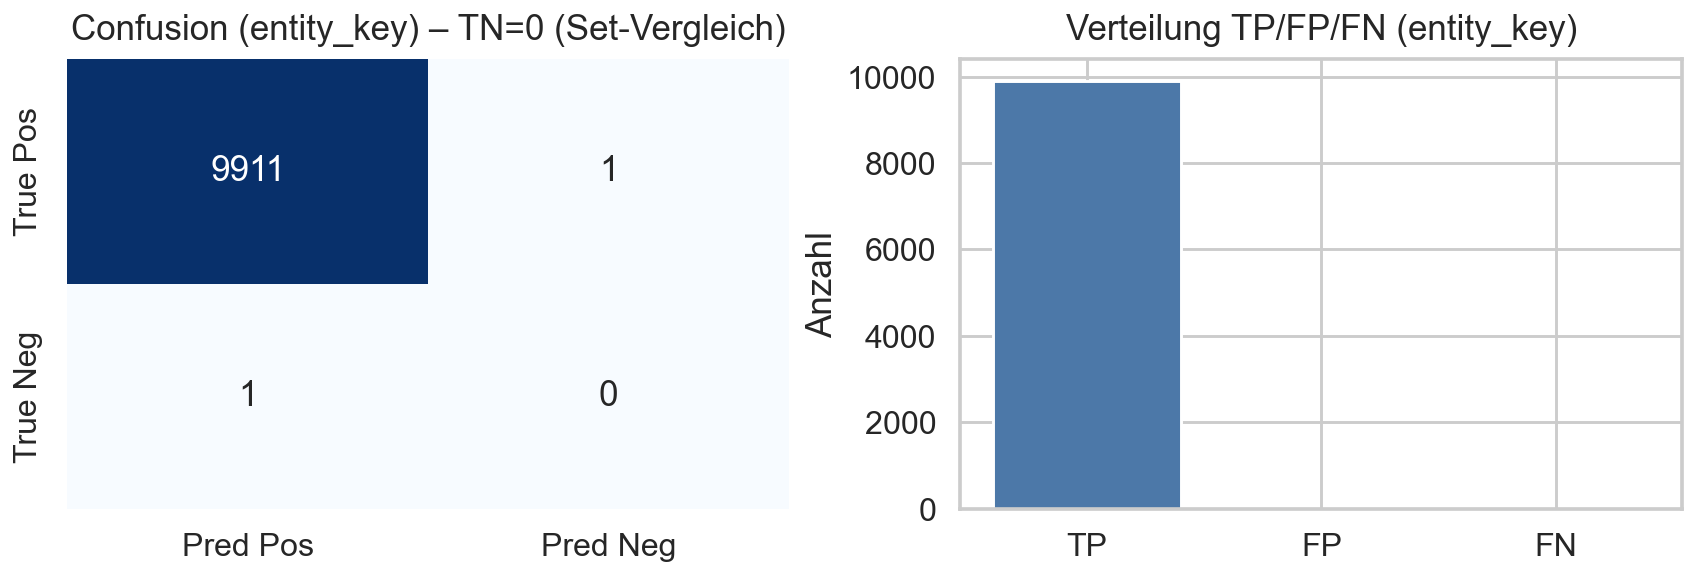

Beispiele FP (nur Adaptive):


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
1938,crywolf,2005,<NA>,<NA>,651,5970


Beispiele FN (nur Groundtruth):


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
3154,cry_wolf,2005,<NA>,5034,651,5970



Metriken je ID-Quelle:


,source_id,tp,fp,fn,precision,recall,f1,jaccard
0,ID_IMDB,3012.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000
1,ID_RT,9541.0000,0.0000,1.0000,1.0000,0.9999,0.9999,0.9999
2,ID_METACRITIC,7848.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000
3,ID_MOVIELENS,5839.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000


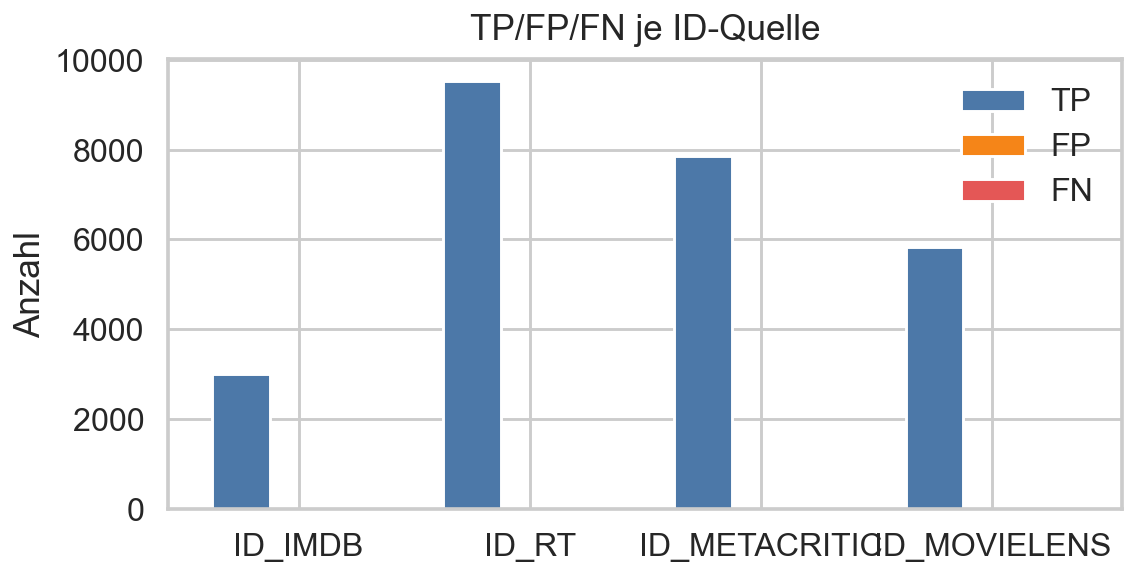


Übersicht (Overall + je Quelle):


,scope,tp,fp,fn,precision,recall,f1,jaccard
0,entity_key_overall,9911,1,1,0.9999,0.9999,0.9999,0.9998
1,ID_IMDB,3012,0,0,1.0000,1.0000,1.0000,1.0000
2,ID_RT,9541,0,1,1.0000,0.9999,0.9999,0.9999
3,ID_METACRITIC,7848,0,0,1.0000,1.0000,1.0000,1.0000
4,ID_MOVIELENS,5839,0,0,1.0000,1.0000,1.0000,1.0000


In [251]:
# ID-basierte Confusion-/Metrik-Analyse + Visualisierung (keine Schreibzugriffe)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def add_entity_key(df):
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["entity_key"] = df[id_cols].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]), axis=1)
    return df

# Laden + Keys
ad = add_entity_key(pd.read_csv(p_ad_final, dtype=str))
st = add_entity_key(pd.read_csv(p_st_final, dtype=str))

# Set-Vergleich overall (entity_key)
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])

tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys
fn_keys = st_keys - ad_keys

TP = len(tp_keys)
FP = len(fp_keys)
FN = len(fn_keys)
TN = 0  # für Set-Vergleich nicht definiert – 0 zur Visualisierung

def metrics(tp, fp, fn):
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall    = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if precision+recall > 0 else 0.0
    jaccard   = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
    return dict(precision=precision, recall=recall, f1=f1, jaccard=jaccard)

overall = metrics(TP, FP, FN)

print(f"Gesamt (entity_key): TP={TP}  FP={FP}  FN={FN}")
print(f"Precision={overall['precision']:.4f}  Recall={overall['recall']:.4f}  F1={overall['f1']:.4f}  Jaccard={overall['jaccard']:.4f}")

# Confusion-"Matrix" (2x2, TN=0 mangels Universum)
cm = np.array([[TP, FN],
               [FP, TN]], dtype=int)
labels = [["TP","FN"],["FP","TN"]]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
if HAS_SNS:
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0],
                xticklabels=["Pred Pos","Pred Neg"], yticklabels=["True Pos","True Neg"])
else:
    im = ax[0].imshow(cm, cmap="Blues")
    for (i,j), v in np.ndenumerate(cm):
        ax[0].text(j, i, str(v), ha="center", va="center", color="black")
    ax[0].set_xticks([0,1]); ax[0].set_xticklabels(["Pred Pos","Pred Neg"])
    ax[0].set_yticks([0,1]); ax[0].set_yticklabels(["True Pos","True Neg"])
ax[0].set_title("Confusion (entity_key) – TN=0 (Set-Vergleich)")

# Balken: TP/FP/FN
ax[1].bar(["TP","FP","FN"], [TP, FP, FN], color=["#4c78a8","#f58518","#e45756"])
ax[1].set_title("Verteilung TP/FP/FN (entity_key)")
ax[1].set_ylabel("Anzahl")
plt.show()

# Tabellen für FP / FN Beispiele
from IPython.display import display
fp = ad[ad["entity_key"].isin(fp_keys)][["title","release_year"] + id_cols].head(10)
fn = st[st["entity_key"].isin(fn_keys)][["title","release_year"] + id_cols].head(10)
print("Beispiele FP (nur Adaptive):")
display(fp)
print("Beispiele FN (nur Groundtruth):")
display(fn)

# Per-ID-Quelle: Mengenvergleich und Metriken
def per_source_sets(df, col):
    return set(df[col].dropna().astype(str))

per_src = {}
for col in id_cols:
    ad_set = per_source_sets(ad, col)
    st_set = per_source_sets(st, col)
    tp = len(ad_set & st_set)
    fp = len(ad_set - st_set)
    fn = len(st_set - ad_set)
    per_src[col] = dict(tp=tp, fp=fp, fn=fn, **metrics(tp, fp, fn))

per_src_df = (pd.DataFrame(per_src).T
              .rename_axis("source_id")
              .reset_index()
              .assign(precision=lambda d: d["precision"].round(4),
                      recall=lambda d: d["recall"].round(4),
                      f1=lambda d: d["f1"].round(4),
                      jaccard=lambda d: d["jaccard"].round(4)))
print("\nMetriken je ID-Quelle:")
display(per_src_df[["source_id","tp","fp","fn","precision","recall","f1","jaccard"]])

# Visualisierung per ID-Quelle: Balken TP/FP/FN
fig2, ax2 = plt.subplots(figsize=(8, 4), constrained_layout=True)
idx = np.arange(len(id_cols))
tp_vals = [per_src[c]["tp"] for c in id_cols]
fp_vals = [per_src[c]["fp"] for c in id_cols]
fn_vals = [per_src[c]["fn"] for c in id_cols]
width = 0.25
ax2.bar(idx - width, tp_vals, width=width, label="TP", color="#4c78a8")
ax2.bar(idx,         fp_vals, width=width, label="FP", color="#f58518")
ax2.bar(idx + width, fn_vals, width=width, label="FN", color="#e45756")
ax2.set_xticks(idx); ax2.set_xticklabels(id_cols)
ax2.set_ylabel("Anzahl"); ax2.set_title("TP/FP/FN je ID-Quelle")
ax2.legend()
plt.show()

# Kompakte Übersicht als Tabelle (Overall + je Quelle)
summary_rows = [
    dict(scope="entity_key_overall", tp=TP, fp=FP, fn=FN, **{k: round(v,4) for k,v in overall.items()})
]
for c in id_cols:
    d = per_src[c]
    summary_rows.append(dict(scope=c, tp=d["tp"], fp=d["fp"], fn=d["fn"],
                             precision=round(d["precision"],4),
                             recall=round(d["recall"],4),
                             f1=round(d["f1"],4),
                             jaccard=round(d["jaccard"],4)))
summary_df = pd.DataFrame(summary_rows)
print("\nÜbersicht (Overall + je Quelle):")
display(summary_df)

TP=0 | FP=9,912 | FN=9,912

Exakte Feld‑Mismatches (nur TPs, ohne Normalisierung):


,field,num_mismatches
0,title,0
1,release_year,0
2,genres,0
3,rating_imdb,0
4,rating_metacritic,0
5,rating_movielens,0
6,rating_rt_audience,0


/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_15741/1367961285.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mismatch_summary["field"], rotation=30, ha="right")
/Users/jakob/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


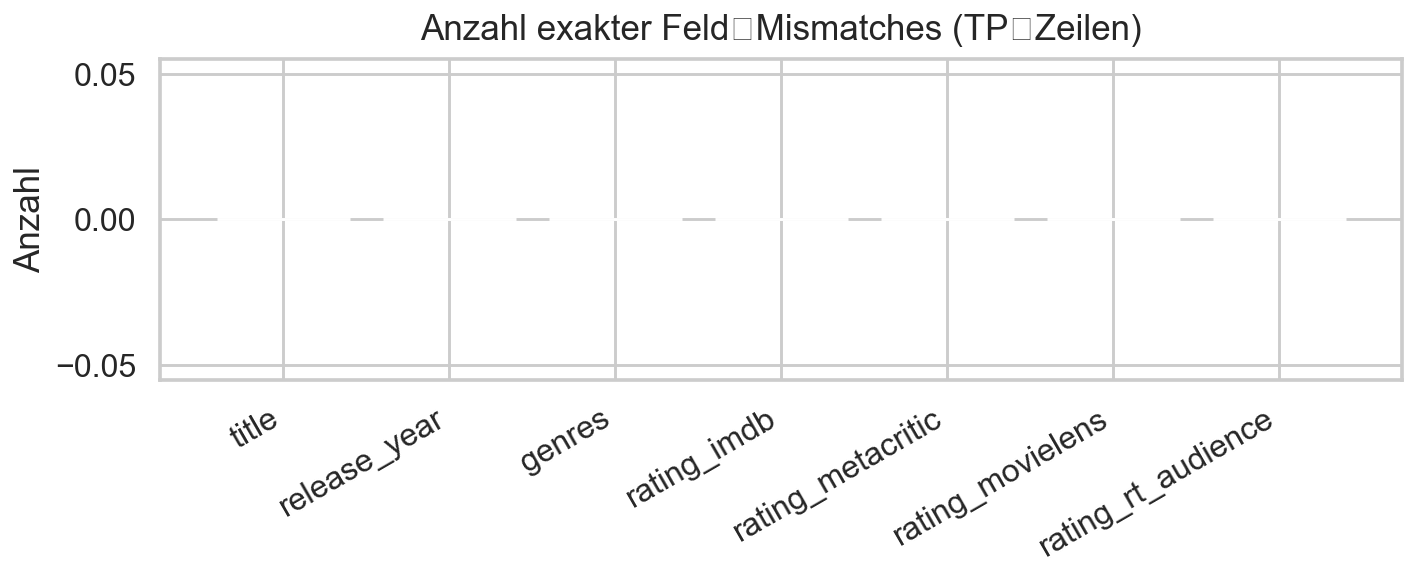


Keine numerischen Deltas > 0 (oder nicht numerisch auswertbar).

Preview: Feldvergleich (erste 10 TPs)


,entity_key,title_ad,title_st,title_eq_exact,release_year_ad,release_year_st,release_year_eq_exact,genres_ad,genres_st,genres_eq_exact,rating_imdb_ad,rating_imdb_st,rating_imdb_eq_exact,rating_metacritic_ad,rating_metacritic_st,rating_metacritic_eq_exact,rating_movielens_ad,rating_movielens_st,rating_movielens_eq_exact,rating_rt_audience_ad,rating_rt_audience_st,rating_rt_audience_eq_exact


In [252]:
# Feldweiser 1:1-Vergleich der FINALEN Sets (ohne Normalisierung)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def add_entity_key_raw(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        # keine .0-Entfernung o.ä.: wir nehmen die raw-Strings der finalen Sets
        df[c] = df[c].astype("string")
    # fehlende als "NA" nur für den Schlüssel (ändert nicht die Felder)
    key_df = df[id_cols].astype("string").fillna("NA")
    df["entity_key"] = key_df.apply(lambda r: "|".join([r[c] for c in id_cols]), axis=1)
    return df

# Laden (raw) + Keys
ad = add_entity_key_raw(pd.read_csv(p_ad_final, dtype=str, keep_default_na=True))
st = add_entity_key_raw(pd.read_csv(p_st_final, dtype=str, keep_default_na=True))

# TP/FP/FN auf entity_key (raw)
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])
tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys
fn_keys = st_keys - ad_keys

print(f"TP={len(tp_keys):,} | FP={len(fp_keys):,} | FN={len(fn_keys):,}")

# Nur TPs feldweise vergleichen (raw Felder)
ad_tp = ad[ad["entity_key"].isin(tp_keys)].copy()
st_tp = st[st["entity_key"].isin(tp_keys)].copy()
df = ad_tp.merge(st_tp, on="entity_key", suffixes=("_ad","_st"))

# Relevante gemeinsame Felder suchen
common_cols = sorted(set(ad.columns) & set(st.columns))
# Fokusfelder definieren (nur wenn vorhanden)
focus_base = ["title","release_year","genres"]
focus_ratings = [c for c in common_cols if c.startswith("rating_")]
focus_extra = [c for c in ["count_ratings"] if c in common_cols]
focus_cols = [c for c in focus_base + focus_ratings + focus_extra if c in common_cols]

# Exakte Feldgleichheit (Stringvergleich) für Fokusfelder
eq_rows = []
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"
    if a not in df.columns or b not in df.columns:
        continue
    eq_col = f"{c}_eq_exact"
    df[eq_col] = (df[a].fillna("") == df[b].fillna(""))
    eq_rows.append((c, int((~df[eq_col]).sum())))

mismatch_summary = pd.DataFrame(eq_rows, columns=["field","num_mismatches"]).sort_values("num_mismatches", ascending=False).reset_index(drop=True)

print("\nExakte Feld‑Mismatches (nur TPs, ohne Normalisierung):")
from IPython.display import display
display(mismatch_summary)

# Beispiele je Feld mit Abweichungen
def show_examples_for_field(field, n=8):
    a = f"{field}_ad"; b = f"{field}_st"; eq = f"{field}_eq_exact"
    if eq not in df.columns:
        print(f"{field}: nicht vorhanden")
        return
    cols = ["entity_key"] + [a, b]
    sel = df.loc[~df[eq], cols].head(n)
    print(f"\nBeispiele – Abweichungen in {field} (n={len(sel)})")
    display(sel)

for field in [f for f in mismatch_summary["field"].tolist() if mismatch_summary.set_index("field").loc[f, "num_mismatches"] > 0][:6]:
    show_examples_for_field(field, n=8)

# Numerische Deltas für Felder, die numerisch sind (z. B. Ratings, release_year, count_ratings)
def to_num(x):
    v = pd.to_numeric(x, errors="coerce")
    return float(v) if pd.notna(v) else np.nan

numeric_candidates = []
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"
    if a in df.columns and b in df.columns:
        # prüfe, ob mind. eine Zeile zu float konvertierbar ist
        tmp = pd.to_numeric(df[a], errors="coerce").notna() | pd.to_numeric(df[b], errors="coerce").notna()
        if bool(tmp.any()):
            numeric_candidates.append(c)

for c in numeric_candidates:
    a = f"{c}_ad"; b = f"{c}_st"
    d = f"{c}_delta"
    df[d] = df[a].map(to_num) - df[b].map(to_num)

# Plot: Mismatch‑Counts
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.bar(mismatch_summary["field"], mismatch_summary["num_mismatches"], color="#e45756")
ax.set_title("Anzahl exakter Feld‑Mismatches (TP‑Zeilen)")
ax.set_ylabel("Anzahl")
ax.set_xticklabels(mismatch_summary["field"], rotation=30, ha="right")
plt.show()

# Plot: Deltaverteilungen für numerische Felder (nur wenn Unterschiede existieren)
nz_deltas = []
for c in numeric_candidates:
    d = f"{c}_delta"
    if d in df.columns and df[d].notna().any() and (df[d].fillna(0) != 0).any():
        nz = df.loc[df[d].notna() & (df[d] != 0), d]
        nz_deltas.append((c, nz))

if nz_deltas:
    n = len(nz_deltas)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 3), constrained_layout=True)
    if n == 1:
        axs = [axs]
    for ax, (c, series) in zip(axs, nz_deltas):
        if HAS_SNS:
            sns.histplot(series, bins=30, ax=ax, color="#4c78a8")
        else:
            ax.hist(series, bins=30, color="#4c78a8")
        ax.set_title(f"{c} Δ (ad - st)")
        ax.set_xlabel("Delta")
    plt.show()
else:
    print("\nKeine numerischen Deltas > 0 (oder nicht numerisch auswertbar).")

# Kompakte Übersichtstabelle mit Gleichheits-Flaggen und optionalen Deltas (erste 10 Zeilen)
preview_cols = ["entity_key"]
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"; eq = f"{c}_eq_exact"
    if a in df.columns and b in df.columns:
        preview_cols += [a, b, eq]
        d = f"{c}_delta"
        if d in df.columns:
            preview_cols.append(d)

print("\nPreview: Feldvergleich (erste 10 TPs)")
display(df[preview_cols].head(10))

In [256]:
# End-to-End-Fallanalyse per IDs: Rohquellen (Adaptive/Static) + Wide/Final (beide Pipelines)
import pandas as pd
from IPython.display import display

# === Ziel-IDs für den Film ===
ID_RT   = "5034"
ID_MC   = "651"
ID_ML   = "5970"
ID_IMDB = None  # falls bekannt, z. B. "2460"; sonst None

# === Pfade ===
# Adaptive (Cleaned + Merges)
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"                  
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"    
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"         
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"      
p_ad_wide = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"            
p_ad_final= "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"

# Static (Adapter-Outputs + Merges)
p_st_imdb = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv"           
p_st_rt   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv" 
p_st_mc   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MetacriticAdapter.csv"     
p_st_ml   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MovielensAdapter.csv"      
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# === Helper ===
def load(path):
    return pd.read_csv(path, dtype=str, keep_default_na=True)

def id_variants(x):
    if x is None: return set()
    s = str(x)
    return {s, f"{s}.0"}

def match_ids(df, id_map):
    """
    id_map: dict wie {"ID_RT": {"5034","5034.0"}, ...}
    matched wenn JEDE im df vorhandene Bedingung erfüllt ist.
    Fehlende Spalten werden ignoriert.
    """
    if not id_map:
        return pd.Series([True]*len(df), index=df.index)
    mask = pd.Series([True]*len(df), index=df.index)
    for col, vals in id_map.items():
        if col in df.columns and vals:
            mask = mask & df[col].astype(str).isin(vals)
    return mask

def pick_cols(df, extra=None):
    base = ["title","release_year","year","release_date","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]
    if extra:
        base += extra
    return [c for c in base if c in df.columns]

def show(df, title, n=5, extra=None):
    print(title)
    if df.empty:
        print("(keine Treffer)\n")
    else:
        display(df[pick_cols(df, extra)].head(n))

# === Ziel-ID-Mengen ===
rt_vals   = id_variants(ID_RT)
mc_vals   = id_variants(ID_MC)
ml_vals   = id_variants(ID_ML)
imdb_vals = id_variants(ID_IMDB) if ID_IMDB else set()

# === 1) Rohquellen: Adaptive Cleaned ===
ad_rt_src   = load(p_ad_rt).rename(columns={"ID":"ID_RT"})
ad_mc_src   = load(p_ad_mc).rename(columns={"ID":"ID_METACRITIC"})
ad_ml_src   = load(p_ad_ml).rename(columns={"ID":"ID_MOVIELENS"})
ad_imdb_src = load(p_ad_imdb).rename(columns={"ID":"ID_IMDB"})

show(ad_rt_src[ match_ids(ad_rt_src, {"ID_RT": rt_vals}) ], "Adaptive Cleaned – RT‑Quelle")
show(ad_mc_src[ match_ids(ad_mc_src, {"ID_METACRITIC": mc_vals}) ], "Adaptive Cleaned – Metacritic‑Quelle")
show(ad_ml_src[ match_ids(ad_ml_src, {"ID_MOVIELENS": ml_vals}) ], "Adaptive Cleaned – Movielens‑Quelle")
if imdb_vals:
    show(ad_imdb_src[ match_ids(ad_imdb_src, {"ID_IMDB": imdb_vals}) ], "Adaptive Cleaned – IMDb‑Quelle")
else:
    print("Adaptive Cleaned – IMDb‑Quelle: (ID_IMDB unbekannt)\n")

# === 2) Rohquellen: Static Adapter-Outputs ===
st_rt_src   = load(p_st_rt)
st_mc_src   = load(p_st_mc)
st_ml_src   = load(p_st_ml)
st_imdb_src = load(p_st_imdb)

show(st_rt_src[ match_ids(st_rt_src, {"ID_RT": rt_vals}) ], "Static Adapter – RT")
show(st_mc_src[ match_ids(st_mc_src, {"ID_METACRITIC": mc_vals}) ], "Static Adapter – Metacritic")
show(st_ml_src[ match_ids(st_ml_src, {"ID_MOVIELENS": ml_vals}) ], "Static Adapter – Movielens")
if imdb_vals:
    show(st_imdb_src[ match_ids(st_imdb_src, {"ID_IMDB": imdb_vals}) ], "Static Adapter – IMDb")
else:
    print("Static Adapter – IMDb: (ID_IMDB unbekannt)\n")

# === 3) Merge‑Zwischenstände: Wide (beide Pipelines) ===
ad_wide   = load(p_ad_wide)
st_unfil  = load(p_st_unfil)

# a) Ziel‑Triple MC+ML
ad_wide_mcml = ad_wide[ match_ids(ad_wide, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
st_unfil_mcml= st_unfil[ match_ids(st_unfil, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]

# b) Alle Zeilen mit RT‑ID
ad_wide_rt = ad_wide[ match_ids(ad_wide, {"ID_RT": rt_vals}) ]
st_unfil_rt= st_unfil[ match_ids(st_unfil, {"ID_RT": rt_vals}) ]

show(ad_wide_mcml, "Adaptive Wide – Ziel‑Triple (MC+ML)")
show(st_unfil_mcml,"Static Unfiltered Wide – Ziel‑Triple (MC+ML)")
show(ad_wide_rt,  "Adaptive Wide – alle Zeilen mit RT")
show(st_unfil_rt, "Static Unfiltered Wide – alle Zeilen mit RT")

# === 4) Endstände: Final (beide Pipelines) ===
ad_final = load(p_ad_final)
st_final = load(p_st_final)

ad_final_mcml = ad_final[ match_ids(ad_final, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
st_final_mcml = st_final[ match_ids(st_final, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
ad_final_rt   = ad_final[ match_ids(ad_final, {"ID_RT": rt_vals}) ]
st_final_rt   = st_final[ match_ids(st_final, {"ID_RT": rt_vals}) ]

show(ad_final_mcml, "Adaptive Final – Ziel‑Triple (MC+ML)", extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(st_final_mcml, "Static Final – Ziel‑Triple (MC+ML)",    extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(ad_final_rt,   "Adaptive Final – alle Zeilen mit RT",   extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(st_final_rt,   "Static Final – alle Zeilen mit RT",     extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])

# === 5) Heuristische Kurzdiagnose ===
issues = []
if ad_wide_mcml.empty:
    issues.append("Adaptive Wide enthält das Ziel‑Triple (MC+ML) nicht → Quelle/Clustering in Adaptive.")
else:
    if ("ID_RT" in ad_wide_mcml.columns) and ad_wide_mcml["ID_RT"].isna().all():
        issues.append("Adaptive Wide hat Ziel‑Triple, aber ohne RT → Zuordnung RT→Triple fehlte in Adaptive.")
if (not ad_wide_rt.empty) and ad_wide_mcml.empty:
    issues.append("Adaptive Wide hat RT=Ziel‑ID, aber in anderem Triple → falsches Matching/Cluster.")
if (not ad_final_mcml.empty) and ("ID_RT" in ad_final_mcml.columns) and ad_final_mcml["ID_RT"].isna().all() and (not st_final_mcml.empty):
    issues.append("Adaptive Final ohne RT bei gleichem MC/ML, Static hat RT → Verlust nach Adaptive‑Wide (Filter/Postmerge).")
if st_unfil_mcml.empty:
    issues.append("Static Wide (unfiltered) enthält das Ziel‑Triple nicht (unerwartet).")
if (st_final_mcml.empty) and (not st_unfil_mcml.empty):
    issues.append("Static Final filtert das Ziel‑Triple raus (count_ratings < 2 o.ä.).")

print("\nHeuristische Diagnose:")
print(" - " + "\n - ".join(issues) if issues else " - Keine offensichtliche Anomalie über Heuristik hinaus.")

Adaptive Cleaned – RT‑Quelle


,title,release_year,ID_RT
5002,cry wolf,2005,5034


Adaptive Cleaned – Metacritic‑Quelle


,title,release_year,ID_METACRITIC
650,crywolf,2005,651


Adaptive Cleaned – Movielens‑Quelle


,title,release_year,ID_MOVIELENS
5968,crywolf,2005,5970


Adaptive Cleaned – IMDb‑Quelle: (ID_IMDB unbekannt)

Static Adapter – RT


,title,year,ID_RT
5002,cry_wolf,2005,5034


Static Adapter – Metacritic


,title,year,ID_METACRITIC
650,cry_wolf,2005,651


Static Adapter – Movielens


,title,year,ID_MOVIELENS
5968,cry_wolf,2005,5970


Static Adapter – IMDb: (ID_IMDB unbekannt)

Adaptive Wide – Ziel‑Triple (MC+ML)
(keine Treffer)

Static Unfiltered Wide – Ziel‑Triple (MC+ML)


,title,year,release_date,ID_IMDB,ID_METACRITIC,ID_MOVIELENS
4541,cry wolf,2005,NaN,NaN,651.0,5970.0


Adaptive Wide – alle Zeilen mit RT


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
1796,crywolf,2005,NaN,5034.0,651.0,NaN


Static Unfiltered Wide – alle Zeilen mit RT


,title,year,release_date,ID_IMDB,ID_METACRITIC,ID_MOVIELENS
0,00 schneider jagd auf nihil baxter,1994,NaN,NaN,NaN,9251.0
1,1,2013,NaN,NaN,NaN,NaN
2,1 000 times good night,2014,NaN,NaN,NaN,NaN
3,1 54,2018,NaN,NaN,NaN,NaN
4,1 900,1994,NaN,NaN,NaN,675.0


Adaptive Final – Ziel‑Triple (MC+ML)


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
1938,crywolf,2005,NaN,NaN,651,5970,NaN,NaN,39.0,2.2


Static Final – Ziel‑Triple (MC+ML)


,title,release_year,release_date,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,count_ratings,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
3154,cry_wolf,2005,NaN,NaN,5034.0,651.0,5970.0,3,NaN,24.0,39.0,2.2


Adaptive Final – alle Zeilen mit RT
(keine Treffer)

Static Final – alle Zeilen mit RT


,title,release_year,release_date,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,count_ratings,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
3154,cry_wolf,2005,NaN,NaN,5034.0,651.0,5970.0,3,NaN,24.0,39.0,2.2



Heuristische Diagnose:
 - Adaptive Wide enthält das Ziel‑Triple (MC+ML) nicht → Quelle/Clustering in Adaptive.
 - Adaptive Wide hat RT=Ziel‑ID, aber in anderem Triple → falsches Matching/Cluster.
 - Adaptive Final ohne RT bei gleichem MC/ML, Static hat RT → Verlust nach Adaptive‑Wide (Filter/Postmerge).
